In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics as mt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from matplotlib.pyplot import figure
import time
import sys

In [2]:
port_log = pd.read_csv('log2.csv')
port_log.head()

Source Port  Destination Port  NAT Source Port  NAT Destination Port  \
0        57222                53            54587                    53   
1        56258              3389            56258                  3389   
2         6881             50321            43265                 50321   
3        50553              3389            50553                  3389   
4        50002               443            45848                   443   

  Action  Bytes  Bytes Sent  Bytes Received  Packets  Elapsed Time (sec)  \
0  allow    177          94              83        2                  30   
1  allow   4768        1600            3168       19                  17   
2  allow    238         118             120        2                1199   
3  allow   3327        1438            1889       15                  17   
4  allow  25358        6778           18580       31                  16   

   pkts_sent  pkts_received  
0          1              1  
1         10              9  
2          1              1  
3          8              7  
4         13             18

In [3]:
port_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [4]:
port_log.isna().mean()

Source Port             0.0
Destination Port        0.0
NAT Source Port         0.0
NAT Destination Port    0.0
Action                  0.0
Bytes                   0.0
Bytes Sent              0.0
Bytes Received          0.0
Packets                 0.0
Elapsed Time (sec)      0.0
pkts_sent               0.0
pkts_received           0.0
dtype: float64

In [5]:
port_log['Action'].value_counts()

allow         37640
deny          14987
drop          12851
reset-both       54
Name: Action, dtype: int64

In [6]:
port_log.shape

(65532, 12)

In [7]:
#Action is response variable, change class 'allow' to 0, 'deny' to 1 and merge 'drop' and 'reset-both' to 2.
port_log['Action'] = [0 if x == 'allow' else 1 if x=='deny' else 2 for x in port_log['Action']]

In [8]:
port_log['Action'].value_counts() #Check if value counts match

0    37640
1    14987
2    12905
Name: Action, dtype: int64

In [9]:
#One-hot encoding all port numbers.
port_log['Source Port'] = port_log['Source Port'].astype('category')
port_log['Destination Port'] = port_log['Destination Port'].astype('category')
port_log['NAT Source Port'] = port_log['NAT Source Port'].astype('category')
port_log['NAT Destination Port'] = port_log['NAT Destination Port'].astype('category')

In [10]:
port_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Source Port           65532 non-null  category
 1   Destination Port      65532 non-null  category
 2   NAT Source Port       65532 non-null  category
 3   NAT Destination Port  65532 non-null  category
 4   Action                65532 non-null  int64   
 5   Bytes                 65532 non-null  int64   
 6   Bytes Sent            65532 non-null  int64   
 7   Bytes Received        65532 non-null  int64   
 8   Packets               65532 non-null  int64   
 9   Elapsed Time (sec)    65532 non-null  int64   
 10  pkts_sent             65532 non-null  int64   
 11  pkts_received         65532 non-null  int64   
dtypes: category(4), int64(8)
memory usage: 6.6 MB


In [11]:
port_log['Source Port'].unique()

[57222, 56258, 6881, 50553, 50002, ..., 61308, 30023, 53518, 36226, 54871]
Length: 22724
Categories (22724, int64): [57222, 56258, 6881, 50553, ..., 30023, 53518, 36226, 54871]

In [12]:
#https://scikit-learn.org/stable/modules/preprocessing.html
#6.3.1.2. Scaling sparse data
scaler = StandardScaler(with_mean=False) #sparse matrix set with_mean=False
X = port_log.drop(['Action'], axis=1).copy()
y = port_log['Action'].copy()
X = pd.get_dummies(X, columns = ['Source Port', 'Destination Port','NAT Source Port', 'NAT Destination Port'], 
                   sparse=True)
X = X.astype(pd.SparseDtype('float', 0)) #change the data frame to sparse matrix
X = scaler.fit_transform(X)

In [13]:
X.shape

(65532, 57689)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=1, stratify=y, test_size=.2)

In [15]:
parameters = {'C':[.000001,.00001,.0001,.001,.01,.1,1,10]}
cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [38]:
SVC_GridSearch = GridSearchCV(LinearSVC(loss='squared_hinge', dual=False,
                              class_weight='balanced', max_iter=1000, random_state=1), 
                              param_grid=parameters, cv=cv, n_jobs=7, verbose=1, scoring='accuracy')
SVC_GridSearch.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=LinearSVC(class_weight='balanced', dual=False,
                                 random_state=1),
             n_jobs=7,
             param_grid={'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]},
             scoring='accuracy', verbose=1)

In [39]:
SVC_GridSearch.best_estimator_

LinearSVC(C=0.001, class_weight='balanced', dual=False, random_state=1)

In [33]:
%%time
svclinear_clf = LinearSVC(loss='squared_hinge', dual=False, C=.001, 
                          class_weight='balanced', max_iter=1000, random_state=1).fit(X_train, y_train)
y_pred = svclinear_clf.predict(X_test)

Wall time: 6.27 s


In [34]:
print(classification_report(y_test, y_pred))
print('\n')
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
print('\n')
print('Accuracy: \n', accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7528
           1       0.98      0.99      0.99      2998
           2       1.00      1.00      1.00      2581

    accuracy                           0.99     13107
   macro avg       0.99      0.99      0.99     13107
weighted avg       0.99      0.99      0.99     13107



Confusion Matrix: 
 [[7477   46    5]
 [   8 2983    7]
 [   7    3 2571]]


Accuracy: 
 0.9942015716792554


In [35]:
recall = mt.recall_score(y_test, y_pred, average='weighted')
print("recall\n",recall)

recall
 0.9942015716792554


In [36]:
precision = mt.precision_score(y_test, y_pred, average='weighted')
print("precision\n",precision)

precision
 0.9942387035122449


In [51]:
#Try different values of Regularization parameter C and gama by using SVC with kernel function rbf
#Don't run
parameters = {'C':[.00001,.0001,.001,.01,.1,1,10], 'gamma':['scale', 'auto',1, 0.1, 0.01, 0.001]}

In [52]:
rbf_GridSearch = GridSearchCV(SVC(kernel='rbf', class_weight='balanced', max_iter=-1, 
                                  decision_function_shape='ovr', break_ties=True, random_state=1),
                              param_grid=parameters, cv=cv, n_jobs=7, verbose=1, scoring='accuracy')
rbf_GridSearch.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=SVC(break_ties=True, class_weight='balanced',
                           random_state=1),
             n_jobs=7,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01],
                         'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001]},
             scoring='accuracy', verbose=1)

In [56]:
rbf_GridSearch.best_estimator_

SVC(C=0.01, break_ties=True, class_weight='balanced', random_state=1)

In [57]:
%%time
svc_clf = SVC(C=.01, kernel='rbf', gamma='scale', class_weight='balanced', max_iter=-1, 
             decision_function_shape='ovr', break_ties=True, random_state=1).fit(X_train, y_train)
y_pred = svc_clf.predict(X_test)

Wall time: 2min 28s


In [58]:
print(classification_report(y_test, y_pred))
print('\n')
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
print('\n')
print('Accuracy: \n', accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      7528
           1       0.59      0.80      0.68      2998
           2       0.35      0.23      0.28      2581

    accuracy                           0.73     13107
   macro avg       0.61      0.64      0.62     13107
weighted avg       0.72      0.73      0.72     13107



Confusion Matrix: 
 [[6604   92  832]
 [ 307 2393  298]
 [ 387 1592  602]]


Accuracy: 
 0.7323567559319447


In [59]:
recall = mt.recall_score(y_test, y_pred, average='weighted')
print("recall\n",recall)

recall
 0.7323567559319447


In [60]:
precision = mt.precision_score(y_test, y_pred, average='weighted')
print("precision\n",precision)

precision
 0.7224306969372178


### SVC with linear kernal function performed better than RBF
### Try SGD

In [61]:
#Since we compare the result with SVM, we use 'hinge' loss in SGD
parameters_SGD = {'alpha':[.0001,.001,.01,.1,1,10,100,200], 'max_iter':[500,1000,1500,2000]} #max_iter is epochs numbers.

In [62]:
%%time
SGD_GridSearch = GridSearchCV(SGDClassifier(loss='hinge', penalty='l2',shuffle=True, n_jobs=7,
                                            learning_rate='optimal',early_stopping=True, validation_fraction= .1, 
                                            n_iter_no_change=10,class_weight='balanced', verbose=1, random_state=1),
                              param_grid=parameters_SGD, cv=cv, n_jobs=7, verbose=1, scoring='accuracy')
SGD_GridSearch.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.02 seconds.
Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.00 seconds.
Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.05 seconds.
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.05 seconds.
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.08 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 4
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 141546, Avg. loss: 0.013811
Total training time: 0.08 seconds.
Norm: 1.86, NNZs: 14473, Bias: -0.0925

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=SGDClassifier(class_weight='balanced',
                                     early_stopping=True, n_iter_no_change=10,
                                     n_jobs=7, random_state=1, verbose=1),
             n_jobs=7,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 200],
                         'max_iter': [500, 1000, 1500, 2000]},
             scoring='accuracy', verbose=1)

In [63]:
SGD_GridSearch.best_estimator_

SGDClassifier(alpha=0.1, class_weight='balanced', early_stopping=True,
              max_iter=500, n_iter_no_change=10, n_jobs=7, random_state=1,
              verbose=1)

In [16]:
%%time
SGD_clf = SGDClassifier(alpha=.1, max_iter=500, loss='hinge', penalty='l2',shuffle=True, n_jobs=7,
                        learning_rate='optimal',early_stopping=True, validation_fraction= .1, 
                        n_iter_no_change=10,class_weight='balanced', verbose=1, random_state=1).fit(X_train, y_train)
y_pred = SGD_clf.predict(X_test)
#The results converged after 11 epochs, so max_iter(epoch) doesn't have to be a high value.

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.02 seconds.
Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.03 seconds.
Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538

Total training time: 0.04 seconds.
-- Epoch 3
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.05 seconds.
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.03 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 141546, Avg. loss: 0.013811
Total training time: 0.06 seconds.
-- Epoch 3-- Epoch 3

-- Epoch 4
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.05 seconds.
Norm: 1.22, NNZs: 15783, Bias: 0.0383

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.7s finished


In [17]:
SGD_clf.n_iter_

11

In [22]:
def fit_and_score(estimator, max_iter, X_train, X_test, y_train, y_test):
    estimator.set_params(max_iter=max_iter)
    estimator.set_params(random_state=1)

    start = time.time()
    estimator.fit(X_train, y_train)

    fit_time = time.time() - start
    n_iter = estimator.n_iter_
    train_score = estimator.score(X_train, y_train)
    test_score = estimator.score(X_test, y_test)

    return fit_time, n_iter, train_score, test_score

In [29]:
estimator_dict = {"No stopping criterion": SGDClassifier(alpha=.1, max_iter=500, loss='hinge', penalty='l2',shuffle=True, n_jobs=7,
                        learning_rate='optimal',class_weight='balanced', verbose=1, random_state=1),
                  "Validation score": SGD_clf}

In [30]:
results = []
for estimator_name, estimator in estimator_dict.items():
    print(estimator_name + ": ", end="")
    for max_iter in range(1, 50):
        print(".", end="")
        sys.stdout.flush()

        fit_time, n_iter, train_score, test_score = fit_and_score(
            estimator, max_iter, X_train, X_test, y_train, y_test
        )

        results.append(
            (estimator_name, max_iter, fit_time, n_iter, train_score, test_score)
        )
    print("")

No stopping criterion: .

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1

-- Epoch 1
Norm: 3.63, NNZs: 9346, Bias: -0.110540, T: 52425, Avg. loss: 0.177081
Total training time: 0.79 seconds.
Norm: 3.84, NNZs: 9984, Bias: -0.100706, T: 52425, Avg. loss: 0.111862
Total training time: 0.01 seconds.
Norm: 2.33, NNZs: 10067, Bias: 0.034037, T: 52425, Avg. loss: 0.110509
Total training time: 0.01 seconds.
.-- Epoch 1-- Epoch 1

-- Epoch 1
Norm: 3.84, NNZs: 9984, Bias: -0.100706, T: 52425, Avg. loss: 0.111862
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 3.63, NNZs: 9346, Bias: -0.110540, T: 52425, Avg. loss: 0.177081
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 2.33, NNZs: 10067, Bias: 0.034037, T: 52425, Avg. loss: 0.110509
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 2.28, NNZs: 12845, Bias: -0.101986, T: 104850, Avg. loss: 0.029749
Total training time: 0.02 seconds.
Norm: 2.20, NNZs: 12068, Bias: -0.111792, T: 104850, Avg. loss: 0.036513
Total training time: 0.02 seconds.
Norm: 1.46, NNZs: 13608, Bias: 0.034768, T: 1048

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.7s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.0s finished


.-- Epoch 1-- Epoch 1

-- Epoch 1
Norm: 3.63, NNZs: 9346, Bias: -0.110540, T: 52425, Avg. loss: 0.177081Norm: 3.84, NNZs: 9984, Bias: -0.100706, T: 52425, Avg. loss: 0.111862
Total training time: 0.02 seconds.

Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
Norm: 2.33, NNZs: 10067, Bias: 0.034037, T: 52425, Avg. loss: 0.110509
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 2.20, NNZs: 12068, Bias: -0.111792, T: 104850, Avg. loss: 0.036513Norm: 2.28, NNZs: 12845, Bias: -0.101986, T: 104850, Avg. loss: 0.029749
Total training time: 0.03 seconds.

Total training time: 0.03 seconds.
-- Epoch 3
-- Epoch 3
Norm: 1.46, NNZs: 13608, Bias: 0.034768, T: 104850, Avg. loss: 0.021318
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 1.70, NNZs: 14527, Bias: -0.112620, T: 157275, Avg. loss: 0.014891
Total training time: 0.05 seconds.
Norm: 1.76, NNZs: 15515, Bias: -0.102721, T: 157275, Avg. loss: 0.017683
Total training time: 0.05 seconds.
Norm: 1.17, NNZs: 17272, Bias: 0.035219, T:

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 3
Norm: 1.46, NNZs: 13608, Bias: 0.034768, T: 104850, Avg. loss: 0.021318
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 2.20, NNZs: 12068, Bias: -0.111792, T: 104850, Avg. loss: 0.036513
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 1.76, NNZs: 15515, Bias: -0.102721, T: 157275, Avg. loss: 0.017683
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 1.17, NNZs: 17272, Bias: 0.035219, T: 157275, Avg. loss: 0.011891
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 1.70, NNZs: 14527, Bias: -0.112620, T: 157275, Avg. loss: 0.014891
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 1.04, NNZs: 21017, Bias: 0.035501, T: 209700, Avg. loss: 0.009755
Total training time: 0.06 seconds.
Norm: 1.50, NNZs: 18025, Bias: -0.103216, T: 209700, Avg. loss: 0.014720
Total training time: 0.07 seconds.
Norm: 1.45, NNZs: 16933, Bias: -0.113179, T: 209700, Avg. loss: 0.012030
Total training time: 0.07 seconds.
.-- Epoch 1-- Epoch 1

-- Epoch 1
Norm: 3.63, NNZs: 9346, Bias: -0.110540

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 3.63, NNZs: 9346, Bias: -0.110540, T: 52425, Avg. loss: 0.177081
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 2.33, NNZs: 10067, Bias: 0.034037, T: 52425, Avg. loss: 0.110509
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 3.84, NNZs: 9984, Bias: -0.100706, T: 52425, Avg. loss: 0.111862
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 2.20, NNZs: 12068, Bias: -0.111792, T: 104850, Avg. loss: 0.036513
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 1.46, NNZs: 13608, Bias: 0.034768, T: 104850, Avg. loss: 0.021318
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 2.28, NNZs: 12845, Bias: -0.101986, T: 104850, Avg. loss: 0.029749
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 1.70, NNZs: 14527, Bias: -0.112620, T: 157275, Avg. loss: 0.014891
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 1.17, NNZs: 17272, Bias: 0.035219, T: 157275, Avg. loss: 0.011891
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 1.76, NNZs: 15515

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1

-- Epoch 1
Norm: 3.63, NNZs: 9346, Bias: -0.110540, T: 52425, Avg. loss: 0.177081
Total training time: 0.01 seconds.
Norm: 3.84, NNZs: 9984, Bias: -0.100706, T: 52425, Avg. loss: 0.111862-- Epoch 2

Total training time: 0.01 seconds.
-- Epoch 2
Norm: 2.33, NNZs: 10067, Bias: 0.034037, T: 52425, Avg. loss: 0.110509
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 2.20, NNZs: 12068, Bias: -0.111792, T: 104850, Avg. loss: 0.036513
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 2.28, NNZs: 12845, Bias: -0.101986, T: 104850, Avg. loss: 0.029749
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 1.46, NNZs: 13608, Bias: 0.034768, T: 104850, Avg. loss: 0.021318
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 1.70, NNZs: 14527, Bias: -0.112620, T: 157275, Avg. loss: 0.014891
Total training time: 0.03 seconds.
Norm: 1.76, NNZs: 15515, Bias: -0.102721, T: 157275, Avg. loss: 0.017683-- Epoch 4

Total training time: 0.03 seconds.
-- Epoch 4
Norm: 1.17, NNZs: 1727

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.0s finished


-- Epoch 1-- Epoch 1

-- Epoch 1
Norm: 3.63, NNZs: 9346, Bias: -0.110540, T: 52425, Avg. loss: 0.177081
Total training time: 0.01 seconds.
Norm: 2.33, NNZs: 10067, Bias: 0.034037, T: 52425, Avg. loss: 0.110509-- Epoch 2

Total training time: 0.01 seconds.
-- Epoch 2
Norm: 3.84, NNZs: 9984, Bias: -0.100706, T: 52425, Avg. loss: 0.111862
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 2.20, NNZs: 12068, Bias: -0.111792, T: 104850, Avg. loss: 0.036513
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 1.46, NNZs: 13608, Bias: 0.034768, T: 104850, Avg. loss: 0.021318
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 2.28, NNZs: 12845, Bias: -0.101986, T: 104850, Avg. loss: 0.029749
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 1.70, NNZs: 14527, Bias: -0.112620, T: 157275, Avg. loss: 0.014891
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 1.17, NNZs: 17272, Bias: 0.035219, T: 157275, Avg. loss: 0.011891
Total training time: 0.04 seconds.
Norm: 1.76, NNZs: 15515, Bias: -0.

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.0s finished


.-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 3.63, NNZs: 9346, Bias: -0.110540, T: 52425, Avg. loss: 0.177081
Total training time: 0.01 seconds.
Norm: 2.33, NNZs: 10067, Bias: 0.034037, T: 52425, Avg. loss: 0.110509-- Epoch 2

Total training time: 0.01 seconds.
-- Epoch 2
Norm: 3.84, NNZs: 9984, Bias: -0.100706, T: 52425, Avg. loss: 0.111862
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 2.20, NNZs: 12068, Bias: -0.111792, T: 104850, Avg. loss: 0.036513
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 1.46, NNZs: 13608, Bias: 0.034768, T: 104850, Avg. loss: 0.021318
Total training time: 0.03 seconds.
Norm: 2.28, NNZs: 12845, Bias: -0.101986, T: 104850, Avg. loss: 0.029749-- Epoch 3
Total training time: 0.03 seconds.

-- Epoch 3
Norm: 1.17, NNZs: 17272, Bias: 0.035219, T: 157275, Avg. loss: 0.011891
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 1.70, NNZs: 14527, Bias: -0.112620, T: 157275, Avg. loss: 0.014891
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 1.76, NNZs: 1551

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.0s finished


.-- Epoch 1-- Epoch 1

-- Epoch 1
Norm: 3.84, NNZs: 9984, Bias: -0.100706, T: 52425, Avg. loss: 0.111862Norm: 3.63, NNZs: 9346, Bias: -0.110540, T: 52425, Avg. loss: 0.177081
Total training time: 0.01 seconds.

Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 2
Norm: 2.33, NNZs: 10067, Bias: 0.034037, T: 52425, Avg. loss: 0.110509
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 2.28, NNZs: 12845, Bias: -0.101986, T: 104850, Avg. loss: 0.029749Norm: 2.20, NNZs: 12068, Bias: -0.111792, T: 104850, Avg. loss: 0.036513
Total training time: 0.02 seconds.

Total training time: 0.02 seconds.
-- Epoch 3
-- Epoch 3
Norm: 1.46, NNZs: 13608, Bias: 0.034768, T: 104850, Avg. loss: 0.021318
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 1.76, NNZs: 15515, Bias: -0.102721, T: 157275, Avg. loss: 0.017683Norm: 1.70, NNZs: 14527, Bias: -0.112620, T: 157275, Avg. loss: 0.014891
Total training time: 0.03 seconds.

Total training time: 0.03 seconds.
-- Epoch 4
-- Epoch 4
Norm: 1.17, NNZs: 172

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.0s finished


.-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 3.63, NNZs: 9346, Bias: -0.110540, T: 52425, Avg. loss: 0.177081
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 3.84, NNZs: 9984, Bias: -0.100706, T: 52425, Avg. loss: 0.111862
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 2.33, NNZs: 10067, Bias: 0.034037, T: 52425, Avg. loss: 0.110509
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 2.20, NNZs: 12068, Bias: -0.111792, T: 104850, Avg. loss: 0.036513
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 2.28, NNZs: 12845, Bias: -0.101986, T: 104850, Avg. loss: 0.029749
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 1.46, NNZs: 13608, Bias: 0.034768, T: 104850, Avg. loss: 0.021318
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 1.70, NNZs: 14527, Bias: -0.112620, T: 157275, Avg. loss: 0.014891
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 1.76, NNZs: 15515, Bias: -0.102721, T: 157275, Avg. loss: 0.017683
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 1.17, NNZs: 172

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.0s finished


.-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 2.33, NNZs: 10067, Bias: 0.034037, T: 52425, Avg. loss: 0.110509
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 3.63, NNZs: 9346, Bias: -0.110540, T: 52425, Avg. loss: 0.177081
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 3.84, NNZs: 9984, Bias: -0.100706, T: 52425, Avg. loss: 0.111862
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 1.46, NNZs: 13608, Bias: 0.034768, T: 104850, Avg. loss: 0.021318
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 2.20, NNZs: 12068, Bias: -0.111792, T: 104850, Avg. loss: 0.036513
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 2.28, NNZs: 12845, Bias: -0.101986, T: 104850, Avg. loss: 0.029749
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 1.17, NNZs: 17272, Bias: 0.035219, T: 157275, Avg. loss: 0.011891
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 1.70, NNZs: 14527, Bias: -0.112620, T: 157275, Avg. loss: 0.014891
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 1.76, NNZs: 1551

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished


.-- Epoch 1-- Epoch 1

-- Epoch 1
Norm: 3.63, NNZs: 9346, Bias: -0.110540, T: 52425, Avg. loss: 0.177081
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 3.84, NNZs: 9984, Bias: -0.100706, T: 52425, Avg. loss: 0.111862
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 2.33, NNZs: 10067, Bias: 0.034037, T: 52425, Avg. loss: 0.110509
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 2.28, NNZs: 12845, Bias: -0.101986, T: 104850, Avg. loss: 0.029749Norm: 2.20, NNZs: 12068, Bias: -0.111792, T: 104850, Avg. loss: 0.036513

Total training time: 0.03 seconds.
Total training time: 0.03 seconds.
-- Epoch 3
-- Epoch 3
Norm: 1.46, NNZs: 13608, Bias: 0.034768, T: 104850, Avg. loss: 0.021318
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 1.76, NNZs: 15515, Bias: -0.102721, T: 157275, Avg. loss: 0.017683
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 1.70, NNZs: 14527, Bias: -0.112620, T: 157275, Avg. loss: 0.014891
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 1.17, NNZs: 172

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished


-- Epoch 14
Norm: 0.92, NNZs: 35109, Bias: -0.115298, T: 733950, Avg. loss: 0.004433
Total training time: 0.17 seconds.
.-- Epoch 1-- Epoch 1

-- Epoch 1
Norm: 3.84, NNZs: 9984, Bias: -0.100706, T: 52425, Avg. loss: 0.111862
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 3.63, NNZs: 9346, Bias: -0.110540, T: 52425, Avg. loss: 0.177081
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 2.33, NNZs: 10067, Bias: 0.034037, T: 52425, Avg. loss: 0.110509
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 2.28, NNZs: 12845, Bias: -0.101986, T: 104850, Avg. loss: 0.029749
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 2.20, NNZs: 12068, Bias: -0.111792, T: 104850, Avg. loss: 0.036513
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 1.46, NNZs: 13608, Bias: 0.034768, T: 104850, Avg. loss: 0.021318
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 1.76, NNZs: 15515, Bias: -0.102721, T: 157275, Avg. loss: 0.017683
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 1.70, NNZs: 14

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


Convergence after 10 epochs took 0.15 seconds
Norm: 0.98, NNZs: 30210, Bias: -0.114914, T: 576675, Avg. loss: 0.005181
Total training time: 0.16 seconds.
Norm: 1.01, NNZs: 33023, Bias: -0.104882, T: 576675, Avg. loss: 0.008219-- Epoch 12

Total training time: 0.16 seconds.
-- Epoch 12
Norm: 0.96, NNZs: 31920, Bias: -0.115063, T: 629100, Avg. loss: 0.004781
Total training time: 0.17 seconds.
-- Epoch 13
Norm: 0.97, NNZs: 34214, Bias: -0.104958, T: 629100, Avg. loss: 0.007778
Total training time: 0.17 seconds.
Convergence after 12 epochs took 0.17 seconds
Norm: 0.94, NNZs: 33559, Bias: -0.115189, T: 681525, Avg. loss: 0.004352
Total training time: 0.18 seconds.
-- Epoch 14
Norm: 0.92, NNZs: 35109, Bias: -0.115298, T: 733950, Avg. loss: 0.004433
Total training time: 0.19 seconds.
-- Epoch 15
Norm: 0.90, NNZs: 36077, Bias: -0.115383, T: 786375, Avg. loss: 0.004082
Total training time: 0.20 seconds.
Convergence after 15 epochs took 0.20 seconds
.-- Epoch 1-- Epoch 1

-- Epoch 1
Norm: 3.84, 

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


Convergence after 12 epochs took 0.13 seconds
Norm: 0.96, NNZs: 31920, Bias: -0.115063, T: 629100, Avg. loss: 0.004781
Total training time: 0.13 seconds.
-- Epoch 13
Norm: 0.94, NNZs: 33559, Bias: -0.115189, T: 681525, Avg. loss: 0.004352
Total training time: 0.15 seconds.
-- Epoch 14
Norm: 0.92, NNZs: 35109, Bias: -0.115298, T: 733950, Avg. loss: 0.004433
Total training time: 0.16 seconds.
-- Epoch 15
Norm: 0.90, NNZs: 36077, Bias: -0.115383, T: 786375, Avg. loss: 0.004082
Total training time: 0.17 seconds.
Convergence after 15 epochs took 0.17 seconds
.-- Epoch 1-- Epoch 1

-- Epoch 1
Norm: 3.84, NNZs: 9984, Bias: -0.100706, T: 52425, Avg. loss: 0.111862
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 3.63, NNZs: 9346, Bias: -0.110540, T: 52425, Avg. loss: 0.177081
Total training time: 0.03 seconds.
Norm: 2.33, NNZs: 10067, Bias: 0.034037, T: 52425, Avg. loss: 0.110509-- Epoch 2
Total training time: 0.02 seconds.

-- Epoch 2
Norm: 2.28, NNZs: 12845, Bias: -0.101986, T: 104850, Av

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 3
Norm: 1.46, NNZs: 13608, Bias: 0.034768, T: 104850, Avg. loss: 0.021318
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 1.76, NNZs: 15515, Bias: -0.102721, T: 157275, Avg. loss: 0.017683
Total training time: 0.07 seconds.
-- Epoch 4
Norm: 1.70, NNZs: 14527, Bias: -0.112620, T: 157275, Avg. loss: 0.014891
Total training time: 0.07 seconds.
-- Epoch 4
Norm: 1.17, NNZs: 17272, Bias: 0.035219, T: 157275, Avg. loss: 0.011891
Total training time: 0.07 seconds.
-- Epoch 4
Norm: 1.50, NNZs: 18025, Bias: -0.103216, T: 209700, Avg. loss: 0.014720
Total training time: 0.09 seconds.
-- Epoch 5
Norm: 1.45, NNZs: 16933, Bias: -0.113179, T: 209700, Avg. loss: 0.012030
Total training time: 0.09 seconds.
-- Epoch 5
Norm: 1.04, NNZs: 21017, Bias: 0.035501, T: 209700, Avg. loss: 0.009755
Total training time: 0.09 seconds.
-- Epoch 5
Norm: 1.34, NNZs: 20419, Bias: -0.103594, T: 262125, Avg. loss: 0.012100
Total training time: 0.11 seconds.
-- Epoch 6
Norm: 1.30, NNZs: 19248, Bias: -0.113598

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 4
Norm: 1.76, NNZs: 15515, Bias: -0.102721, T: 157275, Avg. loss: 0.017683
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 1.04, NNZs: 21017, Bias: 0.035501, T: 209700, Avg. loss: 0.009755
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 1.45, NNZs: 16933, Bias: -0.113179, T: 209700, Avg. loss: 0.012030
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 1.50, NNZs: 18025, Bias: -0.103216, T: 209700, Avg. loss: 0.014720
Total training time: 0.08 seconds.
-- Epoch 5
Norm: 0.94, NNZs: 24506, Bias: 0.035757, T: 262125, Avg. loss: 0.008571
Total training time: 0.09 seconds.
-- Epoch 6
Norm: 1.30, NNZs: 19248, Bias: -0.113598, T: 262125, Avg. loss: 0.010310
Total training time: 0.09 seconds.
-- Epoch 6
Norm: 1.34, NNZs: 20419, Bias: -0.103594, T: 262125, Avg. loss: 0.012100
Total training time: 0.09 seconds.
-- Epoch 6
Norm: 0.88, NNZs: 27723, Bias: 0.035930, T: 314550, Avg. loss: 0.008101
Total training time: 0.11 seconds.
-- Epoch 7
Norm: 1.20, NNZs: 21456, Bias: -0.113939

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


Total training time: 0.04 seconds.
-- Epoch 3
Norm: 1.70, NNZs: 14527, Bias: -0.112620, T: 157275, Avg. loss: 0.014891Norm: 1.76, NNZs: 15515, Bias: -0.102721, T: 157275, Avg. loss: 0.017683
Total training time: 0.05 seconds.

Total training time: 0.05 seconds.
-- Epoch 4
-- Epoch 4
Norm: 1.17, NNZs: 17272, Bias: 0.035219, T: 157275, Avg. loss: 0.011891
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 1.50, NNZs: 18025, Bias: -0.103216, T: 209700, Avg. loss: 0.014720Norm: 1.45, NNZs: 16933, Bias: -0.113179, T: 209700, Avg. loss: 0.012030
Total training time: 0.07 seconds.
-- Epoch 5

Total training time: 0.07 seconds.
-- Epoch 5
Norm: 1.04, NNZs: 21017, Bias: 0.035501, T: 209700, Avg. loss: 0.009755
Total training time: 0.08 seconds.
-- Epoch 5
Norm: 1.30, NNZs: 19248, Bias: -0.113598, T: 262125, Avg. loss: 0.010310
Total training time: 0.09 seconds.
-- Epoch 6
Norm: 1.34, NNZs: 20419, Bias: -0.103594, T: 262125, Avg. loss: 0.012100
Total training time: 0.09 seconds.
-- Epoch 6
Norm

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 13
Convergence after 12 epochs took 0.12 seconds
Norm: 0.94, NNZs: 33559, Bias: -0.115189, T: 681525, Avg. loss: 0.004352
Total training time: 0.13 seconds.
-- Epoch 14
Norm: 0.92, NNZs: 35109, Bias: -0.115298, T: 733950, Avg. loss: 0.004433
Total training time: 0.14 seconds.
-- Epoch 15
Norm: 0.90, NNZs: 36077, Bias: -0.115383, T: 786375, Avg. loss: 0.004082
Total training time: 0.15 seconds.
Convergence after 15 epochs took 0.15 seconds
.-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 3.63, NNZs: 9346, Bias: -0.110540, T: 52425, Avg. loss: 0.177081
Total training time: 0.01 seconds.
Norm: 3.84, NNZs: 9984, Bias: -0.100706, T: 52425, Avg. loss: 0.111862-- Epoch 2

Total training time: 0.01 seconds.
Norm: 2.33, NNZs: 10067, Bias: 0.034037, T: 52425, Avg. loss: 0.110509
Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 2
Norm: 2.20, NNZs: 12068, Bias: -0.111792, T: 104850, Avg. loss: 0.036513
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 2.28, NNZs: 12845, Bias: -0.101986, T:

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 9
Norm: 1.04, NNZs: 26820, Bias: -0.114590, T: 471825, Avg. loss: 0.006517
Total training time: 0.10 seconds.
Norm: 1.07, NNZs: 29343, Bias: -0.104586, T: 471825, Avg. loss: 0.008778-- Epoch 10

Total training time: 0.10 seconds.
-- Epoch 10
Norm: 0.75, NNZs: 34786, Bias: 0.036206, T: 471825, Avg. loss: 0.007203
Total training time: 0.10 seconds.
-- Epoch 10
Norm: 1.01, NNZs: 28550, Bias: -0.114760, T: 524250, Avg. loss: 0.005505
Total training time: 0.11 seconds.
-- Epoch 11
Norm: 1.04, NNZs: 31332, Bias: -0.104753, T: 524250, Avg. loss: 0.008499
Total training time: 0.11 seconds.
-- Epoch 11
Norm: 0.72, NNZs: 36153, Bias: 0.036258, T: 524250, Avg. loss: 0.006457
Total training time: 0.11 seconds.
Convergence after 10 epochs took 0.11 seconds
Norm: 0.98, NNZs: 30210, Bias: -0.114914, T: 576675, Avg. loss: 0.005181
Total training time: 0.13 seconds.
-- Epoch 12
Norm: 1.01, NNZs: 33023, Bias: -0.104882, T: 576675, Avg. loss: 0.008219
Total training time: 0.13 seconds.
-- Epoch 

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 3
Norm: 2.20, NNZs: 12068, Bias: -0.111792, T: 104850, Avg. loss: 0.036513
Total training time: 0.03 seconds.
Norm: 1.46, NNZs: 13608, Bias: 0.034768, T: 104850, Avg. loss: 0.021318
Total training time: 0.02 seconds.
-- Epoch 3
-- Epoch 3
Norm: 1.76, NNZs: 15515, Bias: -0.102721, T: 157275, Avg. loss: 0.017683
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 1.17, NNZs: 17272, Bias: 0.035219, T: 157275, Avg. loss: 0.011891
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 1.70, NNZs: 14527, Bias: -0.112620, T: 157275, Avg. loss: 0.014891
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 1.50, NNZs: 18025, Bias: -0.103216, T: 209700, Avg. loss: 0.014720
Total training time: 0.05 seconds.
Norm: 1.45, NNZs: 16933, Bias: -0.113179, T: 209700, Avg. loss: 0.012030Norm: 1.04, NNZs: 21017, Bias: 0.035501, T: 209700, Avg. loss: 0.009755
Total training time: 0.05 seconds.

Total training time: 0.04 seconds.
-- Epoch 5
-- Epoch 5
-- Epoch 5
Norm: 1.34, NNZs: 20419, Bias: -0.103594

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


Norm: 1.70, NNZs: 14527, Bias: -0.112620, T: 157275, Avg. loss: 0.014891-- Epoch 4
Norm: 1.17, NNZs: 17272, Bias: 0.035219, T: 157275, Avg. loss: 0.011891
Total training time: 0.04 seconds.

Total training time: 0.03 seconds.
-- Epoch 4-- Epoch 4

Norm: 1.50, NNZs: 18025, Bias: -0.103216, T: 209700, Avg. loss: 0.014720
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 1.45, NNZs: 16933, Bias: -0.113179, T: 209700, Avg. loss: 0.012030
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 1.04, NNZs: 21017, Bias: 0.035501, T: 209700, Avg. loss: 0.009755
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 1.34, NNZs: 20419, Bias: -0.103594, T: 262125, Avg. loss: 0.012100
Total training time: 0.06 seconds.
Norm: 1.30, NNZs: 19248, Bias: -0.113598, T: 262125, Avg. loss: 0.010310-- Epoch 6

Total training time: 0.06 seconds.
-- Epoch 6
Norm: 0.94, NNZs: 24506, Bias: 0.035757, T: 262125, Avg. loss: 0.008571
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 1.24, NNZs: 22743, Bias: -0.103906

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 5
Norm: 1.50, NNZs: 18025, Bias: -0.103216, T: 209700, Avg. loss: 0.014720
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 1.04, NNZs: 21017, Bias: 0.035501, T: 209700, Avg. loss: 0.009755
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 1.30, NNZs: 19248, Bias: -0.113598, T: 262125, Avg. loss: 0.010310Norm: 1.34, NNZs: 20419, Bias: -0.103594, T: 262125, Avg. loss: 0.012100
Total training time: 0.06 seconds.

Total training time: 0.06 seconds.
-- Epoch 6
-- Epoch 6
Norm: 0.94, NNZs: 24506, Bias: 0.035757, T: 262125, Avg. loss: 0.008571
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 1.20, NNZs: 21456, Bias: -0.113939, T: 314550, Avg. loss: 0.008961
Total training time: 0.07 seconds.
-- Epoch 7
Norm: 1.24, NNZs: 22743, Bias: -0.103906, T: 314550, Avg. loss: 0.011430
Total training time: 0.07 seconds.
-- Epoch 7
Norm: 0.88, NNZs: 27723, Bias: 0.035930, T: 314550, Avg. loss: 0.008101
Total training time: 0.07 seconds.
-- Epoch 7
Norm: 1.13, NNZs: 23340, Bias: -0.114185

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


Norm: 1.04, NNZs: 21017, Bias: 0.035501, T: 209700, Avg. loss: 0.009755Norm: 1.50, NNZs: 18025, Bias: -0.103216, T: 209700, Avg. loss: 0.014720-- Epoch 5

Total training time: 0.04 seconds.

Total training time: 0.04 seconds.
-- Epoch 5
-- Epoch 5
Norm: 1.30, NNZs: 19248, Bias: -0.113598, T: 262125, Avg. loss: 0.010310
Total training time: 0.06 seconds.
-- Epoch 6Norm: 0.94, NNZs: 24506, Bias: 0.035757, T: 262125, Avg. loss: 0.008571

Total training time: 0.06 seconds.
Norm: 1.34, NNZs: 20419, Bias: -0.103594, T: 262125, Avg. loss: 0.012100-- Epoch 6

Total training time: 0.06 seconds.
-- Epoch 6
Norm: 1.24, NNZs: 22743, Bias: -0.103906, T: 314550, Avg. loss: 0.011430Norm: 0.88, NNZs: 27723, Bias: 0.035930, T: 314550, Avg. loss: 0.008101
Total training time: 0.07 seconds.
Norm: 1.20, NNZs: 21456, Bias: -0.113939, T: 314550, Avg. loss: 0.008961
Total training time: 0.07 seconds.

Total training time: 0.07 seconds.
-- Epoch 7
-- Epoch 7
-- Epoch 7
Norm: 0.84, NNZs: 30902, Bias: 0.036076,

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 4
Norm: 1.17, NNZs: 17272, Bias: 0.035219, T: 157275, Avg. loss: 0.011891
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 1.70, NNZs: 14527, Bias: -0.112620, T: 157275, Avg. loss: 0.014891
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 1.50, NNZs: 18025, Bias: -0.103216, T: 209700, Avg. loss: 0.014720
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 1.04, NNZs: 21017, Bias: 0.035501, T: 209700, Avg. loss: 0.009755
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 1.45, NNZs: 16933, Bias: -0.113179, T: 209700, Avg. loss: 0.012030
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 1.34, NNZs: 20419, Bias: -0.103594, T: 262125, Avg. loss: 0.012100
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 0.94, NNZs: 24506, Bias: 0.035757, T: 262125, Avg. loss: 0.008571
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 1.30, NNZs: 19248, Bias: -0.113598, T: 262125, Avg. loss: 0.010310
Total training time: 0.07 seconds.
-- Epoch 6
Norm: 1.24, NNZs: 22743, Bias: -0.103906

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


Norm: 1.11, NNZs: 27237, Bias: -0.104394, T: 419400, Avg. loss: 0.009731-- Epoch 9
Norm: 1.08, NNZs: 25087, Bias: -0.114394, T: 419400, Avg. loss: 0.007591
Total training time: 0.09 seconds.

Total training time: 0.09 seconds.
-- Epoch 9
-- Epoch 9
Norm: 0.75, NNZs: 34786, Bias: 0.036206, T: 471825, Avg. loss: 0.007203
Total training time: 0.11 seconds.
-- Epoch 10
Norm: 1.07, NNZs: 29343, Bias: -0.104586, T: 471825, Avg. loss: 0.008778Norm: 1.04, NNZs: 26820, Bias: -0.114590, T: 471825, Avg. loss: 0.006517
Total training time: 0.11 seconds.

Total training time: 0.11 seconds.
-- Epoch 10
-- Epoch 10
Norm: 1.04, NNZs: 31332, Bias: -0.104753, T: 524250, Avg. loss: 0.008499
Total training time: 0.12 seconds.
Norm: 1.01, NNZs: 28550, Bias: -0.114760, T: 524250, Avg. loss: 0.005505Norm: 0.72, NNZs: 36153, Bias: 0.036258, T: 524250, Avg. loss: 0.006457-- Epoch 11

Total training time: 0.12 seconds.

Total training time: 0.12 seconds.
-- Epoch 11
Convergence after 10 epochs took 0.12 seconds

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 9
Norm: 1.11, NNZs: 27237, Bias: -0.104394, T: 419400, Avg. loss: 0.009731
Total training time: 0.09 seconds.
-- Epoch 9
Norm: 0.79, NNZs: 32981, Bias: 0.036142, T: 419400, Avg. loss: 0.007205
Total training time: 0.09 seconds.
-- Epoch 9
Norm: 1.07, NNZs: 29343, Bias: -0.104586, T: 471825, Avg. loss: 0.008778
Total training time: 0.10 seconds.
-- Epoch 10
Norm: 1.04, NNZs: 26820, Bias: -0.114590, T: 471825, Avg. loss: 0.006517
Total training time: 0.11 seconds.
-- Epoch 10
Norm: 0.75, NNZs: 34786, Bias: 0.036206, T: 471825, Avg. loss: 0.007203
Total training time: 0.11 seconds.
-- Epoch 10
Norm: 1.04, NNZs: 31332, Bias: -0.104753, T: 524250, Avg. loss: 0.008499
Total training time: 0.12 seconds.
Norm: 0.72, NNZs: 36153, Bias: 0.036258, T: 524250, Avg. loss: 0.006457-- Epoch 11

Total training time: 0.12 seconds.
Convergence after 10 epochs took 0.12 seconds
Norm: 1.01, NNZs: 28550, Bias: -0.114760, T: 524250, Avg. loss: 0.005505
Total training time: 0.12 seconds.
-- Epoch 11


[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 10
Norm: 1.04, NNZs: 26820, Bias: -0.114590, T: 471825, Avg. loss: 0.006517
Total training time: 0.10 seconds.
-- Epoch 10
Norm: 0.75, NNZs: 34786, Bias: 0.036206, T: 471825, Avg. loss: 0.007203
Total training time: 0.10 seconds.
-- Epoch 10
Norm: 1.04, NNZs: 31332, Bias: -0.104753, T: 524250, Avg. loss: 0.008499
Total training time: 0.11 seconds.
-- Epoch 11
Norm: 1.01, NNZs: 28550, Bias: -0.114760, T: 524250, Avg. loss: 0.005505
Total training time: 0.11 seconds.
-- Epoch 11
Norm: 0.72, NNZs: 36153, Bias: 0.036258, T: 524250, Avg. loss: 0.006457
Total training time: 0.11 seconds.
Convergence after 10 epochs took 0.11 seconds
Norm: 1.01, NNZs: 33023, Bias: -0.104882, T: 576675, Avg. loss: 0.008219
Total training time: 0.12 seconds.
-- Epoch 12
Norm: 0.98, NNZs: 30210, Bias: -0.114914, T: 576675, Avg. loss: 0.005181
Total training time: 0.13 seconds.
-- Epoch 12
Norm: 0.97, NNZs: 34214, Bias: -0.104958, T: 629100, Avg. loss: 0.007778
Total training time: 0.14 seconds.
Converge

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.



Total training time: 0.03 seconds.
Norm: 1.17, NNZs: 17272, Bias: 0.035219, T: 157275, Avg. loss: 0.011891-- Epoch 4

Total training time: 0.03 seconds.
-- Epoch 4
-- Epoch 4
Norm: 1.50, NNZs: 18025, Bias: -0.103216, T: 209700, Avg. loss: 0.014720
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 1.04, NNZs: 21017, Bias: 0.035501, T: 209700, Avg. loss: 0.009755
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 1.45, NNZs: 16933, Bias: -0.113179, T: 209700, Avg. loss: 0.012030
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 1.34, NNZs: 20419, Bias: -0.103594, T: 262125, Avg. loss: 0.012100
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 0.94, NNZs: 24506, Bias: 0.035757, T: 262125, Avg. loss: 0.008571
Total training time: 0.05 seconds.
-- Epoch 6
Norm: 1.30, NNZs: 19248, Bias: -0.113598, T: 262125, Avg. loss: 0.010310
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 1.24, NNZs: 22743, Bias: -0.103906, T: 314550, Avg. loss: 0.011430
Total training time: 0.07 seconds.
-- E

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


Norm: 1.70, NNZs: 14527, Bias: -0.112620, T: 157275, Avg. loss: 0.014891
Total training time: 0.04 seconds.

Total training time: 0.04 seconds.
-- Epoch 4
Norm: 1.17, NNZs: 17272, Bias: 0.035219, T: 157275, Avg. loss: 0.011891
Total training time: 0.04 seconds.
-- Epoch 4
-- Epoch 4
Norm: 1.45, NNZs: 16933, Bias: -0.113179, T: 209700, Avg. loss: 0.012030Norm: 1.50, NNZs: 18025, Bias: -0.103216, T: 209700, Avg. loss: 0.014720
Total training time: 0.05 seconds.

Total training time: 0.05 seconds.
-- Epoch 5
-- Epoch 5
Norm: 1.04, NNZs: 21017, Bias: 0.035501, T: 209700, Avg. loss: 0.009755
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 1.34, NNZs: 20419, Bias: -0.103594, T: 262125, Avg. loss: 0.012100
Total training time: 0.06 seconds.
Norm: 1.30, NNZs: 19248, Bias: -0.113598, T: 262125, Avg. loss: 0.010310
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 0.94, NNZs: 24506, Bias: 0.035757, T: 262125, Avg. loss: 0.008571-- Epoch 6

Total training time: 0.05 seconds.
-- Epoch 6
Norm

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


Norm: 1.70, NNZs: 14527, Bias: -0.112620, T: 157275, Avg. loss: 0.014891
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 1.04, NNZs: 21017, Bias: 0.035501, T: 209700, Avg. loss: 0.009755
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 1.50, NNZs: 18025, Bias: -0.103216, T: 209700, Avg. loss: 0.014720
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 1.45, NNZs: 16933, Bias: -0.113179, T: 209700, Avg. loss: 0.012030
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 0.94, NNZs: 24506, Bias: 0.035757, T: 262125, Avg. loss: 0.008571
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 1.34, NNZs: 20419, Bias: -0.103594, T: 262125, Avg. loss: 0.012100
Total training time: 0.05 seconds.
-- Epoch 6
Norm: 1.30, NNZs: 19248, Bias: -0.113598, T: 262125, Avg. loss: 0.010310
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 0.88, NNZs: 27723, Bias: 0.035930, T: 314550, Avg. loss: 0.008101
Total training time: 0.07 seconds.
-- Epoch 7
Norm: 1.24, NNZs: 22743, Bias: -0.103906, T: 314550

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 4
Norm: 1.17, NNZs: 17272, Bias: 0.035219, T: 157275, Avg. loss: 0.011891
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 1.76, NNZs: 15515, Bias: -0.102721, T: 157275, Avg. loss: 0.017683
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 1.45, NNZs: 16933, Bias: -0.113179, T: 209700, Avg. loss: 0.012030
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 1.04, NNZs: 21017, Bias: 0.035501, T: 209700, Avg. loss: 0.009755
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 1.50, NNZs: 18025, Bias: -0.103216, T: 209700, Avg. loss: 0.014720
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 1.30, NNZs: 19248, Bias: -0.113598, T: 262125, Avg. loss: 0.010310
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 0.94, NNZs: 24506, Bias: 0.035757, T: 262125, Avg. loss: 0.008571
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 1.34, NNZs: 20419, Bias: -0.103594, T: 262125, Avg. loss: 0.012100
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 1.20, NNZs: 21456, Bias: -0.113939

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1
-- Epoch 1

Norm: 3.63, NNZs: 9346, Bias: -0.110540, T: 52425, Avg. loss: 0.177081
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 2.33, NNZs: 10067, Bias: 0.034037, T: 52425, Avg. loss: 0.110509
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 3.84, NNZs: 9984, Bias: -0.100706, T: 52425, Avg. loss: 0.111862
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 2.20, NNZs: 12068, Bias: -0.111792, T: 104850, Avg. loss: 0.036513
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 1.46, NNZs: 13608, Bias: 0.034768, T: 104850, Avg. loss: 0.021318
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 2.28, NNZs: 12845, Bias: -0.101986, T: 104850, Avg. loss: 0.029749
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 1.70, NNZs: 14527, Bias: -0.112620, T: 157275, Avg. loss: 0.014891
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 1.17, NNZs: 17272, Bias: 0.035219, T: 157275, Avg. loss: 0.011891
Total training time: 0.03 seconds.
Norm: 1.76, NNZs: 15515, Bias: -0.

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 9
Norm: 1.08, NNZs: 25087, Bias: -0.114394, T: 419400, Avg. loss: 0.007591
Total training time: 0.10 seconds.
-- Epoch 9
Norm: 1.11, NNZs: 27237, Bias: -0.104394, T: 419400, Avg. loss: 0.009731
Total training time: 0.10 seconds.
-- Epoch 9
Norm: 0.75, NNZs: 34786, Bias: 0.036206, T: 471825, Avg. loss: 0.007203
Total training time: 0.10 seconds.
-- Epoch 10
Norm: 1.04, NNZs: 26820, Bias: -0.114590, T: 471825, Avg. loss: 0.006517
Total training time: 0.11 seconds.
-- Epoch 10
Norm: 1.07, NNZs: 29343, Bias: -0.104586, T: 471825, Avg. loss: 0.008778
Total training time: 0.11 seconds.
-- Epoch 10
Norm: 0.72, NNZs: 36153, Bias: 0.036258, T: 524250, Avg. loss: 0.006457
Total training time: 0.11 seconds.
Convergence after 10 epochs took 0.11 seconds
Norm: 1.01, NNZs: 28550, Bias: -0.114760, T: 524250, Avg. loss: 0.005505
Total training time: 0.12 seconds.
-- Epoch 11
Norm: 1.04, NNZs: 31332, Bias: -0.104753, T: 524250, Avg. loss: 0.008499
Total training time: 0.12 seconds.
-- Epoch 11

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 9
Norm: 1.07, NNZs: 29343, Bias: -0.104586, T: 471825, Avg. loss: 0.008778
Total training time: 0.10 seconds.
-- Epoch 10
Norm: 0.75, NNZs: 34786, Bias: 0.036206, T: 471825, Avg. loss: 0.007203
Total training time: 0.10 seconds.
-- Epoch 10
Norm: 1.04, NNZs: 26820, Bias: -0.114590, T: 471825, Avg. loss: 0.006517
Total training time: 0.10 seconds.
-- Epoch 10
Norm: 0.72, NNZs: 36153, Bias: 0.036258, T: 524250, Avg. loss: 0.006457
Total training time: 0.12 seconds.
Convergence after 10 epochs took 0.12 seconds
Norm: 1.04, NNZs: 31332, Bias: -0.104753, T: 524250, Avg. loss: 0.008499
Total training time: 0.12 seconds.
-- Epoch 11
Norm: 1.01, NNZs: 28550, Bias: -0.114760, T: 524250, Avg. loss: 0.005505
Total training time: 0.12 seconds.
-- Epoch 11
Norm: 1.01, NNZs: 33023, Bias: -0.104882, T: 576675, Avg. loss: 0.008219
Total training time: 0.13 seconds.
-- Epoch 12
Norm: 0.98, NNZs: 30210, Bias: -0.114914, T: 576675, Avg. loss: 0.005181
Total training time: 0.13 seconds.
-- Epoch 

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 9
Norm: 1.08, NNZs: 25087, Bias: -0.114394, T: 419400, Avg. loss: 0.007591
Total training time: 0.09 seconds.
-- Epoch 9
Norm: 0.79, NNZs: 32981, Bias: 0.036142, T: 419400, Avg. loss: 0.007205
Total training time: 0.09 seconds.
-- Epoch 9
Norm: 1.07, NNZs: 29343, Bias: -0.104586, T: 471825, Avg. loss: 0.008778
Total training time: 0.10 seconds.
-- Epoch 10
Norm: 1.04, NNZs: 26820, Bias: -0.114590, T: 471825, Avg. loss: 0.006517
Total training time: 0.10 seconds.
-- Epoch 10
Norm: 0.75, NNZs: 34786, Bias: 0.036206, T: 471825, Avg. loss: 0.007203
Total training time: 0.11 seconds.
-- Epoch 10
Norm: 1.04, NNZs: 31332, Bias: -0.104753, T: 524250, Avg. loss: 0.008499
Total training time: 0.12 seconds.
-- Epoch 11
Norm: 1.01, NNZs: 28550, Bias: -0.114760, T: 524250, Avg. loss: 0.005505
Total training time: 0.11 seconds.
-- Epoch 11
Norm: 0.72, NNZs: 36153, Bias: 0.036258, T: 524250, Avg. loss: 0.006457
Total training time: 0.12 seconds.
Convergence after 10 epochs took 0.12 seconds


[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.



Total training time: 0.02 seconds.
-- Epoch 3
-- Epoch 3
Norm: 1.46, NNZs: 13608, Bias: 0.034768, T: 104850, Avg. loss: 0.021318
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 1.70, NNZs: 14527, Bias: -0.112620, T: 157275, Avg. loss: 0.014891
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 1.76, NNZs: 15515, Bias: -0.102721, T: 157275, Avg. loss: 0.017683
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 1.17, NNZs: 17272, Bias: 0.035219, T: 157275, Avg. loss: 0.011891
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 1.45, NNZs: 16933, Bias: -0.113179, T: 209700, Avg. loss: 0.012030
Total training time: 0.05 seconds.
Norm: 1.50, NNZs: 18025, Bias: -0.103216, T: 209700, Avg. loss: 0.014720-- Epoch 5

Total training time: 0.04 seconds.
-- Epoch 5
Norm: 1.04, NNZs: 21017, Bias: 0.035501, T: 209700, Avg. loss: 0.009755
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 1.30, NNZs: 19248, Bias: -0.113598, T: 262125, Avg. loss: 0.010310
Total training time: 0.06 seconds.
Norm

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


Norm: 1.45, NNZs: 16933, Bias: -0.113179, T: 209700, Avg. loss: 0.012030-- Epoch 5

Total training time: 0.04 seconds.
-- Epoch 5
Norm: 1.04, NNZs: 21017, Bias: 0.035501, T: 209700, Avg. loss: 0.009755
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 1.34, NNZs: 20419, Bias: -0.103594, T: 262125, Avg. loss: 0.012100
Total training time: 0.05 seconds.
Norm: 1.30, NNZs: 19248, Bias: -0.113598, T: 262125, Avg. loss: 0.010310-- Epoch 6

Total training time: 0.05 seconds.
-- Epoch 6
Norm: 0.94, NNZs: 24506, Bias: 0.035757, T: 262125, Avg. loss: 0.008571
Total training time: 0.05 seconds.
-- Epoch 6
Norm: 1.24, NNZs: 22743, Bias: -0.103906, T: 314550, Avg. loss: 0.011430
Total training time: 0.07 seconds.
-- Epoch 7
Norm: 0.88, NNZs: 27723, Bias: 0.035930, T: 314550, Avg. loss: 0.008101
Total training time: 0.07 seconds.
-- Epoch 7
Norm: 1.20, NNZs: 21456, Bias: -0.113939, T: 314550, Avg. loss: 0.008961
Total training time: 0.07 seconds.
-- Epoch 7
Norm: 1.17, NNZs: 24952, Bias: -0.104164

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 4
Norm: 1.76, NNZs: 15515, Bias: -0.102721, T: 157275, Avg. loss: 0.017683
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 1.04, NNZs: 21017, Bias: 0.035501, T: 209700, Avg. loss: 0.009755
Total training time: 0.05 seconds.
Norm: 1.45, NNZs: 16933, Bias: -0.113179, T: 209700, Avg. loss: 0.012030-- Epoch 5
Total training time: 0.05 seconds.

-- Epoch 5
Norm: 1.50, NNZs: 18025, Bias: -0.103216, T: 209700, Avg. loss: 0.014720
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 0.94, NNZs: 24506, Bias: 0.035757, T: 262125, Avg. loss: 0.008571
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 1.30, NNZs: 19248, Bias: -0.113598, T: 262125, Avg. loss: 0.010310
Total training time: 0.07 seconds.
-- Epoch 6
Norm: 1.34, NNZs: 20419, Bias: -0.103594, T: 262125, Avg. loss: 0.012100
Total training time: 0.07 seconds.
-- Epoch 6
Norm: 0.88, NNZs: 27723, Bias: 0.035930, T: 314550, Avg. loss: 0.008101
Total training time: 0.07 seconds.
-- Epoch 7
Norm: 1.20, NNZs: 21456, Bias: -0.113939

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


Norm: 0.84, NNZs: 30902, Bias: 0.036076, T: 366975, Avg. loss: 0.007815
Total training time: 0.11 seconds.
-- Epoch 8
Norm: 1.17, NNZs: 24952, Bias: -0.104164, T: 366975, Avg. loss: 0.010258
Total training time: 0.12 seconds.
-- Epoch 8
Norm: 1.08, NNZs: 25087, Bias: -0.114394, T: 419400, Avg. loss: 0.007591
Total training time: 0.12 seconds.
-- Epoch 9
Norm: 0.79, NNZs: 32981, Bias: 0.036142, T: 419400, Avg. loss: 0.007205Norm: 1.11, NNZs: 27237, Bias: -0.104394, T: 419400, Avg. loss: 0.009731
Total training time: 0.13 seconds.

Total training time: 0.13 seconds.
-- Epoch 9
-- Epoch 9
Norm: 1.04, NNZs: 26820, Bias: -0.114590, T: 471825, Avg. loss: 0.006517
Total training time: 0.14 seconds.
-- Epoch 10
Norm: 1.07, NNZs: 29343, Bias: -0.104586, T: 471825, Avg. loss: 0.008778Norm: 0.75, NNZs: 34786, Bias: 0.036206, T: 471825, Avg. loss: 0.007203
Total training time: 0.15 seconds.

Total training time: 0.15 seconds.
-- Epoch 10
-- Epoch 10
Norm: 1.01, NNZs: 28550, Bias: -0.114760, T: 524

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


Norm: 3.84, NNZs: 9984, Bias: -0.100706, T: 52425, Avg. loss: 0.111862-- Epoch 2
Norm: 2.33, NNZs: 10067, Bias: 0.034037, T: 52425, Avg. loss: 0.110509
Total training time: 0.02 seconds.

Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 2
Norm: 2.20, NNZs: 12068, Bias: -0.111792, T: 104850, Avg. loss: 0.036513
Total training time: 0.03 seconds.
Norm: 1.46, NNZs: 13608, Bias: 0.034768, T: 104850, Avg. loss: 0.021318-- Epoch 3

Total training time: 0.03 seconds.
-- Epoch 3
Norm: 2.28, NNZs: 12845, Bias: -0.101986, T: 104850, Avg. loss: 0.029749
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 1.70, NNZs: 14527, Bias: -0.112620, T: 157275, Avg. loss: 0.014891
Total training time: 0.04 seconds.
Norm: 1.76, NNZs: 15515, Bias: -0.102721, T: 157275, Avg. loss: 0.017683Norm: 1.17, NNZs: 17272, Bias: 0.035219, T: 157275, Avg. loss: 0.011891-- Epoch 4

Total training time: 0.04 seconds.

Total training time: 0.04 seconds.
-- Epoch 4
-- Epoch 4
Norm: 1.45, NNZs: 16933, Bias: -0.113179, T

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 12
Norm: 0.98, NNZs: 30210, Bias: -0.114914, T: 576675, Avg. loss: 0.005181
Total training time: 0.12 seconds.
-- Epoch 12
Norm: 0.97, NNZs: 34214, Bias: -0.104958, T: 629100, Avg. loss: 0.007778
Total training time: 0.13 seconds.
Convergence after 12 epochs took 0.13 seconds
Norm: 0.96, NNZs: 31920, Bias: -0.115063, T: 629100, Avg. loss: 0.004781
Total training time: 0.13 seconds.
-- Epoch 13
Norm: 0.94, NNZs: 33559, Bias: -0.115189, T: 681525, Avg. loss: 0.004352
Total training time: 0.14 seconds.
-- Epoch 14
Norm: 0.92, NNZs: 35109, Bias: -0.115298, T: 733950, Avg. loss: 0.004433
Total training time: 0.15 seconds.
-- Epoch 15
Norm: 0.90, NNZs: 36077, Bias: -0.115383, T: 786375, Avg. loss: 0.004082
Total training time: 0.16 seconds.
Convergence after 15 epochs took 0.16 seconds
.-- Epoch 1-- Epoch 1
-- Epoch 1

Norm: 3.84, NNZs: 9984, Bias: -0.100706, T: 52425, Avg. loss: 0.111862Norm: 2.33, NNZs: 10067, Bias: 0.034037, T: 52425, Avg. loss: 0.110509
Total training time: 0.01

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


Norm: 1.45, NNZs: 16933, Bias: -0.113179, T: 209700, Avg. loss: 0.012030Norm: 1.04, NNZs: 21017, Bias: 0.035501, T: 209700, Avg. loss: 0.009755
Total training time: 0.05 seconds.

Total training time: 0.05 seconds.
-- Epoch 5
-- Epoch 5
Norm: 1.30, NNZs: 19248, Bias: -0.113598, T: 262125, Avg. loss: 0.010310Norm: 0.94, NNZs: 24506, Bias: 0.035757, T: 262125, Avg. loss: 0.008571
Total training time: 0.07 seconds.

Total training time: 0.06 seconds.
-- Epoch 6
Norm: 1.34, NNZs: 20419, Bias: -0.103594, T: 262125, Avg. loss: 0.012100
Total training time: 0.07 seconds.
-- Epoch 6
-- Epoch 6
Norm: 0.88, NNZs: 27723, Bias: 0.035930, T: 314550, Avg. loss: 0.008101
Total training time: 0.08 seconds.
-- Epoch 7
Norm: 1.24, NNZs: 22743, Bias: -0.103906, T: 314550, Avg. loss: 0.011430
Total training time: 0.08 seconds.
-- Epoch 7
Norm: 1.20, NNZs: 21456, Bias: -0.113939, T: 314550, Avg. loss: 0.008961
Total training time: 0.08 seconds.
-- Epoch 7
Norm: 0.84, NNZs: 30902, Bias: 0.036076, T: 366975,

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 10
-- Epoch 10
Norm: 0.75, NNZs: 34786, Bias: 0.036206, T: 471825, Avg. loss: 0.007203
Total training time: 0.11 seconds.
-- Epoch 10
Norm: 1.01, NNZs: 28550, Bias: -0.114760, T: 524250, Avg. loss: 0.005505
Total training time: 0.13 seconds.
-- Epoch 11
Norm: 1.04, NNZs: 31332, Bias: -0.104753, T: 524250, Avg. loss: 0.008499
Total training time: 0.13 seconds.
-- Epoch 11
Norm: 0.72, NNZs: 36153, Bias: 0.036258, T: 524250, Avg. loss: 0.006457
Total training time: 0.13 seconds.
Convergence after 10 epochs took 0.13 seconds
Norm: 0.98, NNZs: 30210, Bias: -0.114914, T: 576675, Avg. loss: 0.005181
Total training time: 0.15 seconds.
-- Epoch 12
Norm: 1.01, NNZs: 33023, Bias: -0.104882, T: 576675, Avg. loss: 0.008219
Total training time: 0.15 seconds.
-- Epoch 12
Norm: 0.96, NNZs: 31920, Bias: -0.115063, T: 629100, Avg. loss: 0.004781
Total training time: 0.16 seconds.
-- Epoch 13
Norm: 0.97, NNZs: 34214, Bias: -0.104958, T: 629100, Avg. loss: 0.007778
Total training time: 0.17 secon

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 10
Norm: 1.08, NNZs: 25087, Bias: -0.114394, T: 419400, Avg. loss: 0.007591
Total training time: 0.13 seconds.
-- Epoch 9
Norm: 1.11, NNZs: 27237, Bias: -0.104394, T: 419400, Avg. loss: 0.009731
Total training time: 0.14 seconds.
-- Epoch 9
Norm: 0.72, NNZs: 36153, Bias: 0.036258, T: 524250, Avg. loss: 0.006457
Total training time: 0.15 seconds.
Convergence after 10 epochs took 0.15 seconds
Norm: 1.04, NNZs: 26820, Bias: -0.114590, T: 471825, Avg. loss: 0.006517
Total training time: 0.15 seconds.
-- Epoch 10
Norm: 1.07, NNZs: 29343, Bias: -0.104586, T: 471825, Avg. loss: 0.008778
Total training time: 0.16 seconds.
-- Epoch 10
Norm: 1.01, NNZs: 28550, Bias: -0.114760, T: 524250, Avg. loss: 0.005505
Total training time: 0.17 seconds.
-- Epoch 11
Norm: 1.04, NNZs: 31332, Bias: -0.104753, T: 524250, Avg. loss: 0.008499
Total training time: 0.18 seconds.
-- Epoch 11
Norm: 0.98, NNZs: 30210, Bias: -0.114914, T: 576675, Avg. loss: 0.005181
Total training time: 0.18 seconds.
-- Epoch 

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 4
Norm: 1.76, NNZs: 15515, Bias: -0.102721, T: 157275, Avg. loss: 0.017683
Total training time: 0.07 seconds.
-- Epoch 4
Norm: 1.70, NNZs: 14527, Bias: -0.112620, T: 157275, Avg. loss: 0.014891
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 1.04, NNZs: 21017, Bias: 0.035501, T: 209700, Avg. loss: 0.009755Norm: 1.50, NNZs: 18025, Bias: -0.103216, T: 209700, Avg. loss: 0.014720
Total training time: 0.09 seconds.

Total training time: 0.09 seconds.
-- Epoch 5
-- Epoch 5
Norm: 1.45, NNZs: 16933, Bias: -0.113179, T: 209700, Avg. loss: 0.012030
Total training time: 0.09 seconds.
-- Epoch 5
Norm: 1.34, NNZs: 20419, Bias: -0.103594, T: 262125, Avg. loss: 0.012100
Total training time: 0.10 seconds.
-- Epoch 6
Norm: 0.94, NNZs: 24506, Bias: 0.035757, T: 262125, Avg. loss: 0.008571
Total training time: 0.10 seconds.
-- Epoch 6
Norm: 1.30, NNZs: 19248, Bias: -0.113598, T: 262125, Avg. loss: 0.010310
Total training time: 0.11 seconds.
-- Epoch 6
Norm: 1.24, NNZs: 22743, Bias: -0.10390

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 3
Norm: 2.20, NNZs: 12068, Bias: -0.111792, T: 104850, Avg. loss: 0.036513
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 1.46, NNZs: 13608, Bias: 0.034768, T: 104850, Avg. loss: 0.021318
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 1.76, NNZs: 15515, Bias: -0.102721, T: 157275, Avg. loss: 0.017683
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 1.70, NNZs: 14527, Bias: -0.112620, T: 157275, Avg. loss: 0.014891
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 1.17, NNZs: 17272, Bias: 0.035219, T: 157275, Avg. loss: 0.011891
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 1.50, NNZs: 18025, Bias: -0.103216, T: 209700, Avg. loss: 0.014720
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 1.45, NNZs: 16933, Bias: -0.113179, T: 209700, Avg. loss: 0.012030
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 1.04, NNZs: 21017, Bias: 0.035501, T: 209700, Avg. loss: 0.009755
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 1.34, NNZs: 20419, Bias: -0.103594

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 7
Norm: 1.20, NNZs: 21456, Bias: -0.113939, T: 314550, Avg. loss: 0.008961
Total training time: 0.09 seconds.
-- Epoch 7
Norm: 0.88, NNZs: 27723, Bias: 0.035930, T: 314550, Avg. loss: 0.008101
Total training time: 0.09 seconds.
-- Epoch 7
Norm: 1.17, NNZs: 24952, Bias: -0.104164, T: 366975, Avg. loss: 0.010258
Total training time: 0.10 seconds.
-- Epoch 8
Norm: 1.13, NNZs: 23340, Bias: -0.114185, T: 366975, Avg. loss: 0.008310
Total training time: 0.11 seconds.
-- Epoch 8
Norm: 0.84, NNZs: 30902, Bias: 0.036076, T: 366975, Avg. loss: 0.007815
Total training time: 0.10 seconds.
-- Epoch 8
Norm: 1.11, NNZs: 27237, Bias: -0.104394, T: 419400, Avg. loss: 0.009731
Total training time: 0.12 seconds.
-- Epoch 9
Norm: 1.08, NNZs: 25087, Bias: -0.114394, T: 419400, Avg. loss: 0.007591
Total training time: 0.12 seconds.
-- Epoch 9
Norm: 0.79, NNZs: 32981, Bias: 0.036142, T: 419400, Avg. loss: 0.007205
Total training time: 0.12 seconds.
-- Epoch 9
Norm: 1.07, NNZs: 29343, Bias: -0.104586

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.0s finished


-- Epoch 1-- Epoch 1
-- Epoch 1

Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.01 seconds.
Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.01 seconds.
Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.02 seconds.
.-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.03 seconds.

Total training time: 0.03 seconds.

Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.06 seconds.

Total training time: 0.06 seconds.
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, A

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1
-- Epoch 1-- Epoch 1

Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.02 seconds.
Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.02 seconds.
Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.04 seconds.
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.08 seconds.
-- Epoch 3
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.09 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 1415

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1

-- Epoch 1
Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.02 seconds.
Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.02 seconds.
Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.05 seconds.
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.05 seconds.
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.08 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 141546, Avg. loss: 0.013811
Total training time: 0.09 seconds.
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 1415

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.03 seconds.
Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.02 seconds.
Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.06 seconds.
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.06 seconds.
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.07 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.08 seconds.
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.08 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 1415

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.



Total training time: 0.04 seconds.
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.05 seconds.
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.05 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.07 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 141546, Avg. loss: 0.013811
Total training time: 0.08 seconds.
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.09 seconds.
-- Epoch 4
-- Epoch 4
-- Epoch 4
Norm: 1.58, NNZs: 16814, Bias: -0.093025, T: 188728, Avg. loss: 0.013474
Total training time: 0.10 seconds.
Norm: 1.51, NNZs: 15606, Bias: -0.110278, T: 188728, Avg. loss: 0.011948
Total training time: 0.10 seconds.
Norm: 1.08, NNZs: 19193, Bias: 0.038654, T: 188728, Avg. loss: 0.009223
Total training time: 0.12 seconds.
-- Epoch 5
-- Epoch 5
-- Epoch 5
Norm: 

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1
-- Epoch 1

Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.04 seconds.
Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.03 seconds.

Total training time: 0.03 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.07 seconds.
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.07 seconds.
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.06 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.10 seconds.
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.10 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 1415

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.02 seconds.
Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.02 seconds.

Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.04 seconds.

Total training time: 0.04 seconds.
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.08 seconds.

Total training time: 0.08 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 1415

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.01 seconds.
Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.02 seconds.

Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2-- Epoch 2

Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.05 seconds.
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.06 seconds.

Total training time: 0.06 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.08 seconds.
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.10 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 1415

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 4
-- Epoch 4
Norm: 1.08, NNZs: 19193, Bias: 0.038654, T: 188728, Avg. loss: 0.009223
Total training time: 0.10 seconds.
Norm: 1.58, NNZs: 16814, Bias: -0.093025, T: 188728, Avg. loss: 0.013474
Total training time: 0.10 seconds.
Norm: 1.51, NNZs: 15606, Bias: -0.110278, T: 188728, Avg. loss: 0.011948
Total training time: 0.10 seconds.
-- Epoch 5
-- Epoch 5
-- Epoch 5
Norm: 1.41, NNZs: 19001, Bias: -0.093412, T: 235910, Avg. loss: 0.012037
Total training time: 0.13 seconds.
Norm: 0.98, NNZs: 22322, Bias: 0.038902, T: 235910, Avg. loss: 0.007880
Total training time: 0.13 seconds.
Norm: 1.36, NNZs: 17763, Bias: -0.110710, T: 235910, Avg. loss: 0.010326
Total training time: 0.13 seconds.
-- Epoch 6
-- Epoch 6
-- Epoch 6
Norm: 1.29, NNZs: 21193, Bias: -0.093731, T: 283092, Avg. loss: 0.010242
Total training time: 0.17 seconds.
Norm: 1.24, NNZs: 19773, Bias: -0.111049, T: 283092, Avg. loss: 0.009006
Total training time: 0.17 seconds.
Norm: 0.91, NNZs: 25308, Bias: 0.039080, T: 283092

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1
-- Epoch 1-- Epoch 1

Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.02 seconds.
Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.02 seconds.
Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.03 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.07 seconds.
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.06 seconds.
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.07 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.09 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 141546, Avg. loss: 0.013811
Total training time: 0.10 seconds.
-- Epoch 4
-- Epoch 4
Norm: 1.86, NNZs: 14473, Bi

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1
-- Epoch 1-- Epoch 1

Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.02 seconds.
Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.02 seconds.

Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.07 seconds.
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.07 seconds.
-- Epoch 3
-- Epoch 3
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.10 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 141546, Avg. loss: 0.013811
Total training time: 0.10 seconds.
-- Epoch 4
-- Epoch 4
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.13 seconds.
Norm: 1.58, NNZs: 16814, Bias: -0.093

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.7s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.



Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.02 seconds.
Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.02 seconds.
Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.03 seconds.
-- Epoch 2
-- Epoch 2
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.06 seconds.
-- Epoch 2
-- Epoch 3
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.07 seconds.

Total training time: 0.07 seconds.
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.09 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 4
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.11 seconds.
Norm: 1.08, NNZs: 19193, Bias: 0.038654, T: 188728, Avg. loss: 0.00922

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1
-- Epoch 1-- Epoch 1

Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.02 seconds.
Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.02 seconds.
Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.06 seconds.
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.06 seconds.
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.06 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.09 seconds.
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.09 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 1415

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1
-- Epoch 1-- Epoch 1

Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.03 seconds.
Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.02 seconds.
Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.03 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.06 seconds.
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.05 seconds.
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.06 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.09 seconds.
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.09 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 1415

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.



Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 141546, Avg. loss: 0.013811
Total training time: 0.07 seconds.
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.07 seconds.
-- Epoch 4
-- Epoch 4
-- Epoch 4
Norm: 1.58, NNZs: 16814, Bias: -0.093025, T: 188728, Avg. loss: 0.013474
Total training time: 0.10 seconds.
Norm: 1.08, NNZs: 19193, Bias: 0.038654, T: 188728, Avg. loss: 0.009223
Total training time: 0.10 seconds.
Norm: 1.51, NNZs: 15606, Bias: -0.110278, T: 188728, Avg. loss: 0.011948
Total training time: 0.10 seconds.
-- Epoch 5
-- Epoch 5
-- Epoch 5
Norm: 1.41, NNZs: 19001, Bias: -0.093412, T: 235910, Avg. loss: 0.012037
Total training time: 0.13 seconds.
Norm: 1.36, NNZs: 17763, Bias: -0.110710, T: 235910, Avg. loss: 0.010326
Total training time: 0.13 seconds.
Norm: 0.98, NNZs: 22322, Bias: 0.038902, T: 235910, Avg. loss: 0.007880
Total training time: 0.13 seconds.
-- Epoch 6
-- Epoch 6
-- Epoch 6
Norm: 1.29, NNZs: 21193, Bias: -0.09373

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1
-- Epoch 1-- Epoch 1

Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.01 seconds.
Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.02 seconds.
Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.04 seconds.
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.04 seconds.
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.07 seconds.
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.07 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 1415

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.01 seconds.
Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.02 seconds.
Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.04 seconds.
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.04 seconds.
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.07 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 141546, Avg. loss: 0.013811
Total training time: 0.07 seconds.
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 1415

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.02 seconds.
Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.03 seconds.
Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.06 seconds.

Total training time: 0.06 seconds.
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.06 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.09 seconds.
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.09 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 1415

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.



Total training time: 0.06 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 141546, Avg. loss: 0.013811
Total training time: 0.06 seconds.
-- Epoch 4-- Epoch 4

-- Epoch 4
Norm: 1.58, NNZs: 16814, Bias: -0.093025, T: 188728, Avg. loss: 0.013474
Total training time: 0.08 seconds.
Norm: 1.08, NNZs: 19193, Bias: 0.038654, T: 188728, Avg. loss: 0.009223
Total training time: 0.08 seconds.
Norm: 1.51, NNZs: 15606, Bias: -0.110278, T: 188728, Avg. loss: 0.011948
Total training time: 0.08 seconds.
-- Epoch 5
-- Epoch 5
-- Epoch 5
Norm: 1.41, NNZs: 19001, Bias: -0.093412, T: 235910, Avg. loss: 0.012037
Total training time: 0.10 seconds.
Norm: 0.98, NNZs: 22322, Bias: 0.038902, T: 235910, Avg. loss: 0.007880
Total training time: 0.10 seconds.
Norm: 1.36, NNZs: 17763, Bias: -0.110710, T: 235910, Avg. loss: 0.010326
Total training time: 0.10 seconds.
-- Epoch 6
-- Epoch 6
-- Epoch 6
Norm: 1.29, NNZs: 21193, Bias: -0.093731, T: 283092, Avg. loss: 0.010242
Total training time: 0.13 seconds.
Nor

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.04 seconds.
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 3-- Epoch 3

Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.06 seconds.
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.07 seconds.Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 141546, Avg. loss: 0.013811

Total training time: 0.06 seconds.
-- Epoch 4
-- Epoch 4-- Epoch 4

Norm: 1.08, NNZs: 19193, Bias: 0.038654, T: 188728, Avg. loss: 0.009223
Total training time: 0.09 seconds.
Norm: 1.58, NNZs: 16814, Bias: -0.093025, T: 188728, Avg. loss: 0.013474
Total training time: 0.09 seconds.
Norm: 1.51, NNZs: 15606, Bias: -0.110278, T: 188728, Avg. loss: 0.011948
Total training time: 0.09 seconds.
-- Epoch 5
-- Epoch 5
-- Epoch 5
Norm: 0.98, NNZs: 22322, Bias: 0.038902, 

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 2
-- Epoch 2
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.04 seconds.
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.04 seconds.

Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.06 seconds.
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 141546, Avg. loss: 0.013811
Total training time: 0.06 seconds.

Total training time: 0.06 seconds.
-- Epoch 4
-- Epoch 4
-- Epoch 4
Norm: 1.58, NNZs: 16814, Bias: -0.093025, T: 188728, Avg. loss: 0.013474
Total training time: 0.09 seconds.
Norm: 1.08, NNZs: 19193, Bias: 0.038654, T: 188728, Avg. loss: 0.009223
Total training time: 0.08 seconds.
Norm: 1.51, NNZs: 15606, Bias: -0.110278, T: 188728, A

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.04 seconds.
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.04 seconds.

Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.06 seconds.
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.06 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 141546, Avg. loss: 0.013811
Total training time: 0.06 seconds.
-- Epoch 4
-- Epoch 4
-- Epoch 4
Norm: 1.08, NNZs: 19193, Bias: 0.038654, T: 188728, Avg. loss: 0.009223
Total training time: 0.09 seconds.
Norm: 1.58, NNZs: 16814, Bias: -0.093025, T: 

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.02 seconds.
Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114Total training time: 0.02 seconds.

Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.04 seconds.

Total training time: 0.04 seconds.
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.07 seconds.
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.07 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 1415

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.01 seconds.

Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114Total training time: 0.02 seconds.

Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.04 seconds.

Total training time: 0.04 seconds.

Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.06 seconds.
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.07 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 1415

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.01 seconds.

Total training time: 0.01 seconds.

Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.03 seconds.

Total training time: 0.04 seconds.

Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.06 seconds.
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.06 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 1415

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.01 seconds.
Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.02 seconds.
Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.04 seconds.
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.04 seconds.
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.06 seconds.
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.06 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 1415

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.01 seconds.

Total training time: 0.02 seconds.
Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2-- Epoch 2

Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.04 seconds.
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.04 seconds.

Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.06 seconds.
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.06 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 1415

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.02 seconds.

Total training time: 0.01 seconds.
Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.04 seconds.
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.04 seconds.

Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.06 seconds.

Total training time: 0.06 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 1415

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.01 seconds.

Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.01 seconds.
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.04 seconds.
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.04 seconds.
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.03 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.06 seconds.
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.07 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 1415

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1
-- Epoch 1

Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.01 seconds.
Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.02 seconds.
Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.04 seconds.
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.04 seconds.
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.07 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 141546, Avg. loss: 0.013811
Total training time: 0.06 seconds.
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 1415

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1
-- Epoch 1

Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.01 seconds.
Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.01 seconds.Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106

Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2-- Epoch 2

Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.04 seconds.

Total training time: 0.04 seconds.
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 3-- Epoch 3

Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 141546, Avg. loss: 0.013811Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.07 seconds.
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total traini

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.02 seconds.
Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.02 seconds.
Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2-- Epoch 2

Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.05 seconds.
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.05 seconds.
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.05 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.07 seconds.
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.07 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 1415

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.01 seconds.
Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.01 seconds.
Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.04 seconds.

Total training time: 0.04 seconds.
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.06 seconds.

Total training time: 0.07 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 1415

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1

-- Epoch 1
Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.01 seconds.

Total training time: 0.01 seconds.
Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.04 seconds.
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.04 seconds.
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.06 seconds.
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.06 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 1415

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.02 seconds.
Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.02 seconds.
Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.05 seconds.
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.04 seconds.
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.05 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.07 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 141546, Avg. loss: 0.013811
Total training time: 0.07 seconds.
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 1415

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1

-- Epoch 1
Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.01 seconds.

Total training time: 0.02 seconds.
Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.04 seconds.
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.04 seconds.
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.06 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 141546, Avg. loss: 0.013811
Total training time: 0.06 seconds.
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 1415

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.02 seconds.
Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.02 seconds.
Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.06 seconds.

Total training time: 0.06 seconds.
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.06 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.09 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 141546, Avg. loss: 0.013811
Total training time: 0.09 seconds.
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 1415

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.01 seconds.

Total training time: 0.02 seconds.
Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.04 seconds.

Total training time: 0.05 seconds.
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.07 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 141546, Avg. loss: 0.013811
Total training time: 0.07 seconds.
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 1415

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.02 seconds.
Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.02 seconds.

Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.04 seconds.

Total training time: 0.05 seconds.
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.07 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 141546, Avg. loss: 0.013811
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647Total traini

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.01 seconds.

Total training time: 0.01 seconds.
Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.04 seconds.
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.03 seconds.
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.06 seconds.
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.06 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 1415

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.02 seconds.
Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106

Total training time: 0.02 seconds.
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665Total training time: 0.04 seconds.
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.04 seconds.

Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.06 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 141546, Avg. loss: 0.013811Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total traini

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.02 seconds.

Total training time: 0.02 seconds.
Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.05 seconds.
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.06 seconds.
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.06 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.08 seconds.
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 141546, Avg. loss: 0.013811
Total traini

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.02 seconds.

Total training time: 0.02 seconds.
Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.05 seconds.
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.05 seconds.
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.05 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.07 seconds.
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.08 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 1415

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.01 seconds.
Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.01 seconds.
Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.03 seconds.
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.03 seconds.
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.04 seconds.
-- Epoch 3-- Epoch 3

-- Epoch 3
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.05 seconds.
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.06 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 1415

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.02 seconds.
Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114
Total training time: 0.01 seconds.

Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.04 seconds.
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665Total training time: 0.04 seconds.

Total training time: 0.04 seconds.
-- Epoch 3-- Epoch 3

-- Epoch 3
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.07 seconds.
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 141546, Avg. loss: 0.013811
Total traini

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.01 seconds.

Total training time: 0.02 seconds.
Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.04 seconds.
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.04 seconds.
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.03 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.06 seconds.
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.06 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 1415

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.





Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.02 seconds.
Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.01 seconds.

Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.03 seconds.
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.04 seconds.
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.06 seconds.
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.06 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 141546, Avg. loss: 0.013811
Total 

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 2.47, NNZs: 9350, Bias: 0.037246, T: 47182, Avg. loss: 0.101106
Total training time: 0.02 seconds.
Norm: 4.11, NNZs: 9365, Bias: -0.090466, T: 47182, Avg. loss: 0.111114Norm: 3.87, NNZs: 8764, Bias: -0.107652, T: 47182, Avg. loss: 0.158277
Total training time: 0.01 seconds.

Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 1.54, NNZs: 12536, Bias: 0.037931, T: 94364, Avg. loss: 0.020772
Total training time: 0.04 seconds.
Norm: 2.43, NNZs: 11997, Bias: -0.091784, T: 94364, Avg. loss: 0.028665
Total training time: 0.05 seconds.
Norm: 2.32, NNZs: 11209, Bias: -0.108883, T: 94364, Avg. loss: 0.037538
Total training time: 0.05 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.22, NNZs: 15783, Bias: 0.038389, T: 141546, Avg. loss: 0.010933
Total training time: 0.07 seconds.
Norm: 1.86, NNZs: 14473, Bias: -0.092523, T: 141546, Avg. loss: 0.016647
Total training time: 0.07 seconds.
Norm: 1.78, NNZs: 13447, Bias: -0.109717, T: 1415

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished


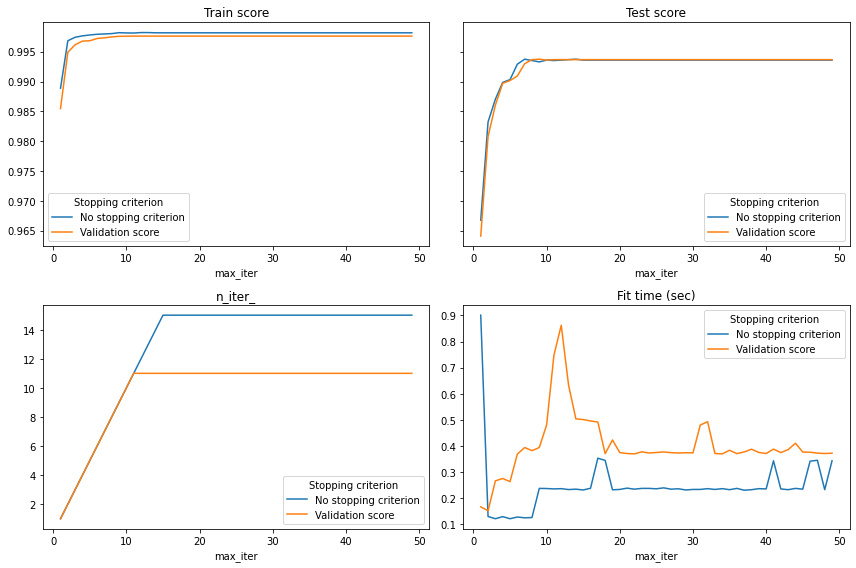

In [31]:
columns = [
    "Stopping criterion",
    "max_iter",
    "Fit time (sec)",
    "n_iter_",
    "Train score",
    "Test score",
]
results_df = pd.DataFrame(results, columns=columns)

lines = "Stopping criterion"
plot_list = [
    ("max_iter", "Train score"),
    ("max_iter", "Test score"),
    ("max_iter", "n_iter_"),
    ("max_iter", "Fit time (sec)"),
]

nrows = 2
ncols = int(np.ceil(len(plot_list) / 2.0))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
axes[0, 0].get_shared_y_axes().join(axes[0, 0], axes[0, 1])

for ax, (x_axis, y_axis) in zip(axes.ravel(), plot_list):
    for criterion, group_df in results_df.groupby(lines):
        group_df.plot(x=x_axis, y=y_axis, label=criterion, ax=ax)
    ax.set_title(y_axis)
    ax.legend(title=lines)

fig.tight_layout()
plt.show()

In [17]:
print(classification_report(y_test, y_pred))
print('\n')
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
print('\n')
print('Accuracy: \n', accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7528
           1       0.99      0.99      0.99      2998
           2       0.99      1.00      0.99      2581

    accuracy                           0.99     13107
   macro avg       0.99      0.99      0.99     13107
weighted avg       0.99      0.99      0.99     13107



Confusion Matrix: 
 [[7474   40   14]
 [   8 2978   12]
 [   6    3 2572]]


Accuracy: 
 0.993667505912871


In [94]:
recall = mt.recall_score(y_test, y_pred, average=None)
print("recall\n",recall)

recall
 [0.98034006 0.993996   0.99690043]


In [93]:
precision = mt.precision_score(y_test, y_pred, average=None)
print("precision\n",precision)

precision
 [0.9985117  0.97545008 0.96692973]


#### Threshold analysis

In [32]:
#probability estimates are not available for loss='hinge', so we have to use loss='log' to predict probability for 
#each classs.
SGD_clf_log = SGDClassifier(alpha=.1, max_iter=500, loss='log', penalty='l2',shuffle=True, n_jobs=7,
                        learning_rate='optimal',early_stopping=True, validation_fraction= .1, 
                        n_iter_no_change=10,class_weight='balanced', verbose=1, random_state=1).fit(X_train, y_train)
y_pred = SGD_clf_log.predict(X_test)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 2.56, NNZs: 46970, Bias: -0.078105, T: 47182, Avg. loss: 0.159025
Total training time: 0.02 seconds.
Norm: 1.70, NNZs: 46970, Bias: 0.023258, T: 47182, Avg. loss: 0.124772
Total training time: 0.02 seconds.
Norm: 2.44, NNZs: 46970, Bias: -0.064966, T: 47182, Avg. loss: 0.142377
Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 1.80, NNZs: 46970, Bias: -0.079750, T: 94364, Avg. loss: 0.073092
Total training time: 0.04 seconds.
Norm: 1.72, NNZs: 46970, Bias: -0.066336, T: 94364, Avg. loss: 0.070550
Total training time: 0.04 seconds.
Norm: 1.32, NNZs: 46970, Bias: 0.023309, T: 94364, Avg. loss: 0.067791
Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 1.62, NNZs: 46970, Bias: -0.080952, T: 141546, Avg. loss: 0.072498
Total training time: 0.06 seconds.
Norm: 1.56, NNZs: 46970, Bias: -0.067365, T: 141546, Avg. loss: 0.073627
Total training time: 0.06 seconds.
Norm: 1.24, NNZs: 46970, Bias: 0.023498, T: 1

[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.2s finished


In [33]:
print(classification_report(y_test, y_pred))
print('\n')
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
print('\n')
print('Accuracy: \n', accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      7528
           1       0.98      0.99      0.98      2998
           2       0.97      1.00      0.98      2581

    accuracy                           0.99     13107
   macro avg       0.98      0.99      0.99     13107
weighted avg       0.99      0.99      0.99     13107



Confusion Matrix: 
 [[7380   73   75]
 [   5 2980   13]
 [   6    2 2573]]


Accuracy: 
 0.9867246509498742


In [130]:
recall = mt.recall_score(y_test, y_pred, average=None)
print("recall\n",recall)

recall
 [0.98034006 0.993996   0.99690043]


In [92]:
precision = mt.precision_score(y_test, y_pred, average=None)
print("precision\n",precision)

precision
 [0.9985117  0.97545008 0.96692973]


In [140]:
cutoff_df = pd.DataFrame({'Actual':y_test.tolist(),'Predicted':list(SGD_clf.predict(X_test)),
                          'class_0' :list(SGD_clf_log.predict_proba(X_test)[:,0]),
                          'class_1' :list(SGD_clf_log.predict_proba(X_test)[:,1]),
                          'class_2' :list(SGD_clf_log.predict_proba(X_test)[:,2])})

In [146]:
cutoff_df.head()

Actual  Predicted   class_0   class_1   class_2
0       2          2  0.058563  0.202456  0.738981
1       2          2  0.041421  0.313363  0.645216
2       2          2  0.056357  0.094775  0.848868
3       0          0  0.755139  0.102547  0.142313
4       0          0  0.772014  0.118924  0.109062

In [147]:
def threshold_test_0(y,perc):
    if y >= perc:
        x = 0
    else:
        x= 1
    return x

In [148]:
def threshold_test_1(y,perc):
    if y >= perc:
        x = 1
    else:
        x= 0
    return x

In [149]:
def threshold_test_2(y,perc):
    if y >= perc:
        x = 2
    else:
        x= 0
    return x

### Class 0 (Allow) threshold analyze

In [150]:
precision_list = []
recall_list = []
accuracy_list = []
f1_score_list = []
threshold_list = [.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
for i in range(len(threshold_list)):
    thresh_preds = []
    for j in range(len(cutoff_df)):
        thresh_preds.append(threshold_test_0(cutoff_df[j:j+1]['class_0'].values[0],threshold_list[i]))
    recall_list.append(mt.recall_score(y_test,thresh_preds, average=None)[0])
    precision_list.append(mt.precision_score(y_test,thresh_preds, average=None)[0]) 
    accuracy_list.append(accuracy_score(y_test,thresh_preds))
    f1_score_list.append(f1_score(y_test,thresh_preds, average=None)[0])

In [151]:
cutoff_results_df = pd.DataFrame({'Threshold':threshold_list,'Accuracy':accuracy_list,'Precision' :precision_list,
                                  'Recall' :recall_list,'F1_Score':f1_score_list})

In [152]:
cutoff_results_df.head()

Threshold  Accuracy  Precision    Recall  F1_Score
0        0.1  0.789883   0.960184  0.999469  0.979432
1        0.2  0.799268   0.993001  0.998937  0.995961
2        0.3  0.796902   0.994419  0.994022  0.994220
3        0.4  0.788052   0.998503  0.974495  0.986353
4        0.5  0.779278   0.999169  0.958688  0.978510

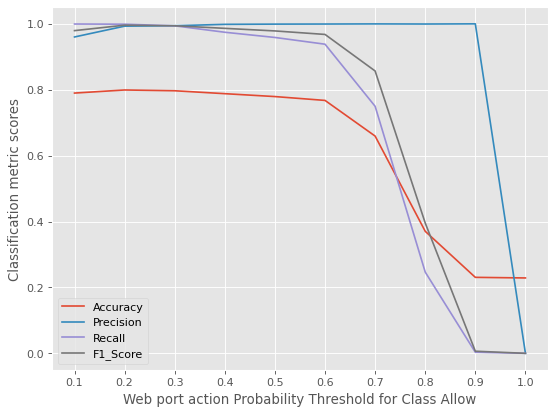

In [153]:
figure(figsize=(8, 6), dpi=80)
plt.style.use('ggplot')
plt.plot(cutoff_results_df['Accuracy'], label='Accuracy')
plt.plot(cutoff_results_df['Precision'], label='Precision')
plt.plot(cutoff_results_df['Recall'], label='Recall')
plt.plot(cutoff_results_df['F1_Score'], label='F1_Score')
plt.xticks(list(range(cutoff_results_df.shape[0])), cutoff_results_df['Threshold'])
plt.xlabel('Web port action Probability Threshold for Class Allow')
plt.ylabel('Classification metric scores')
plt.legend()
plt.show()

### Class 1 (Deny) threshold analyze

In [154]:
precision_list = []
recall_list = []
accuracy_list = []
f1_score_list = []
threshold_list = [.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
for i in range(len(threshold_list)):
    thresh_preds = []
    for j in range(len(cutoff_df)):
        thresh_preds.append(threshold_test_1(cutoff_df[j:j+1]['class_1'].values[0],threshold_list[i]))
    recall_list.append(mt.recall_score(y_test,thresh_preds, average=None)[1])
    precision_list.append(mt.precision_score(y_test,thresh_preds, average=None)[1]) 
    accuracy_list.append(accuracy_score(y_test,thresh_preds))
    f1_score_list.append(f1_score(y_test,thresh_preds, average=None)[1])

In [155]:
cutoff_results_df = pd.DataFrame({'Threshold':threshold_list,'Accuracy':accuracy_list,'Precision' :precision_list,
                                  'Recall' :recall_list,'F1_Score':f1_score_list})

In [156]:
cutoff_results_df.head()

Threshold  Accuracy  Precision    Recall  F1_Score
0        0.1  0.460288   0.299700  0.999666  0.461148
1        0.2  0.745937   0.747190  0.997665  0.854449
2        0.3  0.785840   0.908179  0.996331  0.950215
3        0.4  0.795529   0.972268  0.993996  0.983012
4        0.5  0.797589   0.991597  0.983989  0.987778

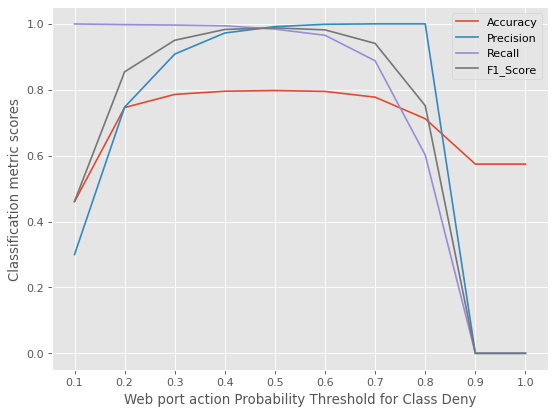

In [157]:
figure(figsize=(8, 6), dpi=80)
plt.style.use('ggplot')
plt.plot(cutoff_results_df['Accuracy'], label='Accuracy')
plt.plot(cutoff_results_df['Precision'], label='Precision')
plt.plot(cutoff_results_df['Recall'], label='Recall')
plt.plot(cutoff_results_df['F1_Score'], label='F1_Score')
plt.xticks(list(range(cutoff_results_df.shape[0])), cutoff_results_df['Threshold'])
plt.xlabel('Web port action Probability Threshold for Class Deny')
plt.ylabel('Classification metric scores')
plt.legend()
plt.show()

### Class 2 (Drop/Rest) threshold analyze

In [158]:
precision_list = []
recall_list = []
accuracy_list = []
f1_score_list = []
threshold_list = [.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
for i in range(len(threshold_list)):
    thresh_preds = []
    for j in range(len(cutoff_df)):
        thresh_preds.append(threshold_test_2(cutoff_df[j:j+1]['class_2'].values[0],threshold_list[i]))
    recall_list.append(mt.recall_score(y_test,thresh_preds, average=None)[2])
    precision_list.append(mt.precision_score(y_test,thresh_preds, average=None)[2]) 
    accuracy_list.append(accuracy_score(y_test,thresh_preds))
    f1_score_list.append(f1_score(y_test,thresh_preds, average=None)[2])

In [161]:
cutoff_results_df = pd.DataFrame({'Threshold':threshold_list,'Accuracy':accuracy_list,'Precision' :precision_list,
                                  'Recall' :recall_list,'F1_Score':f1_score_list})

In [162]:
cutoff_results_df.head()

Threshold  Accuracy  Precision    Recall  F1_Score
0        0.1  0.379644   0.255016  0.999613  0.406363
1        0.2  0.702983   0.638820  0.998450  0.779138
2        0.3  0.756390   0.904745  0.997288  0.948765
3        0.4  0.766155   0.964768  0.997288  0.980758
4        0.5  0.769741   0.990759  0.996900  0.993820

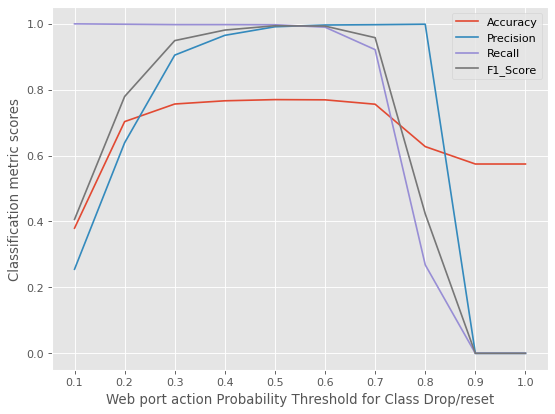

In [163]:
figure(figsize=(8, 6), dpi=80)
plt.style.use('ggplot')
plt.plot(cutoff_results_df['Accuracy'], label='Accuracy')
plt.plot(cutoff_results_df['Precision'], label='Precision')
plt.plot(cutoff_results_df['Recall'], label='Recall')
plt.plot(cutoff_results_df['F1_Score'], label='F1_Score')
plt.xticks(list(range(cutoff_results_df.shape[0])), cutoff_results_df['Threshold'])
plt.xlabel('Web port action Probability Threshold for Class Drop/reset')
plt.ylabel('Classification metric scores')
plt.legend()
plt.show()

### Feature coefficient rank

In [109]:
data_columns = pd.get_dummies(port_log.drop(['Action'], axis=1).copy(), 
                              columns = ['Source Port', 'Destination Port','NAT Source Port', 'NAT Destination Port'], 
                              sparse=True)

In [115]:
SGD_clf.coef_.shape

(3, 57689)

In [110]:
#Class 0 allow coefficient feature rank
var_list = []
coeff_list = []
for i in range(len(data_columns.columns)):
    print(data_columns.columns[i], abs(SGD_clf.coef_[0][i]))
    var_list.append(data_columns.columns[i])
    coeff_list.append(abs(SGD_clf.coef_[0][i])) 

Bytes 0.002047613640135387
Bytes Sent 0.0001518328155895509
Bytes Received 0.004434524552712678
Packets 0.0025707731061708054
Elapsed Time (sec) 0.06095311776969009
pkts_sent 0.0013844964119867193
pkts_received 0.003930707410929927
Source Port_0 0.005601494971078381
Source Port_5 0.0
Source Port_20 0.002024058326386615
Source Port_22 0.004293741628111839
Source Port_25 0.0020240583263866235
Source Port_50 0.0017439552151530936
Source Port_67 0.0034877507481633633
Source Port_68 0.0
Source Port_80 0.005703041030584121
Source Port_123 0.0063833400325388435
Source Port_137 0.0028624944187412085
Source Port_346 0.0
Source Port_443 0.013424146006889931
Source Port_515 0.0
Source Port_542 0.0
Source Port_723 0.0
Source Port_736 0.0
Source Port_993 0.003688283564351054
Source Port_1024 0.0018086718929026969
Source Port_1025 0.0018646511435765703
Source Port_1026 0.0
Source Port_1027 0.0
Source Port_1028 0.0
Source Port_1029 0.0
Source Port_1030 0.0
Source Port_1033 0.0
Source Port_1034 0.0
So

Source Port_13663 0.0
Source Port_13684 0.0
Source Port_13699 0.0
Source Port_13718 0.0
Source Port_13727 0.004932386775802901
Source Port_13743 0.000560365904609895
Source Port_13747 0.0
Source Port_13749 0.0028624288956944784
Source Port_13794 0.0
Source Port_13795 0.0
Source Port_13825 0.0
Source Port_13826 0.0020240583263866274
Source Port_13840 0.0
Source Port_13859 0.0028624288956945834
Source Port_13864 0.0049323867758029
Source Port_13868 0.0
Source Port_13871 0.002862428895694598
Source Port_13907 0.0
Source Port_13911 0.0
Source Port_13917 0.0028477582897472554
Source Port_13938 0.0
Source Port_13943 0.0
Source Port_13947 0.0
Source Port_13956 0.002862428895694588
Source Port_13963 0.0
Source Port_13968 0.004932386775802891
Source Port_13970 0.0028477582897471643
Source Port_13971 0.0028624288956946528
Source Port_13973 0.0
Source Port_13980 0.0
Source Port_13985 0.0028477582897472402
Source Port_13996 0.0
Source Port_14000 0.0
Source Port_14023 0.0
Source Port_14032 0.0
Sour

Source Port_32959 0.0
Source Port_32961 0.0
Source Port_32962 0.00286242889569453
Source Port_32966 0.0
Source Port_32967 0.002024058326386649
Source Port_32968 0.0
Source Port_32970 0.0014636924217767318
Source Port_32971 0.0016526493130091676
Source Port_32974 0.0
Source Port_32975 0.0
Source Port_32976 0.0
Source Port_32983 0.0
Source Port_32996 0.002862428895694528
Source Port_32997 0.0
Source Port_33000 0.005724857791389136
Source Port_33003 0.0
Source Port_33006 0.0
Source Port_33008 0.0028624288956946562
Source Port_33012 0.0
Source Port_33013 0.0
Source Port_33017 0.0020240583263865463
Source Port_33022 0.0
Source Port_33027 0.008096233305546412
Source Port_33028 0.0028624288956946003
Source Port_33038 0.0028624288956946155
Source Port_33040 0.0028624288956946207
Source Port_33041 0.0028624288956946267
Source Port_33042 0.0020240583263866113
Source Port_33043 0.0020240583263866564
Source Port_33044 0.002024058326386614
Source Port_33045 0.0028624288956946614
Source Port_33047 0

Source Port_39232 0.002862428895694588
Source Port_39233 0.0028624288956945135
Source Port_39236 0.002862428895694527
Source Port_39244 0.0
Source Port_39251 0.0028624288956946016
Source Port_39252 0.002862428895694593
Source Port_39265 0.0028624288956944823
Source Port_39267 0.0
Source Port_39268 0.0028624288956945305
Source Port_39272 0.002862428895694554
Source Port_39277 0.0028624288956944845
Source Port_39287 0.0011951089767379942
Source Port_39292 0.0028624288956945712
Source Port_39293 0.0028624288956945543
Source Port_39296 0.0
Source Port_39297 0.0
Source Port_39303 0.0028624288956945612
Source Port_39310 0.0028624288956946133
Source Port_39311 0.002862428895694541
Source Port_39312 0.002862428895694499
Source Port_39313 0.0
Source Port_39317 0.002862428895694586
Source Port_39318 0.0
Source Port_39322 0.0
Source Port_39323 0.0
Source Port_39324 0.0
Source Port_39325 0.0028624288956945773
Source Port_39326 0.0028624288956944754
Source Port_39328 0.001652649313009196
Source Por

Source Port_45846 0.002024058326386643
Source Port_45847 0.002862428895694615
Source Port_45852 0.0020240583263866543
Source Port_45855 0.0
Source Port_45859 0.0
Source Port_45860 0.002862428895694638
Source Port_45862 0.002862428895694524
Source Port_45863 0.002862428895694615
Source Port_45871 0.0028624288956945318
Source Port_45872 0.002862428895694541
Source Port_45882 0.0
Source Port_45885 0.0028624288956944845
Source Port_45886 0.0028624288956944927
Source Port_45891 0.002862428895694611
Source Port_45896 0.002024058326386632
Source Port_45897 0.0
Source Port_45898 0.0028624288956944823
Source Port_45899 0.0
Source Port_45900 0.0
Source Port_45908 0.0028518032521398545
Source Port_45912 0.0
Source Port_45913 0.002862428895694596
Source Port_45918 0.0028624288956946155
Source Port_45926 0.002862428895694534
Source Port_45932 0.0028624288956945135
Source Port_45935 0.0028624288956946077
Source Port_45937 0.0020240583263866664
Source Port_45939 0.0020240583263866794
Source Port_4594

Source Port_50152 0.0011951089767380622
Source Port_50153 0.002024058326386652
Source Port_50154 0.0
Source Port_50156 0.0003544146290763285
Source Port_50158 0.0028624288956945786
Source Port_50159 0.0010350026314630563
Source Port_50160 0.0
Source Port_50161 0.00045754033627119496
Source Port_50162 0.0
Source Port_50163 0.0
Source Port_50164 0.001431247209370597
Source Port_50165 0.0016526493130091858
Source Port_50166 0.002024058326386679
Source Port_50167 0.0014636924217767062
Source Port_50168 0.0
Source Port_50169 0.000782406358579823
Source Port_50170 0.0
Source Port_50171 0.0005603659046098347
Source Port_50172 0.0011686262870485367
Source Port_50174 0.0
Source Port_50175 0.0020240583263866473
Source Port_50176 0.001195108976737999
Source Port_50177 0.0
Source Port_50178 0.001280156189150122
Source Port_50179 0.0011951089767379922
Source Port_50180 0.0011951089767380139
Source Port_50181 0.0
Source Port_50182 0.0011951089767380093
Source Port_50183 0.0
Source Port_50184 0.0
Sou

Source Port_52278 0.0011951089767380367
Source Port_52280 0.00048286675560371375
Source Port_52281 0.005724857791389068
Source Port_52282 0.0009257415600738186
Source Port_52283 0.0
Source Port_52285 0.0028624288956945864
Source Port_52286 0.0
Source Port_52287 0.0
Source Port_52288 0.0020240583263866855
Source Port_52291 0.0
Source Port_52292 0.0
Source Port_52294 0.0
Source Port_52295 0.002862428895694624
Source Port_52296 0.0
Source Port_52297 0.0020240583263866534
Source Port_52298 0.0
Source Port_52303 0.0
Source Port_52304 0.0
Source Port_52305 0.0
Source Port_52306 0.0
Source Port_52307 0.0
Source Port_52308 0.002024058326386657
Source Port_52309 0.0
Source Port_52310 0.008096233305546511
Source Port_52311 0.0
Source Port_52312 0.0020240583263866734
Source Port_52313 0.0014312472093706546
Source Port_52314 0.0005603659046098304
Source Port_52315 0.0014636924217766374
Source Port_52317 0.0
Source Port_52318 0.0009257415600738444
Source Port_52319 0.0005603659046099259
Source Port

Source Port_54559 0.0
Source Port_54560 0.0005603659046099107
Source Port_54563 0.0
Source Port_54564 0.0
Source Port_54566 0.0
Source Port_54567 0.0
Source Port_54569 0.0
Source Port_54570 0.0
Source Port_54571 0.0
Source Port_54572 0.0
Source Port_54573 0.0011951089767380494
Source Port_54575 0.0
Source Port_54576 0.0028624288956945057
Source Port_54577 0.0
Source Port_54578 0.0
Source Port_54579 0.0
Source Port_54580 0.0
Source Port_54582 0.0
Source Port_54583 0.0016526493130091676
Source Port_54586 0.008263246565045913
Source Port_54587 0.008096233305546567
Source Port_54588 0.0
Source Port_54590 0.00202405832638658
Source Port_54592 0.0
Source Port_54593 0.0
Source Port_54594 0.0
Source Port_54595 0.0028624288956944806
Source Port_54596 0.002862428895694523
Source Port_54598 0.0
Source Port_54599 0.002862428895694605
Source Port_54600 0.002466249840833595
Source Port_54601 0.0
Source Port_54602 0.0
Source Port_54604 0.0
Source Port_54605 0.0
Source Port_54606 0.0
Source Port_54610

Source Port_56983 0.00039624457790755544
Source Port_56984 0.002337252574097049
Source Port_56985 0.0011686262870485601
Source Port_56986 0.0019651985215556732
Source Port_56987 0.0021638919231119166
Source Port_56988 0.00143124720937059
Source Port_56989 0.0016526493130092279
Source Port_56990 0.0
Source Port_56991 0.0011686262870485556
Source Port_56992 0.0020240583263866742
Source Port_56993 0.00039624457790759013
Source Port_56994 0.001168626287048559
Source Port_56995 0.00202415099527099
Source Port_56996 0.0003962445779075985
Source Port_56997 0.0020241509952710047
Source Port_56998 0.0020241509952710016
Source Port_56999 0.0011951089767380716
Source Port_57000 0.0002995396029761777
Source Port_57001 0.0019084024225459193
Source Port_57002 0.0012801561891501389
Source Port_57003 0.002024058326386677
Source Port_57004 0.001652649313009192
Source Port_57005 0.000396244577907559
Source Port_57006 0.0016526493130092168
Source Port_57007 0.0017262412870305381
Source Port_57008 0.00143

Source Port_59346 0.0
Source Port_59347 0.0009257415600738213
Source Port_59350 0.0
Source Port_59352 0.001035002631462999
Source Port_59353 0.0
Source Port_59355 0.0
Source Port_59356 0.0
Source Port_59357 0.0
Source Port_59358 0.0
Source Port_59360 0.0
Source Port_59361 0.0
Source Port_59363 0.0028624288956945196
Source Port_59364 0.0
Source Port_59365 0.0028477582897471873
Source Port_59366 0.0
Source Port_59368 0.0028624288956945808
Source Port_59370 0.0
Source Port_59371 0.00202405832638665
Source Port_59373 0.0
Source Port_59374 0.0
Source Port_59375 0.0
Source Port_59376 0.004932386775802948
Source Port_59377 0.0008450890065483614
Source Port_59378 0.0
Source Port_59379 0.0028624288956945803
Source Port_59381 0.0020240583263866035
Source Port_59382 0.0
Source Port_59383 0.0
Source Port_59384 0.0
Source Port_59386 0.0
Source Port_59389 0.0
Source Port_59390 0.0014636924217766097
Source Port_59392 0.0
Source Port_59393 0.0
Source Port_59394 0.0014636924217767413
Source Port_59395 

Source Port_62064 0.0009257415600738285
Source Port_62065 0.0028624288956945925
Source Port_62066 0.002024058326386674
Source Port_62067 0.001195108976738041
Source Port_62068 0.0009257415600738239
Source Port_62069 0.0
Source Port_62071 0.0
Source Port_62072 0.002862428895694627
Source Port_62073 0.002024058326386681
Source Port_62074 0.0004575403362711382
Source Port_62075 0.00165264931300924
Source Port_62076 0.002862428895694609
Source Port_62077 0.0014636924217767138
Source Port_62079 0.0
Source Port_62080 0.0009257415600738203
Source Port_62081 0.001463692421776703
Source Port_62082 0.002024058326386677
Source Port_62084 0.0
Source Port_62085 0.0
Source Port_62086 0.0
Source Port_62088 0.0
Source Port_62089 0.0022058977492238584
Source Port_62092 0.0
Source Port_62096 0.0
Source Port_62097 0.0
Source Port_62099 0.0
Source Port_62101 0.0011951089767379807
Source Port_62102 0.0016526493130091585
Source Port_62103 0.0011951089767379775
Source Port_62104 0.0
Source Port_62105 0.0
Sou

Source Port_64837 0.0011686262870485573
Source Port_64838 0.0016526493130091678
Source Port_64839 0.0014312472093706574
Source Port_64840 0.00039624457790758964
Source Port_64841 0.002070005262926107
Source Port_64842 0.0016526493130092034
Source Port_64843 0.0020240583263866556
Source Port_64844 0.0014636924217767099
Source Port_64845 0.0005603659046100066
Source Port_64846 0.0
Source Port_64847 0.0009257415600737778
Source Port_64849 0.0020240583263866365
Source Port_64850 0.0019084024225458883
Source Port_64852 0.0020240583263866677
Source Port_64853 0.002163891923111902
Source Port_64854 0.0011686262870485604
Source Port_64856 0.0
Source Port_64857 0.0
Source Port_64858 0.0012801561891501298
Source Port_64859 0.008096233305546542
Source Port_64860 0.0
Source Port_64862 0.0021638919231118923
Source Port_64863 0.0
Source Port_64864 0.0028624288956946397
Source Port_64865 0.002024058326386657
Source Port_64867 0.0011951089767380091
Source Port_64868 0.0
Source Port_64869 0.00045754033

Destination Port_32300 0.0028624288956945166
Destination Port_32305 0.0020240583263866243
Destination Port_32329 0.0
Destination Port_32330 0.004048116652773231
Destination Port_32332 0.0
Destination Port_32348 0.0028624288956945717
Destination Port_32405 0.0028624288956946367
Destination Port_32463 0.002024058326386647
Destination Port_32468 0.004933290239875764
Destination Port_32480 0.005460776979625053
Destination Port_32517 0.0028624288956945665
Destination Port_32520 0.0
Destination Port_32554 0.002862428895694509
Destination Port_32661 0.002205897749223929
Destination Port_32678 0.00202405832638662
Destination Port_32698 0.0028477582897471127
Destination Port_32737 0.0
Destination Port_32753 0.0
Destination Port_32761 0.004932386775802917
Destination Port_32765 0.002024058326386607
Destination Port_32787 0.0042937416281118015
Destination Port_32794 0.0028624288956945214
Destination Port_32805 0.0020240583263866083
Destination Port_32808 0.0
Destination Port_32834 0.0020240583263

NAT Source Port_2264 0.002862428895694586
NAT Source Port_2265 0.0028624288956946246
NAT Source Port_2278 0.002024058326386631
NAT Source Port_2286 0.002862428895694505
NAT Source Port_2287 0.0028624288956945396
NAT Source Port_2288 0.002024058326386651
NAT Source Port_2292 0.0020240583263866022
NAT Source Port_2296 0.002862428895694618
NAT Source Port_2297 0.0
NAT Source Port_2298 0.0020240583263866083
NAT Source Port_2299 0.0
NAT Source Port_2301 0.0
NAT Source Port_2303 0.0
NAT Source Port_2305 0.0
NAT Source Port_2306 0.0
NAT Source Port_2309 0.0028624288956946133
NAT Source Port_2311 0.0
NAT Source Port_2313 0.002862428895694528
NAT Source Port_2314 0.00286242889569453
NAT Source Port_2318 0.0
NAT Source Port_2321 0.0028624288956945266
NAT Source Port_2324 0.0028624288956945257
NAT Source Port_2330 0.002862428895694603
NAT Source Port_2331 0.0028624288956944906
NAT Source Port_2332 0.0
NAT Source Port_2333 0.0028624288956946454
NAT Source Port_2334 0.0028624288956945816
NAT Source

NAT Source Port_7442 0.0028624288956944836
NAT Source Port_7443 0.002862428895694602
NAT Source Port_7446 0.002024058326386646
NAT Source Port_7447 0.002862428895694565
NAT Source Port_7448 0.002862428895694542
NAT Source Port_7454 0.0
NAT Source Port_7460 0.002862428895694508
NAT Source Port_7462 0.0
NAT Source Port_7465 0.002862428895694649
NAT Source Port_7467 0.0028624288956945187
NAT Source Port_7469 0.0
NAT Source Port_7470 0.0
NAT Source Port_7471 0.0020240583263866174
NAT Source Port_7473 0.0028624288956945604
NAT Source Port_7474 0.0028624288956944884
NAT Source Port_7475 0.0
NAT Source Port_7477 0.0
NAT Source Port_7478 0.002024058326386666
NAT Source Port_7479 0.002862428895694559
NAT Source Port_7480 0.002024058326386641
NAT Source Port_7483 0.0
NAT Source Port_7486 0.0
NAT Source Port_7487 0.0
NAT Source Port_7488 0.0028624288956945227
NAT Source Port_7490 0.002024058326386613
NAT Source Port_7493 0.002862428895694612
NAT Source Port_7495 0.002024058326386609
NAT Source Po

NAT Source Port_12273 0.0028624288956945756
NAT Source Port_12282 0.0
NAT Source Port_12285 0.002862428895694623
NAT Source Port_12286 0.0020240583263866183
NAT Source Port_12288 0.002862428895694586
NAT Source Port_12289 0.0028624288956945634
NAT Source Port_12290 0.0
NAT Source Port_12291 0.0
NAT Source Port_12292 0.0
NAT Source Port_12296 0.0
NAT Source Port_12299 0.0020240583263865814
NAT Source Port_12301 0.002024058326386623
NAT Source Port_12302 0.0
NAT Source Port_12303 0.0028624288956945578
NAT Source Port_12304 0.0
NAT Source Port_12306 0.0028624288956946033
NAT Source Port_12307 0.002862428895694523
NAT Source Port_12310 0.0028624288956945543
NAT Source Port_12315 0.0
NAT Source Port_12316 0.0028624288956945907
NAT Source Port_12317 0.0028624288956946363
NAT Source Port_12321 0.002862428895694532
NAT Source Port_12322 0.0
NAT Source Port_12323 0.00286242889569459
NAT Source Port_12324 0.0
NAT Source Port_12325 0.0028624288956945972
NAT Source Port_12327 0.0
NAT Source Port_1

NAT Source Port_17125 0.0020240583263866126
NAT Source Port_17127 0.0028624288956945305
NAT Source Port_17128 0.0028624288956946363
NAT Source Port_17131 0.0
NAT Source Port_17140 0.0033052986260183647
NAT Source Port_17141 0.002862428895694572
NAT Source Port_17149 0.0028624288956945157
NAT Source Port_17150 0.0
NAT Source Port_17152 0.0
NAT Source Port_17154 0.0
NAT Source Port_17156 0.0028624288956946506
NAT Source Port_17159 0.0
NAT Source Port_17161 0.0
NAT Source Port_17164 0.002862428895694638
NAT Source Port_17167 0.0016526493130091685
NAT Source Port_17169 0.0028624288956946024
NAT Source Port_17170 0.0
NAT Source Port_17171 0.002862428895694585
NAT Source Port_17176 0.002024058326386608
NAT Source Port_17178 0.0
NAT Source Port_17179 0.0028624288956945122
NAT Source Port_17182 0.0028624288956946163
NAT Source Port_17184 0.0
NAT Source Port_17186 0.0
NAT Source Port_17189 0.0
NAT Source Port_17194 0.0016526493130092001
NAT Source Port_17196 0.0028624288956945387
NAT Source Por

NAT Source Port_22365 0.0
NAT Source Port_22367 0.0
NAT Source Port_22368 0.003305298626018343
NAT Source Port_22369 0.0028624288956945135
NAT Source Port_22372 0.002862428895694569
NAT Source Port_22373 0.0020240583263866525
NAT Source Port_22374 0.0028624288956946168
NAT Source Port_22375 0.002862428895694493
NAT Source Port_22376 0.0
NAT Source Port_22379 0.0
NAT Source Port_22380 0.0
NAT Source Port_22382 0.0
NAT Source Port_22385 0.002862428895694576
NAT Source Port_22387 0.0
NAT Source Port_22388 0.0
NAT Source Port_22389 0.001652649313009186
NAT Source Port_22392 0.0028624288956945903
NAT Source Port_22394 0.0028624288956946454
NAT Source Port_22401 0.0028624288956946467
NAT Source Port_22403 0.0028624288956945365
NAT Source Port_22404 0.0
NAT Source Port_22406 0.0028624288956945135
NAT Source Port_22407 0.0028624288956946237
NAT Source Port_22408 0.0028624288956945135
NAT Source Port_22410 0.0
NAT Source Port_22414 0.0028624288956945287
NAT Source Port_22415 0.00286242889569459

NAT Source Port_27237 0.002024058326386613
NAT Source Port_27238 0.0020240583263866664
NAT Source Port_27240 0.002862428895694588
NAT Source Port_27241 0.0028624288956946107
NAT Source Port_27244 0.0
NAT Source Port_27246 0.002024058326386617
NAT Source Port_27250 0.0028624288956945057
NAT Source Port_27251 0.0028624288956945196
NAT Source Port_27254 0.0
NAT Source Port_27256 0.0028624288956946146
NAT Source Port_27260 0.0
NAT Source Port_27261 0.002862428895694577
NAT Source Port_27262 0.0
NAT Source Port_27266 0.0
NAT Source Port_27268 0.0
NAT Source Port_27269 0.0028624288956945075
NAT Source Port_27272 0.0
NAT Source Port_27275 0.002862428895694555
NAT Source Port_27276 0.0028624288956945938
NAT Source Port_27278 0.0
NAT Source Port_27279 0.0020240583263866885
NAT Source Port_27284 0.0
NAT Source Port_27285 0.0020240583263866716
NAT Source Port_27288 0.002024058326386675
NAT Source Port_27290 0.0028624288956945482
NAT Source Port_27291 0.0
NAT Source Port_27292 0.0
NAT Source Port_

NAT Source Port_31854 0.0
NAT Source Port_31855 0.0
NAT Source Port_31858 0.0
NAT Source Port_31863 0.002862428895694525
NAT Source Port_31864 0.002862428895694585
NAT Source Port_31867 0.002024058326386602
NAT Source Port_31869 0.0028624288956945994
NAT Source Port_31870 0.0
NAT Source Port_31871 0.0
NAT Source Port_31872 0.0020240583263866096
NAT Source Port_31873 0.0
NAT Source Port_31877 0.0
NAT Source Port_31879 0.0028624288956945547
NAT Source Port_31881 0.002862428895694611
NAT Source Port_31884 0.002862428895694577
NAT Source Port_31886 0.002862428895694553
NAT Source Port_31890 0.002862428895694624
NAT Source Port_31892 0.002024058326386641
NAT Source Port_31893 0.0028624288956945244
NAT Source Port_31894 0.0
NAT Source Port_31898 0.002024058326386656
NAT Source Port_31899 0.0
NAT Source Port_31901 0.002862428895694584
NAT Source Port_31902 0.0020240583263865853
NAT Source Port_31906 0.00286242889569453
NAT Source Port_31908 0.002862428895694515
NAT Source Port_31909 0.0
NAT S

NAT Source Port_36788 0.0
NAT Source Port_36790 0.002862428895694605
NAT Source Port_36793 0.00286242889569452
NAT Source Port_36796 0.002024058326386613
NAT Source Port_36797 0.0028624288956945907
NAT Source Port_36798 0.0
NAT Source Port_36799 0.0
NAT Source Port_36803 0.0
NAT Source Port_36804 0.0016526493130091643
NAT Source Port_36806 0.0040481166527732764
NAT Source Port_36807 0.0028624288956946246
NAT Source Port_36811 0.0
NAT Source Port_36812 0.0
NAT Source Port_36813 0.0028624288956945777
NAT Source Port_36814 0.002862428895694581
NAT Source Port_36816 0.0033052986260183066
NAT Source Port_36818 0.0028624288956945257
NAT Source Port_36819 0.0
NAT Source Port_36823 0.0
NAT Source Port_36824 0.0
NAT Source Port_36831 0.0020240583263865983
NAT Source Port_36835 0.0020240583263866235
NAT Source Port_36838 0.0028624288956944793
NAT Source Port_36839 0.0
NAT Source Port_36841 0.002862428895694638
NAT Source Port_36842 0.0
NAT Source Port_36843 0.0
NAT Source Port_36844 0.0
NAT Sour

NAT Source Port_41175 0.002862428895694593
NAT Source Port_41177 0.002862428895694578
NAT Source Port_41182 0.0028624288956945417
NAT Source Port_41184 0.0028624288956945105
NAT Source Port_41185 0.0
NAT Source Port_41186 0.0
NAT Source Port_41187 0.0
NAT Source Port_41188 0.002862428895694581
NAT Source Port_41190 0.0
NAT Source Port_41191 0.002024058326386598
NAT Source Port_41193 0.0
NAT Source Port_41194 0.0
NAT Source Port_41205 0.0
NAT Source Port_41208 0.0
NAT Source Port_41213 0.0
NAT Source Port_41215 0.0028624288956944992
NAT Source Port_41217 0.0028624288956945227
NAT Source Port_41219 0.0028624288956946293
NAT Source Port_41220 0.0020240583263866348
NAT Source Port_41226 0.002024058326386621
NAT Source Port_41227 0.0
NAT Source Port_41228 0.0020240583263866096
NAT Source Port_41230 0.0
NAT Source Port_41233 0.0
NAT Source Port_41234 0.0028624288956945326
NAT Source Port_41237 0.0020240583263866174
NAT Source Port_41244 0.0028624288956945712
NAT Source Port_41245 0.002862428

NAT Source Port_45683 0.002862428895694523
NAT Source Port_45684 0.0028624288956946285
NAT Source Port_45686 0.0
NAT Source Port_45688 0.0
NAT Source Port_45689 0.0028624288956945157
NAT Source Port_45691 0.0028624288956945925
NAT Source Port_45692 0.0028624288956945938
NAT Source Port_45693 0.002862428895694593
NAT Source Port_45700 0.0
NAT Source Port_45704 0.0
NAT Source Port_45707 0.0
NAT Source Port_45708 0.0
NAT Source Port_45709 0.0028624288956946064
NAT Source Port_45710 0.0020240583263866135
NAT Source Port_45711 0.001652649313009213
NAT Source Port_45713 0.0
NAT Source Port_45715 0.002024058326386645
NAT Source Port_45716 0.002862428895694603
NAT Source Port_45717 0.0028624288956945227
NAT Source Port_45720 0.0028624288956944854
NAT Source Port_45721 0.001431247209370594
NAT Source Port_45722 0.0
NAT Source Port_45723 0.0028624288956945543
NAT Source Port_45725 0.0028624288956945933
NAT Source Port_45728 0.0
NAT Source Port_45731 0.0
NAT Source Port_45739 0.002862428895694512

NAT Source Port_50584 0.0
NAT Source Port_50585 0.0
NAT Source Port_50586 0.002024058326386618
NAT Source Port_50587 0.002024058326386599
NAT Source Port_50588 0.002862428895694602
NAT Source Port_50589 0.0
NAT Source Port_50592 0.002862428895694523
NAT Source Port_50594 0.0016526493130091685
NAT Source Port_50597 0.0
NAT Source Port_50598 0.0028624288956946267
NAT Source Port_50599 0.0028624288956945847
NAT Source Port_50600 0.001431247209370599
NAT Source Port_50601 0.0020240583263866465
NAT Source Port_50602 0.003305298626018388
NAT Source Port_50603 0.0
NAT Source Port_50604 0.001652649313009158
NAT Source Port_50605 0.0
NAT Source Port_50606 0.0028624288956945383
NAT Source Port_50607 0.002862428895694561
NAT Source Port_50611 0.0
NAT Source Port_50613 0.00286242889569463
NAT Source Port_50615 0.0
NAT Source Port_50616 0.0028624288956944906
NAT Source Port_50617 0.002024058326386602
NAT Source Port_50618 0.0
NAT Source Port_50619 0.0028624288956945955
NAT Source Port_50623 0.0
NAT

NAT Source Port_54801 0.0
NAT Source Port_54803 0.0028624288956945847
NAT Source Port_54804 0.002862428895694663
NAT Source Port_54809 0.0
NAT Source Port_54810 0.0
NAT Source Port_54812 0.002024058326386599
NAT Source Port_54813 0.0028624288956946185
NAT Source Port_54814 0.0
NAT Source Port_54815 0.0033052986260183803
NAT Source Port_54816 0.0028624288956945873
NAT Source Port_54817 0.0028624288956945205
NAT Source Port_54818 0.002862428895694573
NAT Source Port_54819 0.002862428895694508
NAT Source Port_54820 0.002862428895694445
NAT Source Port_54821 0.0
NAT Source Port_54824 0.0016526493130091721
NAT Source Port_54826 0.0028624288956945842
NAT Source Port_54828 0.0016526493130091678
NAT Source Port_54830 0.0
NAT Source Port_54833 0.0020240583263866543
NAT Source Port_54837 0.0028624288956946
NAT Source Port_54838 0.0
NAT Source Port_54840 0.0020240583263866404
NAT Source Port_54842 0.0
NAT Source Port_54848 0.0028624288956946215
NAT Source Port_54849 0.002862428895694522
NAT Sourc

NAT Source Port_59313 0.0028624288956945417
NAT Source Port_59315 0.0
NAT Source Port_59316 0.002862428895694467
NAT Source Port_59317 0.0
NAT Source Port_59322 0.0
NAT Source Port_59326 0.0
NAT Source Port_59328 0.002862428895694608
NAT Source Port_59332 0.0
NAT Source Port_59334 0.0
NAT Source Port_59335 0.0028624288956945756
NAT Source Port_59336 0.002024058326386674
NAT Source Port_59337 0.0028624288956944238
NAT Source Port_59339 0.0
NAT Source Port_59340 0.0033052986260183655
NAT Source Port_59342 0.0
NAT Source Port_59343 0.0028624288956944992
NAT Source Port_59346 0.0028624288956945205
NAT Source Port_59347 0.0028624288956946016
NAT Source Port_59350 0.0020240583263866577
NAT Source Port_59351 0.0028624288956946168
NAT Source Port_59352 0.0028624288956945413
NAT Source Port_59355 0.0
NAT Source Port_59356 0.0028624288956945994
NAT Source Port_59357 0.0016526493130091756
NAT Source Port_59359 0.0
NAT Source Port_59362 0.002024058326386686
NAT Source Port_59363 0.0020240583263866

NAT Source Port_64064 0.0
NAT Source Port_64068 0.0
NAT Source Port_64070 0.0
NAT Source Port_64071 0.002862428895694586
NAT Source Port_64072 0.002862428895694596
NAT Source Port_64074 0.0
NAT Source Port_64075 0.0
NAT Source Port_64076 0.002862428895694531
NAT Source Port_64078 0.0020240583263866517
NAT Source Port_64079 0.0
NAT Source Port_64082 0.0028624288956945573
NAT Source Port_64084 0.0
NAT Source Port_64085 0.0
NAT Source Port_64086 0.0
NAT Source Port_64087 0.003305298626018453
NAT Source Port_64090 0.0
NAT Source Port_64091 0.0
NAT Source Port_64092 0.0020240583263866447
NAT Source Port_64093 0.0016526493130091995
NAT Source Port_64094 0.002024058326386677
NAT Source Port_64095 0.0
NAT Source Port_64096 0.0
NAT Source Port_64097 0.002024058326386655
NAT Source Port_64098 0.0
NAT Source Port_64099 0.002024058326386655
NAT Source Port_64105 0.0028624288956945777
NAT Source Port_64106 0.002862428895694574
NAT Source Port_64109 0.0028624288956945877
NAT Source Port_64110 0.0
NA

NAT Destination Port_37083 0.0
NAT Destination Port_37092 0.0
NAT Destination Port_37096 0.004293741628111837
NAT Destination Port_37105 0.002862428895694541
NAT Destination Port_37168 0.004048116652773223
NAT Destination Port_37178 0.0028624288956945205
NAT Destination Port_37224 0.00286242889569455
NAT Destination Port_37232 0.002862428895694574
NAT Destination Port_37237 0.0028624288956945214
NAT Destination Port_37241 0.002862428895694539
NAT Destination Port_37264 0.0020240583263866053
NAT Destination Port_37267 0.0020240583263866157
NAT Destination Port_37273 0.002024058326386618
NAT Destination Port_37321 0.0028624288956945257
NAT Destination Port_37372 0.0
NAT Destination Port_37395 0.002862428895694605
NAT Destination Port_37398 0.0028624288956945318
NAT Destination Port_37449 0.002862428895694614
NAT Destination Port_37469 0.002862428895694525
NAT Destination Port_37512 0.002862428895694594
NAT Destination Port_37529 0.004048116652773214
NAT Destination Port_37553 0.004048116

In [111]:
df_feature = pd.DataFrame({'Features':var_list, 'ABS_coef':coeff_list})
df_feature.sort_values(by='ABS_coef', ascending=False).head(15)

Features  ABS_coef
55156    NAT Destination Port_0  0.205887
26004         NAT Source Port_0  0.205887
22741       Destination Port_53  0.193280
55172  NAT Destination Port_443  0.160357
22757      Destination Port_443  0.159469
55165   NAT Destination Port_53  0.158518
22759      Destination Port_445  0.157771
55167   NAT Destination Port_80  0.097671
22746       Destination Port_80  0.096230
4            Elapsed Time (sec)  0.060953
539            Source Port_5588  0.031937
22978     Destination Port_5588  0.031937
23878    Destination Port_25174  0.027155
2751          Source Port_27005  0.026771
23748    Destination Port_22114  0.026693

In [116]:
#Class 1 deny coefficient feature rank
var_list = []
coeff_list = []
for i in range(len(data_columns.columns)):
    print(data_columns.columns[i], abs(SGD_clf.coef_[1][i]))
    var_list.append(data_columns.columns[i])
    coeff_list.append(abs(SGD_clf.coef_[1][i])) 

Bytes 0.0013200781228648666
Bytes Sent 0.00013648059035808012
Bytes Received 0.002798916076925466
Packets 0.0019134641123570318
Elapsed Time (sec) 0.06450232350068887
pkts_sent 0.001166982965139599
pkts_received 0.0027280887772269777
Source Port_0 0.019543619961061402
Source Port_5 0.007189378505893388
Source Port_20 0.0034877507481633264
Source Port_22 0.004932499681667178
Source Port_25 0.0034877507481632917
Source Port_50 0.0025419649165735777
Source Port_67 0.005083697082671914
Source Port_68 0.0023966057947995053
Source Port_80 0.01657148178611272
Source Port_123 0.005922772952211563
Source Port_137 0.0024662498408336013
Source Port_346 0.0
Source Port_443 0.040611252217643584
Source Port_515 0.0035947715379570635
Source Port_542 0.0
Source Port_723 0.0
Source Port_736 0.0
Source Port_993 0.012582802885762284
Source Port_1024 0.006703103881564927
Source Port_1025 0.005435779253315566
Source Port_1026 0.00454727447904129
Source Port_1027 0.003595100734514882
Source Port_1028 0.0050

Source Port_16862 0.0
Source Port_16883 0.0
Source Port_16905 0.0
Source Port_16944 0.0
Source Port_16948 0.007189543075914185
Source Port_16965 0.004932386775802701
Source Port_16979 0.0
Source Port_16980 0.004932386775802746
Source Port_16985 0.0
Source Port_16994 0.0007083720970706916
Source Port_17002 0.0
Source Port_17004 0.0
Source Port_17008 0.0
Source Port_17009 0.0
Source Port_17010 0.0
Source Port_17018 0.0
Source Port_17027 0.004150852957989153
Source Port_17038 0.0
Source Port_17046 0.0
Source Port_17052 0.004932386775802627
Source Port_17070 0.0
Source Port_17097 0.0
Source Port_17101 0.0
Source Port_17119 0.004932386775802758
Source Port_17129 0.004932386775802801
Source Port_17146 0.0
Source Port_17171 0.0
Source Port_17173 0.0
Source Port_17176 0.004932386775802796
Source Port_17177 0.0
Source Port_17205 0.007189378505893387
Source Port_17206 0.004932386775802906
Source Port_17213 0.0
Source Port_17226 0.0
Source Port_17230 0.0
Source Port_17232 0.0
Source Port_17244 0.

Source Port_33939 0.0
Source Port_33941 0.0
Source Port_33947 0.0
Source Port_33948 0.0035947715379570644
Source Port_33949 0.0
Source Port_33954 0.004932386775803005
Source Port_33960 0.0
Source Port_33965 0.0
Source Port_33967 0.0
Source Port_33968 0.0049323867758027185
Source Port_33970 0.004932386775802922
Source Port_33971 0.0
Source Port_33973 0.0
Source Port_33979 0.0
Source Port_33982 0.0049323867758029275
Source Port_33990 0.004932386775802622
Source Port_33992 0.003487750748163437
Source Port_33994 0.004932386775802737
Source Port_33995 0.0
Source Port_34001 0.004932386775802793
Source Port_34014 0.0
Source Port_34028 0.0034877507481632796
Source Port_34038 0.0
Source Port_34043 0.0
Source Port_34044 0.0
Source Port_34053 0.0
Source Port_34059 0.004932386775802858
Source Port_34062 0.004932386775802703
Source Port_34066 0.0071893785058932584
Source Port_34070 0.0
Source Port_34073 0.0
Source Port_34076 0.00493238677580282
Source Port_34079 0.0034877507481633247
Source Port_34

Source Port_40151 0.0
Source Port_40155 0.0
Source Port_40159 0.0034877507481633108
Source Port_40161 0.00493238677580279
Source Port_40165 0.004932386775802869
Source Port_40175 0.003487750748163183
Source Port_40180 0.0
Source Port_40182 0.0
Source Port_40183 0.0
Source Port_40185 0.0
Source Port_40189 0.003487750748163351
Source Port_40192 0.0
Source Port_40193 0.0
Source Port_40196 0.0
Source Port_40200 0.0
Source Port_40202 0.0049323867758028755
Source Port_40203 0.0
Source Port_40204 0.006772536400939364
Source Port_40207 0.0049323867758027775
Source Port_40214 0.0
Source Port_40215 0.003487750748163196
Source Port_40216 0.003594771537957172
Source Port_40217 0.0034877507481633507
Source Port_40218 0.0
Source Port_40219 0.0
Source Port_40220 0.004932386775802746
Source Port_40226 0.0
Source Port_40231 0.004932386775802854
Source Port_40232 0.0
Source Port_40236 0.004932386775802829
Source Port_40238 0.0
Source Port_40239 0.0
Source Port_40242 0.004932386775802787
Source Port_4024

Source Port_46731 0.004932386775802755
Source Port_46734 0.0018428963384223868
Source Port_46740 0.007189378505893281
Source Port_46741 0.00493238677580279
Source Port_46744 0.004932386775802621
Source Port_46746 0.0028477582897471427
Source Port_46750 0.003487750748163351
Source Port_46751 0.004932386775802709
Source Port_46758 0.004932386775802959
Source Port_46760 0.0
Source Port_46762 0.0
Source Port_46763 0.0
Source Port_46764 0.004932386775802777
Source Port_46767 0.0
Source Port_46769 0.0
Source Port_46770 0.003487750748163255
Source Port_46771 0.004932386775802645
Source Port_46772 0.004932386775802742
Source Port_46773 0.0
Source Port_46774 0.0009214481692111247
Source Port_46776 0.0
Source Port_46778 0.004932386775802995
Source Port_46779 0.0
Source Port_46780 0.0
Source Port_46785 0.004932386775802738
Source Port_46792 0.0
Source Port_46799 0.0
Source Port_46808 0.0
Source Port_46812 0.004932386775802905
Source Port_46822 0.0
Source Port_46824 0.004932386775802703
Source Por

Source Port_50444 0.002013715293596872
Source Port_50445 0.0028477582897471383
Source Port_50446 0.0029671521981968554
Source Port_50447 0.0028477582897472467
Source Port_50448 0.002847758289747283
Source Port_50449 0.0034877507481632817
Source Port_50450 0.0024662498408335805
Source Port_50451 0.0034877507481632934
Source Port_50452 0.0
Source Port_50453 0.002013715293596927
Source Port_50454 0.0024662498408336013
Source Port_50455 0.002205897749223917
Source Port_50456 0.0028477582897471483
Source Port_50457 0.0034877507481633403
Source Port_50458 0.001864352320135794
Source Port_50459 0.0
Source Port_50460 0.0020137152935968605
Source Port_50461 0.0028477582897471457
Source Port_50462 0.0024662498408337227
Source Port_50463 0.002013715293596874
Source Port_50464 0.0020137152935969104
Source Port_50465 0.002013715293596896
Source Port_50466 0.0017439552151530598
Source Port_50467 0.0024662498408336104
Source Port_50468 0.0
Source Port_50469 0.002466249840833666
Source Port_50470 0.00

Source Port_52713 0.0
Source Port_52714 0.00018712136216197123
Source Port_52715 0.0
Source Port_52716 0.0
Source Port_52717 0.0034877507481632796
Source Port_52718 0.00284775828974723
Source Port_52719 0.0034877507481634053
Source Port_52720 0.0
Source Port_52721 0.00493238677580293
Source Port_52724 0.0
Source Port_52725 0.0
Source Port_52726 0.0035947715379571546
Source Port_52727 0.003487750748163411
Source Port_52728 0.00284775828974715
Source Port_52729 0.0028477582897471483
Source Port_52730 0.0
Source Port_52731 0.0024662498408337076
Source Port_52732 0.0024662498408337245
Source Port_52733 0.003487750748163283
Source Port_52734 0.0028477582897472164
Source Port_52735 0.00493238677580286
Source Port_52736 0.004932386775802769
Source Port_52737 0.0
Source Port_52738 0.0034877507481633524
Source Port_52739 0.0
Source Port_52740 0.000170818955174571
Source Port_52741 0.00037424272432404703
Source Port_52742 0.004932386775802819
Source Port_52743 0.0011285216971234212
Source Port_5

Source Port_54930 0.0028477582897472845
Source Port_54931 0.004932386775802761
Source Port_54932 0.0028477582897472936
Source Port_54934 0.0034877507481634526
Source Port_54935 0.002847758289747312
Source Port_54936 0.0
Source Port_54938 0.0034877507481634556
Source Port_54939 0.0
Source Port_54940 0.0
Source Port_54941 0.003487750748163384
Source Port_54942 0.004932499681667256
Source Port_54943 0.002466249840833601
Source Port_54944 0.002847758289747247
Source Port_54945 0.0
Source Port_54947 0.004932386775802749
Source Port_54948 0.0
Source Port_54950 0.003487750748163285
Source Port_54951 0.0024662498408337106
Source Port_54952 0.0
Source Port_54953 0.002847758289747273
Source Port_54954 0.002847758289747209
Source Port_54955 0.0001394762857402149
Source Port_54956 0.0018643523201357624
Source Port_54957 0.0020137152935969255
Source Port_54958 0.0024662498408336868
Source Port_54959 0.002205897749223957
Source Port_54960 0.00348775074816343
Source Port_54961 0.0024662498408336655
S

Source Port_57280 0.004932386775802952
Source Port_57281 0.001743955215153136
Source Port_57282 0.0020137152935969177
Source Port_57283 0.0018428963384222394
Source Port_57284 0.00024158554396774257
Source Port_57285 0.0034877507481634114
Source Port_57286 0.0028477582897471943
Source Port_57287 0.002205897749223905
Source Port_57288 0.0016442292917797582
Source Port_57289 0.0010093881935309566
Source Port_57290 0.0022058977492239156
Source Port_57291 0.0028477582897472697
Source Port_57292 0.002466249840833671
Source Port_57293 0.000919315250536771
Source Port_57294 0.002205897749223927
Source Port_57295 0.003487750748163295
Source Port_57296 0.002013715293596925
Source Port_57297 0.0
Source Port_57298 0.002466249840833669
Source Port_57299 0.002847758289747177
Source Port_57300 0.0022058977492239347
Source Port_57301 0.0020137152935969073
Source Port_57302 0.0009214481692111485
Source Port_57303 0.002466249840833703
Source Port_57304 0.0024662498408336343
Source Port_57305 0.00220589

Source Port_59889 0.0027643445076334606
Source Port_59890 0.0028477582897472016
Source Port_59891 0.0066176932476717356
Source Port_59892 0.0034877507481633255
Source Port_59893 0.003487750748163363
Source Port_59894 0.004932386775802803
Source Port_59895 0.0034877507481632887
Source Port_59896 0.0028477582897471774
Source Port_59897 0.0
Source Port_59898 0.003487750748163226
Source Port_59899 0.002205897749223935
Source Port_59900 0.0
Source Port_59902 0.005695516579494369
Source Port_59904 0.00348775074816338
Source Port_59905 0.003487750748163361
Source Port_59906 0.0
Source Port_59907 0.0
Source Port_59908 0.0049323867758027905
Source Port_59909 0.0
Source Port_59910 0.0
Source Port_59911 0.0034877507481633693
Source Port_59912 0.003487750748163313
Source Port_59914 0.0
Source Port_59915 0.0
Source Port_59916 0.00348775074816335
Source Port_59917 0.003487750748163279
Source Port_59918 0.00018712136216207304
Source Port_59919 0.0028477582897472563
Source Port_59920 0.002466249840833

Source Port_62273 0.000500902357363474
Source Port_62275 0.0
Source Port_62276 0.004932386775802707
Source Port_62277 0.0
Source Port_62278 0.0
Source Port_62281 0.004932386775802799
Source Port_62282 0.003487750748163374
Source Port_62283 0.0
Source Port_62284 0.0034877507481632904
Source Port_62285 0.0
Source Port_62286 0.004932386775802832
Source Port_62287 0.0
Source Port_62288 0.0
Source Port_62292 0.0034877507481632436
Source Port_62293 0.0
Source Port_62294 0.004932386775802868
Source Port_62295 0.0
Source Port_62296 0.0
Source Port_62297 0.003487750748163383
Source Port_62298 0.0049323867758029
Source Port_62299 0.003487750748163283
Source Port_62301 0.003487750748163419
Source Port_62303 0.0
Source Port_62304 0.004932386775802827
Source Port_62305 0.0
Source Port_62306 0.002466249840833719
Source Port_62307 0.0
Source Port_62309 0.0049323867758029
Source Port_62310 0.004932386775802804
Source Port_62311 0.0
Source Port_62315 0.0028477582897472975
Source Port_62316 0.0034877507

Source Port_64333 0.0
Source Port_64334 0.002018776387061841
Source Port_64335 0.0016720773832477286
Source Port_64336 0.0034877507481632865
Source Port_64338 0.0022058977492239707
Source Port_64339 0.0007101088039501886
Source Port_64340 0.0024662498408336616
Source Port_64341 0.0007484854486480455
Source Port_64342 0.0034877507481632618
Source Port_64343 0.004150852957989099
Source Port_64344 0.002205897749223991
Source Port_64345 0.004932386775802954
Source Port_64346 0.000187121362162011
Source Port_64347 0.0022058977492239013
Source Port_64348 0.004932386775802708
Source Port_64349 0.0034877507481632817
Source Port_64351 0.0034877507481632843
Source Port_64352 0.0
Source Port_64353 0.0028477582897472793
Source Port_64354 0.004932386775802898
Source Port_64355 0.0028477582897472034
Source Port_64356 0.0028477582897472116
Source Port_64357 0.0014872840525054201
Source Port_64358 0.003487750748163304
Source Port_64359 0.002013715293596865
Source Port_64360 0.003487750748163292
Source

Destination Port_18599 0.004932386775802761
Destination Port_18634 0.004932386775802986
Destination Port_18636 0.004932386775802783
Destination Port_18659 0.003487750748163361
Destination Port_18716 0.00493249968166726
Destination Port_18719 0.004932386775802746
Destination Port_18721 0.004932386775802881
Destination Port_18732 0.0
Destination Port_18733 0.007189378505893253
Destination Port_18752 0.0034877507481633125
Destination Port_18810 0.0034877507481633195
Destination Port_18811 0.007189378505893461
Destination Port_18855 0.0
Destination Port_18866 0.0
Destination Port_18904 0.003487750748163273
Destination Port_18912 0.0
Destination Port_19000 0.0
Destination Port_19002 0.0
Destination Port_19010 0.002466249840833618
Destination Port_19051 0.0
Destination Port_19067 0.0034877507481634123
Destination Port_19072 0.004932386775802912
Destination Port_19083 0.004932386775802877
Destination Port_19103 0.0034877507481632783
Destination Port_19136 0.003487750748163294
Destination Port

Destination Port_61557 0.004932386775802807
Destination Port_61600 0.005870326925616119
Destination Port_61613 0.0
Destination Port_61668 0.004932386775802768
Destination Port_61686 0.004793211589598984
Destination Port_61689 0.016947726072189587
Destination Port_61701 0.003487750748163294
Destination Port_61762 0.0034877507481633698
Destination Port_61765 0.003487750748163319
Destination Port_61768 0.0049323867758029475
Destination Port_61803 0.0
Destination Port_61867 0.004932386775802929
Destination Port_61872 0.004932386775802875
Destination Port_61903 0.008805490388424096
Destination Port_61948 0.003487750748163292
Destination Port_61980 0.0
Destination Port_62004 0.0049323867758027835
Destination Port_62015 0.0034877507481632917
Destination Port_62071 0.0
Destination Port_62078 0.005083697082672006
Destination Port_62118 0.0034877507481632917
Destination Port_62144 0.007189378505893158
Destination Port_62163 0.0034877507481632917
Destination Port_62166 0.0034877507481633125
Desti

NAT Source Port_5269 0.0
NAT Source Port_5274 0.0
NAT Source Port_5275 0.004932386775802936
NAT Source Port_5282 0.002847758289747176
NAT Source Port_5284 0.003487750748163406
NAT Source Port_5285 0.0
NAT Source Port_5288 0.0
NAT Source Port_5290 0.004932386775802829
NAT Source Port_5291 0.0049323867758028885
NAT Source Port_5293 0.0
NAT Source Port_5294 0.0
NAT Source Port_5295 0.0
NAT Source Port_5299 0.0
NAT Source Port_5301 0.0
NAT Source Port_5302 0.009864773551605541
NAT Source Port_5303 0.004932386775803005
NAT Source Port_5308 0.004932386775802925
NAT Source Port_5309 0.004932386775802827
NAT Source Port_5310 0.004932386775802705
NAT Source Port_5316 0.004932386775802845
NAT Source Port_5325 0.0
NAT Source Port_5333 0.0
NAT Source Port_5335 0.0
NAT Source Port_5336 0.003487750748163367
NAT Source Port_5337 0.00493238677580288
NAT Source Port_5338 0.0
NAT Source Port_5340 0.004932386775802928
NAT Source Port_5349 0.004932386775802875
NAT Source Port_5352 0.0049323867758029405
NA

NAT Source Port_10285 0.0
NAT Source Port_10286 0.0
NAT Source Port_10288 0.0
NAT Source Port_10290 0.0
NAT Source Port_10301 0.0049323867758027445
NAT Source Port_10302 0.0034877507481633017
NAT Source Port_10306 0.0
NAT Source Port_10307 0.004932386775802785
NAT Source Port_10308 0.0
NAT Source Port_10310 0.0
NAT Source Port_10311 0.0
NAT Source Port_10314 0.0
NAT Source Port_10318 0.0034877507481632436
NAT Source Port_10322 0.0
NAT Source Port_10323 0.0
NAT Source Port_10328 0.0
NAT Source Port_10334 0.004932386775802941
NAT Source Port_10335 0.0
NAT Source Port_10337 0.003487750748163294
NAT Source Port_10339 0.0
NAT Source Port_10344 0.004932386775802986
NAT Source Port_10345 0.0028477582897473187
NAT Source Port_10346 0.0049323867758029405
NAT Source Port_10348 0.0
NAT Source Port_10351 0.0
NAT Source Port_10353 0.0
NAT Source Port_10354 0.0
NAT Source Port_10356 0.004932386775802937
NAT Source Port_10357 0.0
NAT Source Port_10358 0.0034877507481633346
NAT Source Port_10361 0.0
N

NAT Source Port_14969 0.0
NAT Source Port_14973 0.0
NAT Source Port_14984 0.003487750748163375
NAT Source Port_14987 0.0
NAT Source Port_14989 0.0
NAT Source Port_14990 0.004932386775802799
NAT Source Port_14991 0.0
NAT Source Port_14992 0.00493238677580285
NAT Source Port_14996 0.0
NAT Source Port_14997 0.00493238677580293
NAT Source Port_14998 0.0
NAT Source Port_15001 0.0034877507481632848
NAT Source Port_15004 0.0
NAT Source Port_15005 0.0
NAT Source Port_15007 0.0
NAT Source Port_15009 0.004932386775802728
NAT Source Port_15010 0.0
NAT Source Port_15011 0.0
NAT Source Port_15012 0.0
NAT Source Port_15013 0.0
NAT Source Port_15016 0.00493238677580281
NAT Source Port_15018 0.0
NAT Source Port_15019 0.004932386775802919
NAT Source Port_15020 0.003487750748163295
NAT Source Port_15023 0.0
NAT Source Port_15025 0.004932386775802864
NAT Source Port_15026 0.0
NAT Source Port_15029 0.0
NAT Source Port_15031 0.004932386775802979
NAT Source Port_15033 0.004932386775802747
NAT Source Port_15

NAT Source Port_19850 0.004932386775802743
NAT Source Port_19851 0.0
NAT Source Port_19854 0.0
NAT Source Port_19856 0.0
NAT Source Port_19863 0.0
NAT Source Port_19864 0.0
NAT Source Port_19866 0.002847758289747185
NAT Source Port_19871 0.0
NAT Source Port_19872 0.003487750748163247
NAT Source Port_19874 0.002466249840833659
NAT Source Port_19876 0.0034877507481631837
NAT Source Port_19877 0.004932386775802762
NAT Source Port_19878 0.004932386775802777
NAT Source Port_19881 0.004932386775802761
NAT Source Port_19882 0.0
NAT Source Port_19883 0.0034877507481633277
NAT Source Port_19885 0.0
NAT Source Port_19887 0.0049323867758029214
NAT Source Port_19890 0.0
NAT Source Port_19891 0.004932386775802833
NAT Source Port_19892 0.0
NAT Source Port_19893 0.0034877507481633156
NAT Source Port_19895 0.0
NAT Source Port_19897 0.004932386775802899
NAT Source Port_19899 0.0034877507481633247
NAT Source Port_19901 0.0
NAT Source Port_19902 0.0
NAT Source Port_19912 0.0049323867758030064
NAT Source 

NAT Source Port_23608 0.0
NAT Source Port_23609 0.0034877507481632796
NAT Source Port_23612 0.004932386775802702
NAT Source Port_23614 0.0
NAT Source Port_23615 0.0
NAT Source Port_23617 0.0
NAT Source Port_23618 0.0
NAT Source Port_23619 0.0
NAT Source Port_23620 0.0049323867758027705
NAT Source Port_23622 0.0034877507481633793
NAT Source Port_23624 0.0
NAT Source Port_23626 0.0
NAT Source Port_23634 0.0049323867758028035
NAT Source Port_23635 0.0034877507481634058
NAT Source Port_23637 0.0
NAT Source Port_23639 0.0
NAT Source Port_23640 0.0
NAT Source Port_23641 0.0034877507481634023
NAT Source Port_23642 0.0
NAT Source Port_23646 0.0
NAT Source Port_23647 0.0
NAT Source Port_23648 0.004932386775802892
NAT Source Port_23649 0.0
NAT Source Port_23650 0.0
NAT Source Port_23651 0.004932386775802868
NAT Source Port_23653 0.0
NAT Source Port_23655 0.0
NAT Source Port_23656 0.0049323867758028815
NAT Source Port_23658 0.0049323867758029665
NAT Source Port_23659 0.0
NAT Source Port_23660 0.0

NAT Source Port_28042 0.0
NAT Source Port_28043 0.0
NAT Source Port_28045 0.003487750748163253
NAT Source Port_28047 0.004932386775802971
NAT Source Port_28048 0.0
NAT Source Port_28049 0.0
NAT Source Port_28051 0.0
NAT Source Port_28053 0.0
NAT Source Port_28054 0.0
NAT Source Port_28057 0.0
NAT Source Port_28058 0.004932386775802851
NAT Source Port_28063 0.0028477582897471873
NAT Source Port_28064 0.0034877507481632986
NAT Source Port_28071 0.0
NAT Source Port_28081 0.0
NAT Source Port_28083 0.0
NAT Source Port_28084 0.0
NAT Source Port_28086 0.0
NAT Source Port_28087 0.0
NAT Source Port_28090 0.0
NAT Source Port_28093 0.0
NAT Source Port_28096 0.004932386775802883
NAT Source Port_28097 0.004932386775802758
NAT Source Port_28098 0.0
NAT Source Port_28099 0.0
NAT Source Port_28105 0.0
NAT Source Port_28109 0.0
NAT Source Port_28110 0.0
NAT Source Port_28111 0.0
NAT Source Port_28114 0.004932386775802789
NAT Source Port_28115 0.0
NAT Source Port_28117 0.0
NAT Source Port_28118 0.004932

NAT Source Port_32514 0.0
NAT Source Port_32515 0.0028477582897471765
NAT Source Port_32516 0.0
NAT Source Port_32517 0.004932386775802874
NAT Source Port_32519 0.0
NAT Source Port_32525 0.0
NAT Source Port_32526 0.0
NAT Source Port_32527 0.0
NAT Source Port_32528 0.0
NAT Source Port_32529 0.0
NAT Source Port_32535 0.0
NAT Source Port_32536 0.004932386775802634
NAT Source Port_32537 0.0
NAT Source Port_32542 0.0
NAT Source Port_32543 0.0
NAT Source Port_32544 0.0
NAT Source Port_32545 0.004932386775802882
NAT Source Port_32548 0.0034877507481632947
NAT Source Port_32549 0.0
NAT Source Port_32550 0.0
NAT Source Port_32552 0.0
NAT Source Port_32554 0.0
NAT Source Port_32555 0.0
NAT Source Port_32556 0.004932386775802796
NAT Source Port_32563 0.0
NAT Source Port_32567 0.0
NAT Source Port_32569 0.0
NAT Source Port_32571 0.0
NAT Source Port_32573 0.0
NAT Source Port_32577 0.004932386775802761
NAT Source Port_32578 0.0
NAT Source Port_32579 0.0
NAT Source Port_32581 0.0
NAT Source Port_32584

NAT Source Port_37433 0.0
NAT Source Port_37435 0.004932386775802802
NAT Source Port_37437 0.004932386775802899
NAT Source Port_37444 0.0028477582897471873
NAT Source Port_37445 0.0
NAT Source Port_37447 0.0
NAT Source Port_37448 0.0
NAT Source Port_37449 0.0
NAT Source Port_37450 0.0
NAT Source Port_37452 0.0
NAT Source Port_37453 0.0049323867758029015
NAT Source Port_37456 0.004932386775802771
NAT Source Port_37462 0.0
NAT Source Port_37467 0.0
NAT Source Port_37468 0.004932386775802777
NAT Source Port_37470 0.004932386775802758
NAT Source Port_37471 0.004932386775802676
NAT Source Port_37473 0.0034877507481633208
NAT Source Port_37474 0.0
NAT Source Port_37475 0.004932386775802729
NAT Source Port_37476 0.0
NAT Source Port_37477 0.004932386775802913
NAT Source Port_37479 0.0034877507481634114
NAT Source Port_37489 0.0
NAT Source Port_37490 0.0
NAT Source Port_37492 0.0
NAT Source Port_37495 0.0
NAT Source Port_37496 0.0
NAT Source Port_37498 0.004932386775802935
NAT Source Port_37501

NAT Source Port_42120 0.0
NAT Source Port_42123 0.0
NAT Source Port_42125 0.0
NAT Source Port_42126 0.0
NAT Source Port_42128 0.0
NAT Source Port_42129 0.0
NAT Source Port_42135 0.0
NAT Source Port_42139 0.004932386775802869
NAT Source Port_42143 0.003487750748163307
NAT Source Port_42147 0.0
NAT Source Port_42151 0.0
NAT Source Port_42155 0.0
NAT Source Port_42159 0.0028477582897473122
NAT Source Port_42161 0.0034877507481632913
NAT Source Port_42162 0.0034877507481634214
NAT Source Port_42163 0.0049323867758029665
NAT Source Port_42164 0.0
NAT Source Port_42166 0.0034877507481632765
NAT Source Port_42167 0.0
NAT Source Port_42169 0.004932386775802859
NAT Source Port_42172 0.0
NAT Source Port_42173 0.0
NAT Source Port_42175 0.0
NAT Source Port_42179 0.004932386775802911
NAT Source Port_42181 0.0
NAT Source Port_42182 0.0
NAT Source Port_42184 0.004932386775802816
NAT Source Port_42185 0.0
NAT Source Port_42190 0.0
NAT Source Port_42191 0.0
NAT Source Port_42195 0.002847758289747185
NA

NAT Source Port_46866 0.004932386775802747
NAT Source Port_46867 0.0
NAT Source Port_46872 0.004932386775802897
NAT Source Port_46874 0.0
NAT Source Port_46877 0.004932386775802937
NAT Source Port_46881 0.004932386775802822
NAT Source Port_46883 0.0
NAT Source Port_46885 0.0
NAT Source Port_46886 0.0
NAT Source Port_46888 0.0
NAT Source Port_46889 0.004932386775802778
NAT Source Port_46892 0.0
NAT Source Port_46894 0.0
NAT Source Port_46895 0.0
NAT Source Port_46898 0.0
NAT Source Port_46899 0.0
NAT Source Port_46906 0.0
NAT Source Port_46908 0.0034877507481633763
NAT Source Port_46909 0.0
NAT Source Port_46910 0.002847758289747188
NAT Source Port_46911 0.00493238677580297
NAT Source Port_46914 0.0
NAT Source Port_46915 0.004932386775802889
NAT Source Port_46917 0.0
NAT Source Port_46919 0.004932386775802872
NAT Source Port_46921 0.004932386775802801
NAT Source Port_46923 0.0
NAT Source Port_46926 0.004932386775802775
NAT Source Port_46929 0.0
NAT Source Port_46932 0.0
NAT Source Port_

NAT Source Port_51642 0.0
NAT Source Port_51643 0.0
NAT Source Port_51644 0.004932386775802689
NAT Source Port_51647 0.004932386775802685
NAT Source Port_51649 0.0
NAT Source Port_51652 0.0034877507481633862
NAT Source Port_51653 0.0
NAT Source Port_51654 0.004932386775802778
NAT Source Port_51656 0.0
NAT Source Port_51662 0.004932386775802924
NAT Source Port_51667 0.0034877507481634305
NAT Source Port_51670 0.00493238677580276
NAT Source Port_51671 0.0
NAT Source Port_51672 0.0049323867758028495
NAT Source Port_51675 0.0
NAT Source Port_51676 0.004932386775802758
NAT Source Port_51678 0.0
NAT Source Port_51679 0.004932386775802781
NAT Source Port_51680 0.004932386775802787
NAT Source Port_51683 0.0
NAT Source Port_51684 0.0
NAT Source Port_51689 0.0
NAT Source Port_51690 0.003487750748163362
NAT Source Port_51693 0.0
NAT Source Port_51694 0.0
NAT Source Port_51695 0.004932386775802904
NAT Source Port_51697 0.0
NAT Source Port_51699 0.0
NAT Source Port_51700 0.0
NAT Source Port_51701 0

NAT Source Port_55767 0.0
NAT Source Port_55768 0.0
NAT Source Port_55769 0.0
NAT Source Port_55771 0.003487750748163434
NAT Source Port_55772 0.004932386775802758
NAT Source Port_55776 0.0
NAT Source Port_55777 0.0
NAT Source Port_55779 0.00493238677580286
NAT Source Port_55780 0.0
NAT Source Port_55783 0.0
NAT Source Port_55784 0.0
NAT Source Port_55786 0.0
NAT Source Port_55787 0.0028477582897472125
NAT Source Port_55791 0.003487750748163357
NAT Source Port_55792 0.0
NAT Source Port_55794 0.003487750748163321
NAT Source Port_55796 0.003487750748163362
NAT Source Port_55799 0.0
NAT Source Port_55800 0.004932386775802747
NAT Source Port_55804 0.0
NAT Source Port_55805 0.0
NAT Source Port_55806 0.0
NAT Source Port_55807 0.0
NAT Source Port_55808 0.003487750748163301
NAT Source Port_55811 0.004932386775802779
NAT Source Port_55812 0.0
NAT Source Port_55813 0.0
NAT Source Port_55817 0.004932386775802913
NAT Source Port_55818 0.0
NAT Source Port_55819 0.0
NAT Source Port_55820 0.0
NAT Sou

NAT Source Port_60181 0.0
NAT Source Port_60182 0.0
NAT Source Port_60184 0.003487750748163294
NAT Source Port_60185 0.004932386775802894
NAT Source Port_60186 0.0028477582897471804
NAT Source Port_60187 0.0028477582897471787
NAT Source Port_60188 0.0
NAT Source Port_60189 0.004932386775802893
NAT Source Port_60191 0.0
NAT Source Port_60193 0.004932386775802938
NAT Source Port_60195 0.0
NAT Source Port_60196 0.0
NAT Source Port_60200 0.0
NAT Source Port_60202 0.002847758289747301
NAT Source Port_60203 0.004932386775802972
NAT Source Port_60205 0.004932386775802719
NAT Source Port_60207 0.0
NAT Source Port_60210 0.0
NAT Source Port_60212 0.0
NAT Source Port_60213 0.0
NAT Source Port_60218 0.0
NAT Source Port_60219 0.0
NAT Source Port_60220 0.0
NAT Source Port_60221 0.0
NAT Source Port_60222 0.0
NAT Source Port_60223 0.0
NAT Source Port_60227 0.0
NAT Source Port_60229 0.0
NAT Source Port_60230 0.004932386775802758
NAT Source Port_60231 0.004932386775802936
NAT Source Port_60232 0.0049323

NAT Source Port_64842 0.0
NAT Source Port_64843 0.0049323867758027645
NAT Source Port_64844 0.0
NAT Source Port_64845 0.0
NAT Source Port_64847 0.0
NAT Source Port_64848 0.0
NAT Source Port_64849 0.0
NAT Source Port_64851 0.0
NAT Source Port_64855 0.004932386775802875
NAT Source Port_64856 0.0
NAT Source Port_64857 0.0
NAT Source Port_64858 0.0
NAT Source Port_64861 0.004932386775802761
NAT Source Port_64863 0.004932386775802888
NAT Source Port_64868 0.0
NAT Source Port_64869 0.0
NAT Source Port_64870 0.0
NAT Source Port_64871 0.0034877507481633125
NAT Source Port_64875 0.0
NAT Source Port_64876 0.0
NAT Source Port_64879 0.0
NAT Source Port_64881 0.0049323867758028885
NAT Source Port_64885 0.0
NAT Source Port_64886 0.0
NAT Source Port_64888 0.0
NAT Source Port_64891 0.004932386775802888
NAT Source Port_64892 0.004932386775802854
NAT Source Port_64896 0.004932386775802993
NAT Source Port_64897 0.0
NAT Source Port_64900 0.004932386775802592
NAT Source Port_64902 0.0
NAT Source Port_64908

NAT Destination Port_48784 0.0034877507481632904
NAT Destination Port_48856 0.0034877507481632887
NAT Destination Port_48870 0.0034877507481632986
NAT Destination Port_48896 0.003487750748163294
NAT Destination Port_48908 0.0034877507481634127
NAT Destination Port_48910 0.00493238677580281
NAT Destination Port_48947 0.004932386775802802
NAT Destination Port_48970 0.004932499681667294
NAT Destination Port_48982 0.004932386775802913
NAT Destination Port_48996 0.003487750748163316
NAT Destination Port_49000 0.0
NAT Destination Port_49001 0.007457409280543136
NAT Destination Port_49083 0.004932386775802762
NAT Destination Port_49135 0.003487750748163307
NAT Destination Port_49152 0.007399427074008549
NAT Destination Port_49157 0.004932386775802887
NAT Destination Port_49160 0.002847758289747278
NAT Destination Port_49163 0.0034877507481632904
NAT Destination Port_49212 0.004932386775802905
NAT Destination Port_49224 0.0034877507481633975
NAT Destination Port_49239 0.0034877507481633125
NAT

In [118]:
df_feature = pd.DataFrame({'Features':var_list, 'ABS_coef':coeff_list})
df_feature.sort_values(by='ABS_coef', ascending=False).head(15)

Features  ABS_coef
22759      Destination Port_445  0.439809
22741       Destination Port_53  0.196908
55165   NAT Destination Port_53  0.181215
55172  NAT Destination Port_443  0.169188
22757      Destination Port_443  0.167393
23878    Destination Port_25174  0.118081
55167   NAT Destination Port_80  0.106613
22746       Destination Port_80  0.103839
23748    Destination Port_22114  0.101055
24619    Destination Port_37965  0.100444
25947    Destination Port_64147  0.097571
25318    Destination Port_50584  0.096380
25669    Destination Port_57470  0.092898
24987    Destination Port_44847  0.090082
24502    Destination Port_35440  0.075657

In [119]:
#Class 2 drop/reset coefficient feature rank
var_list = []
coeff_list = []
for i in range(len(data_columns.columns)):
    print(data_columns.columns[i], abs(SGD_clf.coef_[2][i]))
    var_list.append(data_columns.columns[i])
    coeff_list.append(abs(SGD_clf.coef_[2][i])) 

Bytes 0.0014225342376444636
Bytes Sent 0.0001399547274696526
Bytes Received 0.0030272134878517373
Packets 0.0019845424982813504
Elapsed Time (sec) 0.05868765961433383
pkts_sent 0.0011563392833766025
pkts_received 0.0029075968824530626
Source Port_0 0.024031713918381898
Source Port_5 0.0049323867758027185
Source Port_20 0.003487750748163276
Source Port_22 0.004932499681667198
Source Port_25 0.0034877507481632895
Source Port_50 0.003487910430306177
Source Port_67 0.0034877507481632887
Source Port_68 0.0016442292917797164
Source Port_80 0.015277302195951636
Source Port_123 0.0008461104217445129
Source Port_137 0.0024662498408336104
Source Port_346 0.004932386775802854
Source Port_443 0.03739288764179742
Source Port_515 0.0024662498408336408
Source Port_542 0.004932386775803
Source Port_723 0.0
Source Port_736 0.0049323867758029214
Source Port_993 0.01131722572881644
Source Port_1024 0.009831543777392924
Source Port_1025 0.006526279002517928
Source Port_1026 0.003119729541014347
Source Por

Source Port_14967 0.0
Source Port_14993 0.0034877507481633364
Source Port_14997 0.0028477582897471804
Source Port_15005 0.0
Source Port_15016 0.0
Source Port_15018 0.0034877507481633576
Source Port_15056 0.004932386775802889
Source Port_15105 0.0
Source Port_15111 0.004932386775802937
Source Port_15113 0.002847758289747183
Source Port_15131 0.0
Source Port_15164 0.0
Source Port_15176 0.002847758289747247
Source Port_15180 0.0028477582897472615
Source Port_15189 0.004932386775802961
Source Port_15227 0.0
Source Port_15235 0.003487750748163368
Source Port_15239 0.0
Source Port_15241 0.0
Source Port_15249 0.0034877507481632973
Source Port_15266 0.004932386775802881
Source Port_15274 0.0028477582897472407
Source Port_15281 0.004932386775802976
Source Port_15296 0.0028477582897471804
Source Port_15313 0.004932386775802749
Source Port_15319 0.002847758289747275
Source Port_15320 0.0049323867758029214
Source Port_15333 0.0020137152935968666
Source Port_15341 0.0028477582897472498
Source Port_

Source Port_33852 0.0
Source Port_33856 0.003487750748163378
Source Port_33857 0.0
Source Port_33858 0.0
Source Port_33861 0.004932386775802857
Source Port_33871 0.0034877507481632843
Source Port_33876 0.0
Source Port_33877 0.0034877507481631638
Source Port_33878 0.004932386775802756
Source Port_33882 0.0
Source Port_33884 0.004932386775802774
Source Port_33886 0.0065769171671189565
Source Port_33892 0.004932386775802767
Source Port_33893 0.0034877507481634474
Source Port_33894 0.0
Source Port_33896 0.0022058977492239312
Source Port_33898 0.004932386775802753
Source Port_33906 0.004932386775802932
Source Port_33908 0.0
Source Port_33911 0.0
Source Port_33912 0.002466249840833662
Source Port_33919 0.0
Source Port_33922 0.0
Source Port_33923 0.0
Source Port_33924 0.0
Source Port_33931 0.0028477582897471613
Source Port_33932 0.004932386775802971
Source Port_33933 0.0
Source Port_33936 0.0
Source Port_33938 0.0049323867758029015
Source Port_33939 0.0
Source Port_33941 0.0028477582897472632

Source Port_39461 0.004932386775802784
Source Port_39462 0.004932386775802913
Source Port_39472 0.004932386775802966
Source Port_39473 0.0034877507481633815
Source Port_39474 0.004932386775802878
Source Port_39475 0.004932386775802816
Source Port_39477 0.0
Source Port_39480 0.00493238677580292
Source Port_39483 0.0
Source Port_39484 0.004932386775802752
Source Port_39486 0.0
Source Port_39487 0.0
Source Port_39488 0.0
Source Port_39496 0.0
Source Port_39500 0.0
Source Port_39508 0.0
Source Port_39513 0.0
Source Port_39516 0.004932386775802771
Source Port_39524 0.0
Source Port_39527 0.0
Source Port_39531 0.002847758289747272
Source Port_39532 0.0
Source Port_39536 0.0
Source Port_39537 0.003487750748163367
Source Port_39538 0.0
Source Port_39540 0.0024662498408336052
Source Port_39543 0.004932386775802814
Source Port_39545 0.0
Source Port_39548 0.004932499681667194
Source Port_39550 0.0
Source Port_39556 0.0
Source Port_39566 0.0
Source Port_39568 0.0
Source Port_39569 0.0
Source Port_3

Source Port_46537 0.0034877507481633173
Source Port_46542 0.0049323867758028096
Source Port_46544 0.0
Source Port_46550 0.0
Source Port_46554 0.0
Source Port_46555 0.0
Source Port_46556 0.0
Source Port_46557 0.0028477582897472793
Source Port_46563 0.0
Source Port_46567 0.0
Source Port_46568 0.0
Source Port_46569 0.0
Source Port_46570 0.0
Source Port_46573 0.0028477582897472545
Source Port_46576 0.002847758289747252
Source Port_46582 0.0
Source Port_46585 0.0
Source Port_46587 0.0024662498408336694
Source Port_46590 0.0
Source Port_46592 0.004932386775802792
Source Port_46593 0.0
Source Port_46596 0.0
Source Port_46597 0.00493238677580286
Source Port_46600 0.004932386775802789
Source Port_46604 0.0028477582897472407
Source Port_46617 0.0
Source Port_46618 0.004932386775802832
Source Port_46619 0.0028477582897472515
Source Port_46624 0.0
Source Port_46625 0.0
Source Port_46627 0.004932386775802859
Source Port_46633 0.0
Source Port_46640 0.00697582086061239
Source Port_46641 0.00246624984

Source Port_50434 0.0024158180550284047
Source Port_50435 0.0
Source Port_50436 0.0
Source Port_50437 0.00341653479500226
Source Port_50438 0.00194438907949101
Source Port_50439 0.002013715293596922
Source Port_50440 0.0022058977492239633
Source Port_50441 0.0019725222326600475
Source Port_50442 0.00012820656527334496
Source Port_50443 0.0
Source Port_50444 0.0
Source Port_50445 0.0008752360570871303
Source Port_50446 0.0009502849541684329
Source Port_50447 0.002847758289747279
Source Port_50448 0.0028477582897471734
Source Port_50449 0.002415818055028611
Source Port_50450 0.0024662498408335766
Source Port_50451 0.003487750748163307
Source Port_50452 0.0
Source Port_50453 0.0006188995182664629
Source Port_50454 0.0
Source Port_50455 0.0
Source Port_50456 0.0008752360570870767
Source Port_50457 0.00348775074816334
Source Port_50458 0.0005729939860316473
Source Port_50459 0.002205897749223957
Source Port_50460 0.0020137152935968522
Source Port_50461 0.0
Source Port_50462 0.00246624984083

Source Port_52680 0.0
Source Port_52682 0.002847758289747307
Source Port_52683 0.0
Source Port_52685 0.0
Source Port_52686 0.004932386775802807
Source Port_52687 0.0
Source Port_52688 0.0
Source Port_52690 0.0013559305614659941
Source Port_52691 0.0
Source Port_52693 0.0
Source Port_52694 0.0
Source Port_52695 0.0006531859386013384
Source Port_52696 0.0024662498408335887
Source Port_52697 0.0
Source Port_52698 0.0
Source Port_52699 0.001237799036532912
Source Port_52701 0.0024158180550287642
Source Port_52703 0.0
Source Port_52704 0.0049323867758027835
Source Port_52705 0.0
Source Port_52706 0.0005439053375185708
Source Port_52707 0.0
Source Port_52708 0.0
Source Port_52709 0.0
Source Port_52710 0.001972522232660036
Source Port_52711 0.002013715293596948
Source Port_52712 0.0
Source Port_52713 0.0
Source Port_52714 0.001355930561466014
Source Port_52715 0.0
Source Port_52716 0.0
Source Port_52717 0.0
Source Port_52718 0.0019725222326600254
Source Port_52719 0.0
Source Port_52720 0.0022

Source Port_54977 0.00047941213839784464
Source Port_54978 0.0
Source Port_54979 0.0005729939860316387
Source Port_54980 0.0
Source Port_54981 0.0017082673975011636
Source Port_54982 0.0
Source Port_54983 0.0
Source Port_54984 0.000757982443332516
Source Port_54985 0.002466249840833707
Source Port_54986 0.0017439552151530598
Source Port_54987 0.002847758289747301
Source Port_54988 0.002415818055028621
Source Port_54989 0.002013715293596894
Source Port_54990 0.001559864770507217
Source Port_54991 0.00037713434356210286
Source Port_54992 0.0022058977492239733
Source Port_54993 0.0024662498408336586
Source Port_54994 0.002013715293596927
Source Port_54995 0.002205897749223914
Source Port_54996 0.0005359908850911244
Source Port_54997 0.001355930561465956
Source Port_54998 0.001318366590161504
Source Port_54999 0.0
Source Port_55000 0.0020137152935969225
Source Port_55001 0.0007579824433325586
Source Port_55002 0.000535990885091109
Source Port_55003 0.0018643523201357505
Source Port_55004 0

Source Port_57323 0.0020137152935969117
Source Port_57324 0.0
Source Port_57325 0.0018284201079424795
Source Port_57326 0.0
Source Port_57327 0.004932386775802971
Source Port_57328 0.0034877507481633485
Source Port_57329 0.0
Source Port_57330 0.002205897749223912
Source Port_57331 0.0015598647705071988
Source Port_57332 0.002847758289747232
Source Port_57333 0.0
Source Port_57334 0.001644229291779769
Source Port_57335 0.002205897749223884
Source Port_57336 0.0024158180550286987
Source Port_57337 0.0024662498408337206
Source Port_57338 0.0028477582897471422
Source Port_57339 0.002188240418473911
Source Port_57340 0.0004571050269856136
Source Port_57341 0.0020137152935968588
Source Port_57342 0.002013715293596935
Source Port_57343 0.0005729939860316538
Source Port_57344 0.0
Source Port_57345 0.0019725222326600128
Source Port_57346 0.0005359908850911335
Source Port_57347 0.0
Source Port_57348 0.00014537036204072016
Source Port_57349 0.0004441002369714548
Source Port_57350 0.00067796528073

Source Port_60032 0.0
Source Port_60033 0.00348775074816328
Source Port_60035 0.0
Source Port_60036 0.0019725222326600097
Source Port_60037 0.0
Source Port_60038 0.0019725222326600735
Source Port_60039 0.0
Source Port_60041 0.0
Source Port_60043 0.0
Source Port_60044 0.0
Source Port_60045 0.00220589774922383
Source Port_60046 0.0
Source Port_60047 0.0
Source Port_60048 0.0
Source Port_60049 0.0020137152935968644
Source Port_60050 0.0
Source Port_60051 0.0
Source Port_60052 0.002839627262494015
Source Port_60053 0.0
Source Port_60055 0.0013193362940584622
Source Port_60057 0.0
Source Port_60058 0.0013559305614660264
Source Port_60059 0.0
Source Port_60060 0.0
Source Port_60061 0.0
Source Port_60062 0.0
Source Port_60063 0.0
Source Port_60064 0.0
Source Port_60065 0.0
Source Port_60066 0.0
Source Port_60067 0.0
Source Port_60068 0.003487750748163427
Source Port_60069 0.003487750748163267
Source Port_60070 0.00348775074816338
Source Port_60073 0.0
Source Port_60074 0.0
Source Port_60075 0

Source Port_62505 0.0
Source Port_62506 0.002415818055028463
Source Port_62507 0.0
Source Port_62508 0.0
Source Port_62509 0.0
Source Port_62510 0.0
Source Port_62512 0.0030319297733300277
Source Port_62514 0.002847758289747278
Source Port_62516 0.0
Source Port_62517 0.0
Source Port_62518 0.0
Source Port_62519 0.0
Source Port_62521 0.0
Source Port_62523 0.0
Source Port_62524 0.000875236057087139
Source Port_62525 0.002415818055028783
Source Port_62527 0.0
Source Port_62528 0.0
Source Port_62529 0.0
Source Port_62530 0.0
Source Port_62532 0.004932386775802799
Source Port_62533 0.0
Source Port_62535 0.0
Source Port_62536 0.0
Source Port_62538 0.0
Source Port_62539 0.0
Source Port_62540 0.0005439053375187876
Source Port_62541 0.0
Source Port_62544 0.0
Source Port_62546 0.0
Source Port_62547 0.0
Source Port_62548 0.0
Source Port_62549 0.0017189819580949862
Source Port_62550 0.0028477582897472402
Source Port_62551 0.0
Source Port_62552 0.0
Source Port_62553 0.0
Source Port_62554 0.0
Source 

Source Port_64918 0.0
Source Port_64919 0.003487750748163274
Source Port_64920 0.0
Source Port_64921 0.0
Source Port_64922 0.0006779652807329279
Source Port_64923 0.0028477582897472554
Source Port_64924 0.0
Source Port_64925 0.0
Source Port_64926 0.0034379639161899213
Source Port_64927 0.0
Source Port_64928 0.0024158180550286784
Source Port_64929 0.002205897749223877
Source Port_64930 0.0006188995182664378
Source Port_64931 0.0034877507481632973
Source Port_64932 0.0028477582897472055
Source Port_64933 0.0019725222326598926
Source Port_64934 0.0
Source Port_64935 0.001743955215153102
Source Port_64936 0.0
Source Port_64937 0.0004794121383978431
Source Port_64938 0.0
Source Port_64939 0.0019725222326599837
Source Port_64940 0.0015160227265063348
Source Port_64941 0.0018643523201357626
Source Port_64942 0.0006188995182664122
Source Port_64943 0.0
Source Port_64944 0.0007579824433325308
Source Port_64945 0.0
Source Port_64946 0.0
Source Port_64947 0.0005729939860316562
Source Port_64948 0

Destination Port_27427 0.004932386775802798
Destination Port_27441 0.0034877507481633255
Destination Port_27444 0.002847758289747182
Destination Port_27480 0.006975501496326448
Destination Port_27517 0.0
Destination Port_27520 0.011186113920814662
Destination Port_27540 0.0022058977492238805
Destination Port_27582 0.0049323867758027905
Destination Port_27613 0.004932386775802682
Destination Port_27615 0.0034877507481633177
Destination Port_27639 0.004932386775802767
Destination Port_27645 0.004932386775802762
Destination Port_27665 0.0
Destination Port_27700 0.004932386775802792
Destination Port_27715 0.004932386775802869
Destination Port_27721 0.0034877507481633108
Destination Port_27734 0.004932386775802774
Destination Port_27758 0.0034877507481632947
Destination Port_27759 0.0
Destination Port_27772 0.004932386775802924
Destination Port_27813 0.0
Destination Port_27816 0.0034877507481632965
Destination Port_27904 0.004932386775802795
Destination Port_27906 0.004932386775802876
Desti

NAT Source Port_1346 0.004932386775802913
NAT Source Port_1350 0.0
NAT Source Port_1351 0.0
NAT Source Port_1352 0.0
NAT Source Port_1355 0.0
NAT Source Port_1359 0.004932386775802914
NAT Source Port_1362 0.00493238677580281
NAT Source Port_1363 0.0049323867758028096
NAT Source Port_1364 0.004932386775802757
NAT Source Port_1366 0.0
NAT Source Port_1367 0.0
NAT Source Port_1369 0.0
NAT Source Port_1370 0.0
NAT Source Port_1375 0.0
NAT Source Port_1376 0.0
NAT Source Port_1378 0.00493238677580275
NAT Source Port_1379 0.004932386775802882
NAT Source Port_1380 0.0
NAT Source Port_1381 0.0
NAT Source Port_1391 0.004932386775802815
NAT Source Port_1395 0.0
NAT Source Port_1399 0.0
NAT Source Port_1404 0.0
NAT Source Port_1405 0.0
NAT Source Port_1409 0.004932386775802965
NAT Source Port_1413 0.0
NAT Source Port_1415 0.004932386775802943
NAT Source Port_1416 0.0
NAT Source Port_1423 0.004932386775802913
NAT Source Port_1425 0.0049323867758027645
NAT Source Port_1427 0.004932386775802792
NAT 

NAT Source Port_6500 0.0
NAT Source Port_6502 0.004932386775802767
NAT Source Port_6505 0.0
NAT Source Port_6506 0.0
NAT Source Port_6508 0.0
NAT Source Port_6509 0.0
NAT Source Port_6510 0.004932386775802906
NAT Source Port_6511 0.0
NAT Source Port_6517 0.0
NAT Source Port_6518 0.0
NAT Source Port_6520 0.004932386775802811
NAT Source Port_6522 0.0
NAT Source Port_6527 0.0
NAT Source Port_6530 0.0
NAT Source Port_6531 0.0
NAT Source Port_6533 0.0
NAT Source Port_6536 0.0
NAT Source Port_6542 0.004932386775802762
NAT Source Port_6545 0.004932386775802801
NAT Source Port_6546 0.003487750748163382
NAT Source Port_6550 0.0
NAT Source Port_6551 0.004932386775802904
NAT Source Port_6556 0.004932386775802819
NAT Source Port_6559 0.0
NAT Source Port_6562 0.004932386775802711
NAT Source Port_6563 0.0
NAT Source Port_6564 0.002847758289747288
NAT Source Port_6565 0.0
NAT Source Port_6570 0.0
NAT Source Port_6575 0.0
NAT Source Port_6577 0.0049323867758029735
NAT Source Port_6578 0.0
NAT Source P

NAT Source Port_11230 0.0
NAT Source Port_11232 0.0
NAT Source Port_11234 0.0
NAT Source Port_11235 0.0
NAT Source Port_11236 0.004932386775802741
NAT Source Port_11241 0.004932386775802994
NAT Source Port_11243 0.0
NAT Source Port_11249 0.003487750748163372
NAT Source Port_11251 0.0
NAT Source Port_11252 0.0
NAT Source Port_11255 0.0
NAT Source Port_11256 0.0
NAT Source Port_11257 0.0034877507481633
NAT Source Port_11259 0.004932386775802929
NAT Source Port_11260 0.004932386775802783
NAT Source Port_11264 0.0
NAT Source Port_11268 0.0
NAT Source Port_11274 0.0
NAT Source Port_11275 0.0
NAT Source Port_11280 0.0
NAT Source Port_11286 0.004932386775802894
NAT Source Port_11289 0.0
NAT Source Port_11292 0.003487750748163409
NAT Source Port_11295 0.0
NAT Source Port_11296 0.003487750748163342
NAT Source Port_11300 0.0034877507481633698
NAT Source Port_11302 0.004932386775802842
NAT Source Port_11306 0.0
NAT Source Port_11307 0.0
NAT Source Port_11309 0.0
NAT Source Port_11310 0.0
NAT Sour

NAT Source Port_16155 0.0
NAT Source Port_16161 0.003487750748163389
NAT Source Port_16163 0.0
NAT Source Port_16166 0.0
NAT Source Port_16169 0.0
NAT Source Port_16172 0.004932386775802789
NAT Source Port_16174 0.003487750748163371
NAT Source Port_16176 0.0
NAT Source Port_16177 0.0
NAT Source Port_16180 0.0
NAT Source Port_16181 0.004932386775802962
NAT Source Port_16183 0.0
NAT Source Port_16188 0.0
NAT Source Port_16193 0.0
NAT Source Port_16194 0.0
NAT Source Port_16195 0.0
NAT Source Port_16198 0.0
NAT Source Port_16200 0.0
NAT Source Port_16201 0.0
NAT Source Port_16202 0.0
NAT Source Port_16205 0.0
NAT Source Port_16208 0.004932386775802793
NAT Source Port_16210 0.0
NAT Source Port_16211 0.0
NAT Source Port_16215 0.0034877507481632423
NAT Source Port_16220 0.004932386775802738
NAT Source Port_16222 0.0
NAT Source Port_16224 0.0
NAT Source Port_16227 0.0
NAT Source Port_16229 0.0
NAT Source Port_16233 0.0
NAT Source Port_16235 0.0
NAT Source Port_16236 0.0
NAT Source Port_16237 

NAT Source Port_21416 0.004932386775802877
NAT Source Port_21420 0.0
NAT Source Port_21422 0.004932386775803013
NAT Source Port_21424 0.0
NAT Source Port_21425 0.003487750748163273
NAT Source Port_21428 0.0
NAT Source Port_21429 0.00493238677580287
NAT Source Port_21430 0.004932386775802918
NAT Source Port_21431 0.0
NAT Source Port_21432 0.0
NAT Source Port_21434 0.004932386775802758
NAT Source Port_21436 0.0
NAT Source Port_21440 0.004932386775802874
NAT Source Port_21442 0.0
NAT Source Port_21443 0.0
NAT Source Port_21444 0.0
NAT Source Port_21446 0.0
NAT Source Port_21447 0.004932386775802688
NAT Source Port_21449 0.004932386775802958
NAT Source Port_21450 0.0
NAT Source Port_21453 0.0
NAT Source Port_21456 0.0
NAT Source Port_21458 0.0049323867758029665
NAT Source Port_21461 0.0
NAT Source Port_21465 0.0
NAT Source Port_21466 0.003487750748163309
NAT Source Port_21467 0.0
NAT Source Port_21468 0.0
NAT Source Port_21469 0.0
NAT Source Port_21475 0.0
NAT Source Port_21477 0.0
NAT Sou

NAT Source Port_26528 0.0
NAT Source Port_26531 0.0
NAT Source Port_26532 0.0
NAT Source Port_26533 0.004932386775802769
NAT Source Port_26536 0.0
NAT Source Port_26537 0.004932386775802755
NAT Source Port_26542 0.0
NAT Source Port_26543 0.0
NAT Source Port_26546 0.0
NAT Source Port_26548 0.0
NAT Source Port_26549 0.0
NAT Source Port_26551 0.0028477582897471956
NAT Source Port_26554 0.0
NAT Source Port_26556 0.0
NAT Source Port_26557 0.0
NAT Source Port_26564 0.0
NAT Source Port_26565 0.0
NAT Source Port_26566 0.004932386775802931
NAT Source Port_26568 0.0049323867758029
NAT Source Port_26569 0.0
NAT Source Port_26571 0.0
NAT Source Port_26575 0.0
NAT Source Port_26579 0.004932386775802877
NAT Source Port_26580 0.004932386775802856
NAT Source Port_26582 0.0
NAT Source Port_26585 0.0
NAT Source Port_26586 0.004932386775802967
NAT Source Port_26587 0.004932386775802785
NAT Source Port_26589 0.0
NAT Source Port_26592 0.0028477582897471787
NAT Source Port_26600 0.0
NAT Source Port_26601 0.

NAT Source Port_31080 0.0
NAT Source Port_31083 0.0
NAT Source Port_31085 0.003487750748163327
NAT Source Port_31087 0.004932386775802864
NAT Source Port_31088 0.0
NAT Source Port_31089 0.004932386775802923
NAT Source Port_31090 0.0034877507481632947
NAT Source Port_31091 0.0
NAT Source Port_31096 0.0
NAT Source Port_31100 0.0
NAT Source Port_31101 0.0
NAT Source Port_31104 0.004932386775802848
NAT Source Port_31107 0.004932386775802791
NAT Source Port_31108 0.004932386775802953
NAT Source Port_31109 0.0
NAT Source Port_31113 0.00493238677580268
NAT Source Port_31114 0.0
NAT Source Port_31120 0.0
NAT Source Port_31121 0.0
NAT Source Port_31123 0.0
NAT Source Port_31124 0.004932386775802829
NAT Source Port_31125 0.0
NAT Source Port_31126 0.0
NAT Source Port_31127 0.0
NAT Source Port_31132 0.003487750748163387
NAT Source Port_31137 0.0
NAT Source Port_31138 0.004932386775802865
NAT Source Port_31139 0.0049323867758029214
NAT Source Port_31140 0.0
NAT Source Port_31141 0.00493238677580279

NAT Source Port_35842 0.0
NAT Source Port_35845 0.0
NAT Source Port_35848 0.0
NAT Source Port_35849 0.0
NAT Source Port_35850 0.0
NAT Source Port_35853 0.0
NAT Source Port_35858 0.0
NAT Source Port_35861 0.0
NAT Source Port_35865 0.0
NAT Source Port_35868 0.004932386775802901
NAT Source Port_35871 0.00493238677580299
NAT Source Port_35878 0.0
NAT Source Port_35880 0.004932386775802831
NAT Source Port_35881 0.0034877507481632813
NAT Source Port_35885 0.0
NAT Source Port_35888 0.003487750748163319
NAT Source Port_35890 0.0
NAT Source Port_35891 0.0049323867758029735
NAT Source Port_35892 0.0
NAT Source Port_35895 0.004932386775802768
NAT Source Port_35896 0.0
NAT Source Port_35897 0.00493238677580278
NAT Source Port_35898 0.0
NAT Source Port_35899 0.0
NAT Source Port_35900 0.004932386775802789
NAT Source Port_35902 0.00493238677580288
NAT Source Port_35908 0.0
NAT Source Port_35910 0.003487750748163356
NAT Source Port_35911 0.0
NAT Source Port_35916 0.0
NAT Source Port_35918 0.0034877507

NAT Source Port_40808 0.0
NAT Source Port_40811 0.004932386775802866
NAT Source Port_40814 0.0
NAT Source Port_40818 0.004932386775802755
NAT Source Port_40819 0.0
NAT Source Port_40820 0.004932386775802932
NAT Source Port_40823 0.0
NAT Source Port_40826 0.0
NAT Source Port_40829 0.004932386775802827
NAT Source Port_40831 0.0
NAT Source Port_40832 0.0
NAT Source Port_40833 0.0
NAT Source Port_40836 0.0
NAT Source Port_40837 0.0034877507481633004
NAT Source Port_40840 0.0
NAT Source Port_40841 0.004932386775802864
NAT Source Port_40844 0.0
NAT Source Port_40845 0.0
NAT Source Port_40846 0.004932386775802998
NAT Source Port_40848 0.004932386775802766
NAT Source Port_40850 0.0
NAT Source Port_40851 0.0
NAT Source Port_40858 0.0034877507481633524
NAT Source Port_40859 0.003487750748163426
NAT Source Port_40862 0.002847758289747168
NAT Source Port_40863 0.003487750748163234
NAT Source Port_40864 0.0049323867758028295
NAT Source Port_40866 0.003487750748163266
NAT Source Port_40867 0.0
NAT S

NAT Source Port_45661 0.0
NAT Source Port_45663 0.004932386775802803
NAT Source Port_45665 0.0
NAT Source Port_45666 0.0
NAT Source Port_45668 0.008543274869241597
NAT Source Port_45669 0.0034877507481633125
NAT Source Port_45671 0.0
NAT Source Port_45672 0.004932386775802758
NAT Source Port_45673 0.0
NAT Source Port_45676 0.0
NAT Source Port_45679 0.002847758289747249
NAT Source Port_45681 0.0034877507481632882
NAT Source Port_45683 0.004932386775802829
NAT Source Port_45684 0.0
NAT Source Port_45686 0.0
NAT Source Port_45688 0.0
NAT Source Port_45689 0.0
NAT Source Port_45691 0.0
NAT Source Port_45692 0.004932386775802986
NAT Source Port_45693 0.004932386775802994
NAT Source Port_45700 0.0
NAT Source Port_45704 0.0
NAT Source Port_45707 0.0
NAT Source Port_45708 0.0
NAT Source Port_45709 0.004932386775802881
NAT Source Port_45710 0.0034877507481632813
NAT Source Port_45711 0.002847758289747294
NAT Source Port_45713 0.0
NAT Source Port_45715 0.0034877507481634357
NAT Source Port_45716

NAT Source Port_49233 0.0
NAT Source Port_49234 0.0024662498408336885
NAT Source Port_49235 0.0
NAT Source Port_49236 0.0028477582897471765
NAT Source Port_49237 0.0
NAT Source Port_49238 0.0034877507481632496
NAT Source Port_49239 0.0
NAT Source Port_49240 0.0024662498408336044
NAT Source Port_49241 0.002466249840833639
NAT Source Port_49242 0.0034877507481633576
NAT Source Port_49243 0.0
NAT Source Port_49244 0.002466249840833602
NAT Source Port_49245 0.0
NAT Source Port_49246 0.0
NAT Source Port_49247 0.0
NAT Source Port_49248 0.0034877507481633103
NAT Source Port_49249 0.0
NAT Source Port_49250 0.004932386775802954
NAT Source Port_49251 0.0
NAT Source Port_49252 0.0
NAT Source Port_49255 0.0
NAT Source Port_49257 0.0
NAT Source Port_49258 0.0049323867758026925
NAT Source Port_49260 0.004932386775802701
NAT Source Port_49262 0.0
NAT Source Port_49263 0.004932386775802766
NAT Source Port_49264 0.0
NAT Source Port_49265 0.0
NAT Source Port_49266 0.0
NAT Source Port_49268 0.0
NAT Sourc

NAT Source Port_53819 0.0
NAT Source Port_53822 0.004932386775802811
NAT Source Port_53823 0.0
NAT Source Port_53824 0.004932386775802786
NAT Source Port_53829 0.0
NAT Source Port_53835 0.0034877507481633177
NAT Source Port_53843 0.0
NAT Source Port_53844 0.0
NAT Source Port_53845 0.0
NAT Source Port_53849 0.0
NAT Source Port_53851 0.0
NAT Source Port_53852 0.0
NAT Source Port_53853 0.0
NAT Source Port_53854 0.004932386775802756
NAT Source Port_53855 0.0
NAT Source Port_53857 0.0
NAT Source Port_53858 0.0
NAT Source Port_53860 0.004932386775802603
NAT Source Port_53863 0.0
NAT Source Port_53864 0.0
NAT Source Port_53865 0.0
NAT Source Port_53866 0.0
NAT Source Port_53867 0.0
NAT Source Port_53868 0.0
NAT Source Port_53869 0.0049323867758028035
NAT Source Port_53871 0.0
NAT Source Port_53875 0.004932386775802719
NAT Source Port_53877 0.004932386775802875
NAT Source Port_53878 0.0
NAT Source Port_53880 0.0
NAT Source Port_53881 0.004932386775802887
NAT Source Port_53882 0.003487750748163

NAT Source Port_58413 0.0
NAT Source Port_58418 0.0
NAT Source Port_58425 0.0
NAT Source Port_58426 0.004932386775802754
NAT Source Port_58427 0.004932386775802768
NAT Source Port_58428 0.004932386775802777
NAT Source Port_58431 0.004932386775802887
NAT Source Port_58433 0.004932386775802772
NAT Source Port_58435 0.004932386775802916
NAT Source Port_58441 0.0
NAT Source Port_58447 0.0
NAT Source Port_58454 0.0
NAT Source Port_58455 0.0034877507481633294
NAT Source Port_58457 0.0049323867758029665
NAT Source Port_58460 0.0
NAT Source Port_58461 0.0
NAT Source Port_58464 0.004932386775802777
NAT Source Port_58465 0.004932386775802847
NAT Source Port_58470 0.0
NAT Source Port_58472 0.004932386775802859
NAT Source Port_58473 0.0
NAT Source Port_58477 0.0
NAT Source Port_58480 0.0
NAT Source Port_58481 0.0
NAT Source Port_58487 0.0
NAT Source Port_58488 0.0
NAT Source Port_58489 0.0
NAT Source Port_58491 0.004932386775802786
NAT Source Port_58493 0.0
NAT Source Port_58495 0.0
NAT Source Por

NAT Source Port_63257 0.0
NAT Source Port_63264 0.0
NAT Source Port_63267 0.0
NAT Source Port_63269 0.0
NAT Source Port_63271 0.004932386775802899
NAT Source Port_63279 0.0
NAT Source Port_63281 0.0
NAT Source Port_63282 0.0
NAT Source Port_63283 0.0
NAT Source Port_63284 0.0049323867758028885
NAT Source Port_63285 0.0
NAT Source Port_63287 0.0
NAT Source Port_63288 0.0
NAT Source Port_63289 0.0
NAT Source Port_63290 0.0
NAT Source Port_63291 0.003487750748163306
NAT Source Port_63293 0.004932386775802866
NAT Source Port_63295 0.0
NAT Source Port_63297 0.0
NAT Source Port_63298 0.0
NAT Source Port_63300 0.0
NAT Source Port_63304 0.0
NAT Source Port_63307 0.0049323867758027835
NAT Source Port_63308 0.004932386775802742
NAT Source Port_63313 0.004932386775802881
NAT Source Port_63314 0.0034877507481633815
NAT Source Port_63316 0.004932386775802878
NAT Source Port_63317 0.0034877507481632345
NAT Source Port_63318 0.004932386775802914
NAT Source Port_63320 0.0
NAT Source Port_63322 0.00493

NAT Destination Port_32202 0.0034877507481632934
NAT Destination Port_32217 0.004932386775802767
NAT Destination Port_32239 0.0034877507481633025
NAT Destination Port_32251 0.0
NAT Destination Port_32277 0.004932386775802759
NAT Destination Port_32300 0.004932386775802795
NAT Destination Port_32305 0.0034877507481632986
NAT Destination Port_32329 0.0
NAT Destination Port_32330 0.0034877507481632917
NAT Destination Port_32332 0.0
NAT Destination Port_32348 0.004932386775802898
NAT Destination Port_32405 0.004932386775802758
NAT Destination Port_32463 0.0034877507481632986
NAT Destination Port_32517 0.00493238677580286
NAT Destination Port_32520 0.0
NAT Destination Port_32554 0.004932386775802983
NAT Destination Port_32678 0.003487750748163294
NAT Destination Port_32737 0.0
NAT Destination Port_32765 0.003487750748163298
NAT Destination Port_32787 0.002466249840833612
NAT Destination Port_32794 0.004932386775802651
NAT Destination Port_32805 0.0034877507481632917
NAT Destination Port_328

In [120]:
df_feature = pd.DataFrame({'Features':var_list, 'ABS_coef':coeff_list})
df_feature.sort_values(by='ABS_coef', ascending=False).head(15)

Features  ABS_coef
22759      Destination Port_445  0.510753
22741       Destination Port_53  0.206744
22757      Destination Port_443  0.168130
55172  NAT Destination Port_443  0.167560
55165   NAT Destination Port_53  0.166205
22746       Destination Port_80  0.106206
55167   NAT Destination Port_80  0.105490
23878    Destination Port_25174  0.102584
23748    Destination Port_22114  0.087424
24619    Destination Port_37965  0.087391
25318    Destination Port_50584  0.085756
25947    Destination Port_64147  0.084442
25669    Destination Port_57470  0.080003
24987    Destination Port_44847  0.078442
22986     Destination Port_5900  0.065567

### Try partial fit

In [126]:
%%time
SGD_clf_partial = SGDClassifier(alpha=.1, max_iter=500, loss='hinge', penalty='l2',shuffle=True, n_jobs=7,
                                learning_rate='optimal',
                                verbose=1, random_state=1).partial_fit(X_train, y_train, classes= np.unique(y))
#early stopping and class weight were removed
#Fit with the first epoch
y_pred_partial = SGD_clf_partial.predict(X_test)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of   3 | elapsed:    0.0s finished


-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 3.56, NNZs: 9585, Bias: -0.113212, T: 52425, Avg. loss: 0.172495
Total training time: 0.09 seconds.
Norm: 3.72, NNZs: 10277, Bias: -0.102520, T: 52425, Avg. loss: 0.108643
Total training time: 0.10 seconds.
Norm: 3.45, NNZs: 8635, Bias: 0.067538, T: 52425, Avg. loss: 0.139396
Total training time: 0.08 seconds.
Wall time: 299 ms


In [127]:
print(classification_report(y_test, y_pred_partial))
print('\n')
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred_partial))
print('\n')
print('Accuracy: \n', accuracy_score(y_test, y_pred_partial))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7528
           1       0.95      0.97      0.96      2998
           2       0.97      0.89      0.93      2581

    accuracy                           0.96     13107
   macro avg       0.96      0.95      0.95     13107
weighted avg       0.96      0.96      0.96     13107



Confusion Matrix: 
 [[7398   85   45]
 [  69 2897   32]
 [ 211   76 2294]]


Accuracy: 
 0.9604791332875563
